# Non Muscle Invasive Bladder Cancer (NMIBC) - Moffitt Cancer Center

### Data locations
https://predicine.atlassian.net/wiki/spaces/~658272039/pages/527859713/PRDC-MOFFITT-NMIBC-22001+Collaboration
- WO-0249 + WO-0250 >>> all index and repeat tissue WES+ and 50X LPWGS
- WO0254 - 15 urine LPWGS + MRD
- WO0253 - 23 urine 2 UCP - LPWGS
- batch 3: WOP00631(ffpe), WO00633(pbmc)
 - /lbwfresult/OutputByRunB23/230407_A00934_0289_AH3WM3DSX7_runtask_230410000845_69e82b98/dsrun1.7.1/lbwfresult1.7.1/WOP00631_PRDC-MOFFITT-NMIBC-22001 ;   
- /lbwfresult/OutputByRunB20/230405_A01832_0119_AH3WLKDSX7_runtask_230407150137_d8f0ef1c/dsrun1.7.1/lbwfresult1.7.1/WOP00633_PRDC-MOFFITT-NMIBC-22001
- http://10.10.0.131/lbwfresult/OutputByRunB21/230419_A00934_0293_AHHVV5DMXY/dsrun1.7/lbwfresult1.7/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS # urines

In [1]:
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(maftools)
library(RColorBrewer)
library(readxl)
library(stats)
library(pROC)
library(stringr)
source("~/Desktop/puffin/R/helper_functions.R")

# set some defaults
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=50)
formals(table)$useNA <- "always"
formals(write.csv)$row.names <- FALSE
formals(write.csv)$as.is <- TRUE

print(Sys.time())
print(sessionInfo())

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualiz

[1] "2023-11-03 12:46:37 PDT"
R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.5.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] glue_1.6.2            pROC_1.18.4           readxl_1.4.3         
 [4] RColorBrewer_1.1-3    maftools_2.16.0       ComplexHeatmap_2.16.0
 [7] lubridate_1.9.2       forcats_1.0.0         stringr_1.5.0        
[10] dplyr_1.1.2           purrr_1.0.1           readr_2.1.4          
[13] tidyr_1.3.0           tibble_3.2.1          tidyverse_2.0.0      
[16] gg

In [2]:
## functions for harmonizing input sheets
source("../fix_PIDs.R")

fix_sampleTypes <- function(col){
    print(table(col, useNA="always"))
    col.new <- gsub("FFPE", "Tissue", col)
    col.new <- gsub("Urine_Supernatant", "Urine", col.new) 
    col.new <- gsub("Buffy Coat|PBMC", "Buffy_Coat", col.new)
    print(table(col.new, useNA="always"))
    return(col.new)
}
fix_StudyVisit <- function(col){
    warn_na(col)
    col.new <- sapply(str_split(col, pattern="_"), "[", 2)
    return(col.new)
}

In [3]:
# read in clinical data

df_clin = read.csv("./clinical_data//NMIBC_clinical_data_merged_2023-10-11.csv", as.is=T) 

#head(df_clin)
#table(df_clin$Index.Stage)
#table(df_clin$Repeat.Stage)

# or update clin data sheet: 
## SEE sample collection dates stored here: 1_MCC_NMIBC_02-20-2023 No PHI Predicine Blood_Urine Request 21616 NMIBC_2.1.2023
# in New Batch Tab  # see note on delayed collection date of some blood samples:
# 10, 11, 13, 14, 16, 18, 21, 33, 35 - during this period in the study process blood was not collected at the time of pre-Repeat TURBT urine. Blood was collected
# in a delayed fashion, so the dates will be later than either the repeat TURBT tissue specimen or the pre-Repeat TURBT urine specimen.changed

# df_clin = read_excel("./data_batch1_and_2/NMIBC Clinical for BG 10.19.22 (1).xlsx",
#                     sheet = "CtutDNAInNMIBC_DATA_LABELS_2022")

# df_clin = df_clin %>% rename("Record"="Record ID...1",
#                              "PatientID"="Study ID (Ex. NMIBC-***)",
#                              "has.IndexTURBT"="What was sent to Predicine (choice=Index TURBT Tissue)",
#                              "has.BloodPre"="What was sent to Predicine (choice=Pre-Repeat TURBT Blood)",
#                              "has.UrinePre"="What was sent to Predicine (choice=Pre-Repeat TURBT Urine)",
#                              "has.RepeatTURBT"="What was sent to Predicine (choice=Repeat TURBT Tissue)",
#                              "has.UrinePostop1A"="What was sent to Predicine (choice=Post-Op Urine)",
#                              "has.UrinePostop1B"="What was sent to Predicine (choice=Surveillance 1 Urine)",
#                              "has.UrinePostop2"="What was sent to Predicine (choice=Surveillance 2 Urine)",
#                              "has.UrinePostop3"="What was sent to Predicine (choice=Surveillance 3 Urine)",
#                              "has.UrinePostop4"="What was sent to Predicine (choice=Surveillance 4 Urine)",
#                              "Progression"="NMIBC Progression? (ex. TaLG to TaHG; TaHG to T1)",
#                              "Index.CIS"="Is CIS also present? (only yes if primary histology is not Tis)...34",
#                              "IndexHistology"="Primary Histology...30",
#                              "Index.Stage"="PT STAGE...32",
#                              "IndexGrade"="Grade...33",
#                              "RepeatHistology"="Primary Histology...38",
#                              "Repeat.Stage"="PT STAGE...40",
#                              "RepeatGrade"="Grade...41",
#                              "Repeat.CIS"="Is CIS also present? (only yes if primary histology is not Tis)...42",
#                              "CytoscopyDate"="Date of Surveillance Cystoscopy (most recent if no recurrence; if there is recurrence, date of cysto that detected the recurrence)",
#                              "Smoking.Status"="Smoking status") %>%
#                         mutate_at(c("Repeat.Stage", "Index.Stage", "Progression", "IndexHistology", "IndexGrade",
#                                       "RepeatHistology", "RepeatGrade", "Repeat.CIS", "CytoscopyDate"), as.character)
    
# df = df_clin %>% select("PatientID", "Previous Intravesical Therapy (choice=None)",
#                         "Previous Intravesical Therapy (choice=BCG)",
#                         "Previous Intravesical Therapy (choice=Mitomycin C)") %>%
#                 rename("None"="Previous Intravesical Therapy (choice=None)",
#                         "BCG"="Previous Intravesical Therapy (choice=BCG)",
#                         "Mitomycin.C"="Previous Intravesical Therapy (choice=Mitomycin C)") %>%
#                  pivot_longer(-PatientID, names_to="Prev.IV.Therapy") %>% filter(value==1) %>% select(-value)

# df_clin = df_clin %>% left_join(df, by="PatientID") 

# # add batch 3 data
# df_clin_3 = read_excel("./data_batch3_02222023/Batch3_NMIBC Index Repeat Path for Billie_05082023.xlsx",skip = 1,
#                       sheet=1,)
# names(df_clin_3) <- c("PatientID","Index.Stage","Repeat.Stage","ExternalSampleID.repeat")
# df_clin_3 = df_clin_3 %>% filter(PatientID %!in% c("173334","172229")) # this info a duplicate of NMIBC013 and NMIBC003 in batch 1 sheet
# df_clin = plyr::rbind.fill(df_clin, df_clin_3)
# df_clin[df_clin$PatientID == "NMIBC013", "Index.Stage"] <- "T1HG"  # use stage info from batch3 sheet
# df_clin[df_clin$PatientID == "NMIBC003/MIBC021", "Index.Stage"] <- "T1HG (Squamous)"
# df_clin[df_clin$PatientID == "NMIBC003/MIBC021", "Repeat.Stage"] <- "T1HG (Squamous)"
# stopifnot(all(!duplicated(df_clin$PatientID)))
# ###

# df_clin = df_clin %>% mutate("disease.positive" = ifelse(Repeat.Stage!="T0",TRUE,FALSE),
#                             "Index.CIS" = grepl("cis", Index.Stage, ignore.case=T),
#                             "Repeat.CIS" = grepl("cis", Repeat.Stage, ignore.case=T))
# # dual label patients
# # patient notes:
#     # 165028 >> progressed to MIBC, use for detailed case study. see text file: Case_study_165028_details_06022023.txt
#     # "173983"="NMIBC035", # progressed to MIBC (=MIBC060), sending new samples 5/31
#     # "172229"="NMIBC003/MIBC021", # repeat sent with batch 1
#     # "173334"="NMIBC013", # index sent with batch 1, repeat with batch 3
#     # analyzed as part of the MIBC cohort:
#     # "175827"="NMIBC-066/MIBC-073", 
#     # "171126"="NMIBC-062/MIBC-071",
#     # "175743" = NMIBC-053/MIBC-069"
#     # "175702" = NMIBC-052/MIBC-068"

# df_clin = df_clin %>% mutate(PatientID.old=PatientID,
#                              PatientID = fix_PIDs(PatientID))

# from Josh Aug 2023 - recur data for ASCOGU patients
# df_clin2 = read.csv("./clinical_data/NMIBC_clinical_data_merged_missing_2023-09_06.csv") %>% 
#     filter(PatientID %!in% df_clin$PatientID)
# df_clin = rbind.common(df_clin, df_clin2)

stopifnot(all(!duplicated(df_clin$PatientID)))
#write.csv(df_clin, glue("./NMIBC_clinical_data_merged_{Sys.Date()}.csv"), row.names=F)

head(df_clin)

,PatientID,has.IndexTURBT,Age,Sex,Race,Smoking.Status,ECOG.scoreAt.Repeat.TURBT,Previous.pelvic.XRT,Previous.history.of.NMIBC,Progression,Previous.Intravesical.Therapy..choice.None.,Previous.Intravesical.Therapy..choice.BCG.,Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel.,Previous.Intravesical.Therapy..choice.Mitomycin.C.,Other.Intravesical.Therapy,Prior.Treatment.Free.Text..1.2.sentence.summary.of.treatment.prior.to.Index.TURBT.inclusive.of.NMIBC.Pathology.,Index.TURBT.Date,IndexHistology,Variant.Histology,Index.Stage,IndexGrade,Index.CIS,LVI...35,Immediate.Post.Op.Intravesical.Therapy.Index,Repeat.TURBT.Date,RepeatHistology,Variant.Histology.Repeat,Repeat.Stage,RepeatGrade,Repeat.CIS,LVI...43,Immediate.Post.Op.Intravesical.Therapy.Repeat,Induction.Intravesical.Therapy.Administered.,Induction.Intravesical.Therapy.Type.,Induction.Cycles,Maintenance.Intravesical.Therapy.,Maintenance.Intravesical.Therapy.Type.,Maintenance.Duration..Pick.Closest.Time.Point.,Complete.,Clinical.Recurrence.,CytoscopyDate,Date.of.Subsequent.TURBT,TURBT.Recurrence.Pathology,disease.positive,PatientID.old
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<int>
1,152237,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,T1HG,NA,FALSE,NA,NA,NA,NA,NA,T0,NA,FALSE,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,152237
2,161922,1,81,Male,White,Former smoker,"0 Fully active, able to carry on all pre-disease performance without restriction",No,Yes,Yes,1,0,0,0,NA,Hx Bladder cancer 2000; 9 months BCG; then pT3a L UTUC s/p NU,12/21/21,Urothelial,0,T1,High,FALSE,No,None,2/15/22,Benign,0,T0,NA,FALSE,No,None,Yes,BCG,1,No,NA,NA,Complete,No,8/26/22,NA,NA,FALSE,161922
3,169558,1,70,Male,White,Former smoker,"1 Restricted in physically strenuous activity but ambulatory and able to carry out work of a light or sedentary nature, e.g., light house work, office work",No,Yes,No,0,1,0,0,NA,"2/2019 TURBT pT1HG, induction BCG 6/6, LGpTa recurrence x3,",2/9/22,Urothelial,0,TaLG,Low,FALSE,No,NA,3/10/22,Benign,0,T0,NA,FALSE,No,NA,Yes,Gemcitabine/Docetaxel,1,Yes,Gemcitabine/Docetaxel,3 months,Complete,No,7/11/22,NA,NA,FALSE,169558
4,172530,1,52,Male,White,Former smoker,"1 Restricted in physically strenuous activity but ambulatory and able to carry out work of a light or sedentary nature, e.g., light house work, office work",No,No,No,1,0,0,0,NA,NA,12/7/21,Urothelial,0,T1,High,FALSE,No,NA,3/9/22,Benign,0,T0,NA,FALSE,No,NA,Yes,Gemcitabine/Docetaxel,1,Yes,Gemcitabine/Docetaxel,6 months,Complete,No,7/29/22,NA,NA,FALSE,172530
5,173254,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,T1HG,NA,FALSE,NA,NA,NA,NA,NA,T0,NA,FALSE,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,173254
6,173912,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,T1HG,NA,FALSE,NA,NA,NA,NA,NA,T0,NA,FALSE,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,173912


In [22]:
# Master sample list from manifests

df_samples_all = read_excel("Manifest_data_all_10112023.xlsx", sheet="Sample information real time") %>%
                mutate(#SampleID.short = make_SIDshort(SampleID, sid.format = "none"),
                       PatientID = fix_PIDs(PatientID)) %>%
                separate(StudyVisit, sep="_",into = c("pid", "StudyVisit2"), remove = FALSE) %>%
                mutate(StudyVisit = gsub(" ","",ifelse(!is.na(StudyVisit2), StudyVisit2, StudyVisit)),
                      SampleType = fix_sampleTypes(SampleType))
#table(df_samples_all$SampleType, df_samples_all$StudyVisit, useNA="always")
stopifnot(all(!(duplicated(df_samples_all$SampleID.short)))) #253
nrow(df_samples_all)

# Lab QC
df_lab_qc = read.csv("./NMIBC_all_lab_qc_2023-07-30.csv", as.is=T) 
#df_qc_all = read.csv("./NMIBC_all_lab_qc_2023-09-01.csv", as.is=T) ## needs update, no PIDs here, 455 smaples
#names(df_qc_all)
#unique(df_qc_all$PatientID)
stopifnot(all(!duplicated(df_lab_qc$SampleID)))
#write.csv(df_qc_all, glue("./NMIBC_all_lab_qc_{Sys.Date()}.csv"), row.names=F)
nrow(df_lab_qc) #253 samples

 [1] "116381" "152237" "161922" "165028" "167162" "169558" "171374" "171769"
 [9] "171821" "172153" "172229" "172530" "172586" "172602" "172749" "172851"
[17] "173075" "173254" "173281" "173334" "173350" "173359" "173362" "173509"
[25] "173912" "173975" "173983" "174083" "174091" "174872" "174947" "175325"
[33] "175387" "175425" "175492" "175526" "175610" "175648" "175672" "175725"
[41] "175733" "175831" "175854" "175980" "176349" "176388" "176828" "176992"
[49] "177967" "178886" "179692" "180264" "181439" "181568" "182022" "182435"
[57] "182910" "184289" "184485" "184615" "184957" "185014" "185212" "185382"
[65] "185581" "186478" "186652" "187204" "187807" "188867" "189083" "189342"
[73] "190233" "191632" "191692" "192682" "193186"


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 498 rows [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, ...].”


col
        Buffycoat              FFPE            Plasma       Supernatant 
               73               109                73               142 
           Tissue Urine Cell Pellet              <NA> 
               20               141                 0 
col.new
        Buffycoat            Plasma       Supernatant            Tissue 
               73                73               142               129 
Urine Cell Pellet              <NA> 
              141                 0 


Warning message:
“Unknown or uninitialised column: `SampleID.short`.”


[1] 558

[1] 253

# NGSQC

In [9]:
## LP-WGS ## fix sample selection below

# batch 1 + 2   ## panel needs TMB update
# batch 1+2: 15 total, patients 011 and 018 did not have enough FFPE for processing, 2 failed
# ffpe 50X WGS
df_ffpe_lpwgs_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/LPWGS/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                                    "samples", warn=F)
df_ffpe_lpwgs_a$PatientID <- fix_PIDs(df_ffpe_lpwgs_a$PatientID)
# urine LPWGS 
df_urine_lpwgs_a1 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                             "samples", warn=F)
df_urine_lpwgs_a1$PatientID <- fix_PIDs(df_urine_lpwgs_a1$PatientID)
#df = df_all_a %>% filter(SampleType=="Supernatant") %>% filter(SampleID.short %!in% df_urine$SampleID.short)
# print(df)  # found missing samples in a2 below, bam files had been moved
# write.csv(df, "./missing_CNB_NMIBC_urine_samples.csv", row.names=F)
df_urine_lpwgs_a2 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_lpwgsQC_missing_05092023.csv", 
                                               as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")), "samples", warn=F)
df_urine_lpwgs_a2$PatientID <- fix_PIDs(df_urine_lpwgs_a2$PatientID)
df_all_lpwgs_a = rbind.common(df_ffpe_lpwgs_a, rbind.common(df_urine_lpwgs_a1, df_urine_lpwgs_a2))

# batch 3
# no low pass seq data for ffpes yet
# urine samples, low pass only, mrd TBD
df_urine_lpwgs_b = read.csv("./data_batch3_02222023/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all.csv") %>%
                mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix"))
df_urine_lpwgs_b$PatientID <- fix_PIDs(df_urine_lpwgs_b$PatientID)

## combine batches
df_lpwgs_all = rbind.common(df_all_lpwgs_a, df_urine_lpwgs_b)
df_lpwgs_all = merge.combine(df_lpwgs_all, df_lab_qc %>% select(PatientID, SampleID.short, SampleType, StudyVisit))
stopifnot(all(!duplicated(df_lpwgs_all$SampleID.short)))
table(df_lpwgs_all$SampleType, df_lpwgs_all$StudyVisit, useNA="always")


SampleID.short format: remove.suffix
 [1] "172229" "172586" "172602" "169558" "172851" "173334" "171769" "172530"
 [9] "173362" "173509" "161922" "173983"
SampleID.short format: remove.suffix
 [1] "172586" "173359" "169558" "161922" "172530" "173362" "172153" "172229"
 [9] "173334" "171374" "171769"
SampleID.short format: remove.suffix
 [1] "169558" "161922" "172530" "172602" "172851" "172586" "173983" "173359"
 [9] "173334" "171374" "173509" "171769"
SampleID.short format: remove.suffix
 [1] "175492" "152237" "173350" "175725" "171821" "174083" "182022" "174872"
 [9] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[17] "174947" "174091" "176828" "180264" "172749" "175325" "173281" "173075"
[25] "116381" "165028" "167162" "175648" "173254" "175610" "176992" "175526"
[33] "175733" "175387"
[1] "Merging columns:"
[1] "PatientID"      "SampleID.short"


        
         Follow Up 1 IndexTURBT Post TURBT Pre-Repeat TURBT RepeatTURBT
  Tissue           0         11          0                0           7
  Urine            9          0         29               44           0
  <NA>             0          0          0                0           0
        
         Surveillance 1 <NA>
  Tissue              0    0
  Urine               3    0
  <NA>                0    0

## AUA 2024
- Predict Recurrence - compare baselines
    - Can urine be used instead of tissue as a baseline for post surgery MRD?
        - what is the concordance between tissue and urine mutations?
        - what percentge of urine vs. tissue vs. dual mutations are detected in the post-op urine?
        - what is urine sensitivity vs. tissue sensitivity at 100% spec?
    - can post-repeat urine be used to predict recurrence?
        - what percentage of initial follow-up urine samples are MRD positive?
        - does urine positivity or tumor fraction correlate with relapse?

## Baseline (tumor/urine) WES+ analysis

In [10]:
# WES+ NGSQC data 
source("~/Desktop/puffin/R/helper_functions.R")

########
# raw NGSQC values
print("ngsqc raw")
df_ngsqc_all.raw = standardize_names(read.csv("PRDC-MOFFITT-NMIBC_Batch1n2n3n4_All_NGSQC_09-01-2023.csv"), 
                                     "samples", sid.format="none") %>%
                        filter(!grepl("fail", QC_Status, ignore.case=T))
df_ngsqc_wes.raw = df_ngsqc_all.raw %>% filter(grepl("WES", Panel, ignore.case=T)) %>% 
                        mutate(PatientID = fix_PIDs(PatientID),
                               SampleType=fix_sampleTypes(Specimen_type),
                               StudyVisit=fix_StudyVisit(trialVisitNum))
#table(df_ngsqc_wes.raw$PatientID, df_ngsqc_wes.raw$SampleType)

###############
####### TF updated NGSQC values

# batch 1+2 tissue and urine
print("batch 1 + 2")
df_wes_qc1.ffpe = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/bg_rerun_09132023/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2023-09-13_tissue_5_updated.csv", as.is=T),
                                   "samples", sid.format = "none") %>%
    filter(!grepl("fail", QC_Status, ignore.case=T))%>% distinct() 
nrow(df_wes_qc1.ffpe) # 33
df_wes_qc1.pbmc = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/bg_rerun_09132023/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2023-09-13.csv"),
                                    "samples", sid.format = "none") %>%
            filter(!grepl("fail", QC_Status, ignore.case=T), Specimen_type=="Buffy_Coat") %>% distinct()
df_wes_qc1.urine = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/urine_WES_only/WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2023-09-13_urine_supernatant_0.35_updated.csv", as.is=T),
                                    "samples", sid.format="none") %>%
            filter(grepl("WES", Panel), !grepl("fail", QC_Status, ignore.case=T)) %>%
            mutate(StudyVisit = ifelse(is.na(StudyVisit), "Pre-Repeat TURBT", StudyVisit)) %>% distinct() # (NMIBC011 urine fail)
df_wes_qc1.all = rbind.common(rbind.common(df_wes_qc1.ffpe, df_wes_qc1.urine), df_wes_qc1.pbmc)
df_wes_qc1.all = df_wes_qc1.all %>% mutate(PatientID = fix_PIDs(PatientID)) %>% 
                    filter(grepl("WES", Panel, ignore.case=T)) %>% distinct()
#nrow(df_wes_qc1.all) # 36
#table(df_wes_qc1.all$PatientID, df_wes_qc1.all$SampleType)
t#able(df_wes_qc1.all$PatientID, df_wes_qc1.all$StudyVisit)

# batch 3 tissue
print("batch 3")
df_wes_qc2.pbmc = standardize_names(read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_NGSQC_all_2023-05-03.csv"), 
                                    "samples", sid.format="none") %>% 
                    filter(SampleType=="Buffy_Coat") %>% 
                    filter(!grepl("fail", QC_Status, ignore.case=T)) %>%
                    mutate(PatientID = fix_PIDs(PatientID),
                           StudyVisit2 = fix_StudyVisit(StudyVisit),
                           StudyVisit = ifelse(is.na(StudyVisit2), StudyVisit, StudyVisit2)) %>% distinct()
df_wes_qc2.ffpe = standardize_names(read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_NGSQC_all_2023-07-30_ffpe_5_updated.csv", as.is=T),
                                     "samples", sid.format = "none") %>%  
                    filter(!grepl("fail", QC_Status, ignore.case=T)) %>%
                    mutate(PatientID = fix_PIDs(PatientID),
                           StudyVisit2 = fix_StudyVisit(StudyVisit),
                           StudyVisit = ifelse(is.na(StudyVisit2), StudyVisit, StudyVisit2)) %>% distinct()
df_wes_qc2.all = rbind.common(df_wes_qc2.pbmc, df_wes_qc2.ffpe)
#table(df_wes_qc2.all$PatientID, df_wes_qc2.all$SampleType)
#table(df_wes_qc2.all$PatientID, df_wes_qc2.all$StudyVisit)
#df_urine_b = read.csv("./data_batch3_02222023/2_MCC_NMIBC_FFPE_2.6.23 (21616) Predicine Manifest Batch 2.xlsx")

# additional urine WES+ sequencing
print("urine baselines")
df_wes_qc3.all = standardize_names(read.csv("./batch1_2_3_urine_WES_baselines/WOP00873_WOP00875_MCC-NMIBC_WES_urine_NGSQC_all_2023-07-30_urine_supernatant_0.35_updated.csv"),
                                   "samples", sid.format = "none") %>% 
                    filter(!grepl("fail", QC_Status, ignore.case=T)) %>%
                    mutate(PatientID = fix_PIDs(PatientID)) %>% distinct()
nrow(df_wes_qc3.all) #18
#table(df_wes_qc3.all$PatientID, df_wes_qc3.all$SampleType)
#table(df_wes_qc3.all$PatientID, df_wes_qc3.all$StudyVisit)

# benign urothelium n=9
print("benign uro")
df_wes_qc_benign = standardize_names(read.csv("./benign_urothelium/WOP00981_PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2023-09-01_ffpe_5_updated.csv"),
                                     "samples", sid.format = "none") %>%
                    filter(!grepl("fail", QC_Status, ignore.case=T)) %>%
                    mutate(PatientID = fix_PIDs(PatientID),
                           StudyVisit2 = fix_StudyVisit(StudyVisit),
                           StudyVisit = ifelse(is.na(StudyVisit2), StudyVisit, StudyVisit2)) %>% distinct()
nrow(df_wes_qc_benign) # 9
#table(df_wes_qc_benign$PatientID, df_wes_qc_benign$SampleType)
#table(df_wes_qc_benign$PatientID, df_wes_qc_benign$StudyVisit)

## combine
print("combined set w/pbmc")
df_wes_ngsqc.updated_unfilt <- rbind.common(df_wes_qc1.all, df_wes_qc2.all)
df_wes_ngsqc.updated_unfilt = rbind.common(df_wes_ngsqc.updated_unfilt, df_wes_qc3.all)
df_wes_ngsqc.updated_unfilt = rbind.common(df_wes_ngsqc.updated_unfilt, df_wes_qc_benign) %>% distinct(SampleID.short, .keep_all=T)
df_wes_ngsqc.updated_unfilt = df_wes_ngsqc.updated_unfilt %>% mutate(SampleType=fix_sampleTypes(SampleType))

# attach any missing study visit and patientid
df_wes_ngsqc.updated_unfilt = merge.combine(df_wes_ngsqc.updated_unfilt, df_ngsqc_wes.raw %>% select(SampleID.short, StudyVisit, SampleType, PatientID), 
                                 priority="left", join.type = "left", reduce = TRUE, warn = T) %>%
                mutate(#StudyVisit2 = fix_StudyVisit(StudyVisit), 
                       StudyVisit = gsub(" ","", StudyVisit),
                       Panel = "PredicineWES") %>% distinct() ## NOTE some Panel names are ATLAS in the updated qc sheets
stopifnot(all(!(duplicated(df_wes_ngsqc.updated_unfilt$SampleID.short))))
#table(df_wes_ngsqc.updated_unfilt$PatientID, df_wes_ngsqc.updated_unfilt$SampleType)
#table(df_wes_ngsqc.updated_unfilt$PatientID, df_wes_ngsqc.updated_unfilt$StudyVisit)

# filter out pbmc
print("combined set minus pbmc")
df_wes_ngsqc.updated = df_wes_ngsqc.updated_unfilt %>% filter(SampleType != "Buffy_Coat") %>% distinct()
warn_na(df_wes_ngsqc.updated %>% select(PatientID, SampleID.short, StudyVisit, SampleType))
table(df_wes_ngsqc.updated$PatientID, df_wes_ngsqc.updated$SampleType)
table(df_wes_ngsqc.updated$PatientID, df_wes_ngsqc.updated$StudyVisit) # 136 WES samples

df_wes_ngsqc.updated %>% filter(is.na(StudyVisit))

[1] "ngsqc raw"
SampleID.short format: none
 [1] "176388" "172586" "175425" "175648" "173362" "174947" "172851" "173281"
 [9] "171821" "173254" "171769" "175725" "176828" "174083" "173075" "172229"
[17] "175672" "172749" "173983" "173334" "172530" "173509" "172602" "169558"
[25] "161922" "171374" "172153" "173359" "175526" "116381" "174091" "167162"
[33] "173975" "175610" "175325" "176349" "175492" "175733" "177967" "182022"
[41] "173912" "175980" "178886" "165028" "174872" "173350" "175387" "152237"
[49] "175854" "176992" "180264"
col
       Buffy Coat        Buffy_Coat              FFPE       Supernatant 
               15                35                66                 3 
           Tissue Urine_Supernatant              <NA> 
               18                18                 0 
col.new
 Buffy_Coat Supernatant      Tissue       Urine        <NA> 
         50           3          84          18           0 
[1] "batch 1 + 2"
SampleID.short format: none


[1] 18

SampleID.short format: none
SampleID.short format: none


Standardize.names WARN:Fill all with NA for StudyVisit



 [1] "173983" "173334" "172586" "172530" "173509" "172602" "169558" "172851"
 [9] "173362" "161922" "172229" "171769" "171374" "173359" "172153"


function (x) 
UseMethod("t")
<bytecode: 0x1193c9cd0>
<environment: namespace:base>

[1] "batch 3"
SampleID.short format: none
 [1] "175610" "175492" "152237" "176992" "177967" "173350" "178886" "175526"
 [9] "175733" "175725" "171821" "174083" "182022" "174872" "175425" "176388"
[17] "175854" "175980" "175672" "173975" "173912" "176349" "174947" "176828"
[25] "180264" "172749" "175325" "165028" "167162" "175387" "175648"
SampleID.short format: none
 [1] "175526" "116381" "174091" "172749" "167162" "173975" "174947" "175610"
 [9] "175325" "176349" "172229" "175492" "175733" "173334" "176828" "176388"
[17] "171821" "177967" "182022" "173912" "175672" "175425" "175648" "175980"
[25] "178886" "165028" "174872" "173350" "175387" "152237" "173281" "174083"
[33] "175854" "175725" "176992" "173075" "180264"
[1] "urine baselines"
SampleID.short format: none
 [1] "176388" "172586" "175425" "175648" "173362" "174947" "172851" "173281"
 [9] "171821" "173254" "171769" "175725" "176828" "174083" "173075" "172229"
[17] "175672" "172749"


[1] 18

[1] "benign uro"
SampleID.short format: none
[1] "152237" "173912" "175648" "175733" "175980" "176349" "176388" "180264"
[9] "182022"


[1] 9

[1] "combined set w/pbmc"
col
       Buffy_Coat              FFPE            Tissue Urine_Supernatant 
               46                66                18                21 
             <NA> 
                0 
col.new
Buffy_Coat     Tissue      Urine       <NA> 
        46         84         21          0 
[1] "Merging columns:"
[1] "PatientID"      "SampleID.short" "StudyVisit"     "SampleType"    
[1] "merge_info::"


warn_na: WARN: NA or missing values in StudyVisit: 15



[1] "combined set minus pbmc"


        
         Tissue Urine <NA>
  116381      2     0    0
  152237      2     0    0
  161922      1     0    0
  165028      1     0    0
  167162      2     0    0
  169558      1     0    0
  171374      0     1    0
  171769      2     1    0
  171821      2     1    0
  172229      2     1    0
  172530      2     0    0
  172586      2     1    0
  172602      1     1    0
  172749      2     1    0
  172851      2     1    0
  173075      1     1    0
  173254      0     1    0
  173281      1     1    0
  173334      2     0    0
  173350      2     0    0
  173359      0     1    0
  173362      1     1    0
  173509      2     0    0
  173912      2     0    0
  173975      2     0    0
  173983      2     0    0
  174083      2     1    0
  174091      1     0    0
  174872      1     0    0
  174947      1     1    0
  175325      2     0    0
  175387      2     0    0
  175425      2     1    0
  175492      2     0    0
  175526      2     0    0
  175610      2    

        
         BenignUrothelium IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  116381                0          1               0           1    0
  152237                1          1               0           0    0
  161922                0          1               0           0    0
  165028                0          1               0           0    0
  167162                0          1               0           1    0
  169558                0          1               0           0    0
  171374                0          0               1           0    0
  171769                0          1               1           1    0
  171821                0          1               1           1    0
  172229                0          1               1           1    0
  172530                0          1               0           1    0
  172586                0          1               1           1    0
  172602                0          0               1           1    0
  172749   

SampleID,Total.reads..M.,Mapped.reads..M.,Mapping.rate....,Consensus.reads..M.,Duplication.rate....,Target.unique.fragment.coverage,Panel2.Target.unique.fragment.coverage,Target.read.coverage,Mean.target.read.coverage,Panel2.Target.read.coverage,Percentage.of.target...20..Mean.coverage,Within.2.fold.....after.dedup,Within.2.fold.....before.dedup,Panel2.Within.2.fold.....after.dedup,Panel2.Within.2.fold.....before.dedup,onTarget.rate....,onTarget.rate.ext200....,gcRatio.low,gcRatio.high,Mean.error.rate.....after.dedup,background.50..after.dedup,background.99..after.dedup,Fragment_Size_Mode,Fragment_Size_Bandwidth,Softclip.ratio,Double.strand.ratio,BC_totalCount,SNP_BC,tmsi_score,msi_status,msi_QC,Specimen_type,Gender,Panel,ProjectDir,work_order,original_adapter,total_dna_input,total_cfdna_input,library_dna_input_ug,enriched_library_fa_or_ba_nm,qubit_ng_ul,pversion,category,sampleFolder,externalSampleID,QC_Status,Action,Load,SNV_Num,Indel_Num,pTMB,pTMB_norm,pTMB.weighted,pTMB_norm.weighted,pTMB.adj,pTMB_norm.adj,maxAF_TMB,tumorFraction,SampleID.short,PatientID,StudyVisit,SampleType
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>


In [9]:
# somatic mutation inputs ## TODO - run checkVariantType to resolve mixed somatic.germ annotaitons.
source("~/Desktop/puffin/R/helper_functions.R")

########
## unpatched data
# batch 1+2
all.snv_urine = read.csv("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/urine_WES_only/WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2023-09-13_urine_marked.csv", as.is=T)
# see also a marked file for batch 1 ucp
all.snv_tissue = read.csv(file="./data_batch1_and_2/FFPE_WES/bg_rerun_09132023/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2023-09-13_tissue_marked.csv",
                       as.is=T) 
all.snv_a = merge.combine(standardize_names(rbind.common(all.snv_urine, all.snv_tissue), sid.format="none"), df_wes_ngsqc.updated, join.type = "left", join.cols.left = "SampleID.short",
                            join.cols.right="SampleID.short", priority="right") %>%
                    mutate(PatientID = fix_PIDs(PatientID))
# batch 3 ffpe
all.ffpe_snv_b = read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_Variant_short_all_2023-05-03_ffpe_marked.csv",
                         as.is=T) %>% filter(SpecimenType=="FFPE") 
all.ffpe_snv_b = merge.combine(standardize_names(all.ffpe_snv_b, sid.format="none"), df_wes_ngsqc.updated, join.type = "left", join.cols.left = "SampleID.short",
                            join.cols.right="SampleID.short", priority="right") %>%
                mutate(SampleType=fix_sampleTypes(SampleType)) %>%
                    mutate(PatientID = fix_PIDs(PatientID))
nrow(all.ffpe_snv_b)
# additional urine WES+
all.urine_wes_snv = read.csv("./batch1_2_3_urine_WES_baselines/WOP00873_WOP00875_MCC-NMIBC_WES_urine_Variant_short_all_2023-06-29_urine_supernatant_marked.csv",
                         as.is=T)
all.urine_wes_snv = merge.combine(standardize_names(all.urine_wes_snv, sid.format="none"), df_wes_ngsqc.updated, join.type = "left", join.cols.left = "SampleID.short",
                            join.cols.right="SampleID.short", priority="right") %>%
                    mutate(SampleType=fix_sampleTypes(SampleType)) %>%
                    mutate(PatientID = fix_PIDs(PatientID))
nrow(all.urine_wes_snv)
# benign samples
all.snv_benign = read.csv("./benign_urothelium/WOP00981_PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2023-09-01_ffpe_marked.csv", 
                          as.is=T)
all.snv_benign = merge.combine(standardize_names(all.snv_benign, sid.format="none"), df_wes_ngsqc.updated, join.type = "left", join.cols.left = "SampleID.short",
                            join.cols.right="SampleID.short", priority="right") %>%
                    mutate(SampleType=fix_sampleTypes(SampleType)) %>%
                    mutate(PatientID = fix_PIDs(PatientID))

all.snv = rbind.common(all.snv_a, all.ffpe_snv_b) 
all.snv = rbind.common(all.snv, all.urine_wes_snv)
all.snv = rbind.common(all.snv, all.snv_benign)
all.snv.wes =  all.snv %>%
                filter(SampleID.short %in% df_wes_ngsqc.updated$SampleID.short) %>% distinct()
nrow(all.snv.wes) #20654 all, 
all.snv.wes.somatic = all.snv.wes %>% filter(grepl("somatic", VariantType, ignore.case=T))
nrow(all.snv.wes.somatic) #9147 somatic

print("wes short som unpatched")
table(all.snv.wes.somatic$PatientID, all.snv.wes.somatic$StudyVisit)

#########
#### patched wes data
print("wes short germ/som patched")
all.snv.wes.patched = standardize_names(read.csv("hybrid_probe_mrd/NMIBC_All_baseline_variants_short_marked_patched_09-13-2023.csv", as.is=T, check.names=F),
                                        sid.format="none")
#print(unique(all.snv.wes.patched$SampleID.short[all.snv.wes.patched$SampleID.short %!in% df_wes_ngsqc.all$SampleID.short]))
stopifnot(all(all.snv.wes.patched$SampleID.short %in% df_wes_ngsqc.updated$SampleID.short))
all.snv.wes.patched =  merge.combine(all.snv.wes.patched, df_wes_ngsqc.updated, priority="right", warn=TRUE) %>%
                    mutate(PatientID = fix_PIDs(PatientID))
all.snv.wes.patched = all.snv.wes.patched %>% 
                mutate(VariantID.p = paste(PatientID, VariantID, sep=":")) %>% distinct()
nrow(all.snv.wes.patched) # 26726
table(all.snv.wes.patched$SampleType, all.snv.wes.patched$StudyVisit)
                       
# filter to variants only in the marked as somatic in the original short file of WES+ variants
print("wes short som patched")
orig.somatic.vars = all.snv.wes.patched %>% filter(grepl("somatic", VariantType, ignore.case=T) & Patched=="FALSE") %>%
                                            pull(VariantID.p)
all.snv.wes.patched.somatic = all.snv.wes.patched %>% filter(VariantID.p %in% unique(orig.somatic.vars))
table(all.snv.wes.patched.somatic$PatientID, all.snv.wes.patched.somatic$StudyVisit, useNA="always")

SampleID.short format: none


Standardize.names WARN:Fill all with NA for StudyVisit



[1] "Merging columns:"
[1] "sampleFolder"     "PatientID"        "externalSampleID" "SampleID.short"  
[5] "StudyVisit"       "SampleType"      
 [1] "171374" "172602" "173359" "161922" "169558" "171769" "172530" "172586"
 [9] "172851" "173334" "173362" "173509" "173983" "172229"
SampleID.short format: none
[1] "Merging columns:"
[1] "sampleFolder"     "PatientID"        "externalSampleID" "SampleID.short"  
[5] "StudyVisit"       "SampleType"      
col
Tissue   <NA> 
 24131      0 
col.new
Tissue   <NA> 
 24131      0 
 [1] "175526" "116381" "174091" "172749" "167162" "173975" "174947" "175610"
 [9] "175325" "176349" "172229" "175492" "175733" "173334" "176828" "176388"
[17] "171821" "177967" "182022" "173912" "175672" "175425" "175648" "175980"
[25] "178886" "165028" "174872" "173350" "175387" "152237" "173281" "174083"
[33] "175854" "175725" "176992" "173075" "180264"


[1] 24131

SampleID.short format: none
[1] "Merging columns:"
[1] "sampleFolder"     "PatientID"        "externalSampleID" "SampleID.short"  
[5] "StudyVisit"       "SampleType"      
col
Urine  <NA> 
 9791     0 
col.new
Urine  <NA> 
 9791     0 
 [1] "171769" "171821" "172229" "172749" "173075" "173254" "173281" "173362"
 [9] "174083" "174947" "175425" "175648" "175672" "175725" "176388" "176828"
[17] "172586" "172851"


[1] 9791

SampleID.short format: none
[1] "Merging columns:"
[1] "sampleFolder"     "PatientID"        "externalSampleID" "SampleID.short"  
[5] "StudyVisit"       "SampleType"      
col
Tissue   <NA> 
  1600      0 
col.new
Tissue   <NA> 
  1600      0 
[1] "176388" "176349" "180264" "175648" "175733" "175980" "152237" "182022"
[9] "173912"


[1] 45891

[1] 20654

[1] "wes short som unpatched"


        
         BenignUrothelium IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  116381                0        154               0          35    0
  152237              137        348               0           0    0
  161922                0        203               0           0    0
  167162                0         12               0          48    0
  169558                0         35               0           0    0
  171374                0          0              48           0    0
  171769                0        393             436         316    0
  171821                0          9             809           2    0
  172229                0        219             295         165    0
  172530                0        232               0          20    0
  172586                0         95             124          95    0
  172602                0          0             357          31    0
  172749                0          1             122           6    0
  172851   

[1] "wes short germ/som patched"
SampleID.short format: none
[1] "Merging columns:"
[1] "sampleFolder"     "PatientID"        "externalSampleID" "SampleID.short"  
[5] "StudyVisit"       "SampleType"      
 [1] "161922" "169558" "171769" "172530" "172586" "172602" "172851" "173334"
 [9] "173362" "173509" "173983" "172229" "175526" "116381" "174091" "172749"
[17] "167162" "173975" "174947" "175610" "175325" "176349" "175492" "175733"
[25] "176828" "176388" "171821" "177967" "182022" "173912" "175672" "175425"
[33] "175648" "175980" "178886" "165028" "174872" "173350" "175387" "152237"
[41] "173281" "174083" "175854" "175725" "176992" "173075" "180264" "171374"
[49] "173359" "173254"


[1] 54375

        
         BenignUrothelium IndexTURBT Pre-RepeatTURBT RepeatTURBT  <NA>
  Tissue             2541      23929               0       15490     0
  Urine                 0          0           12415           0     0
  <NA>                  0          0               0           0     0

[1] "wes short som patched"


        
         BenignUrothelium IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  116381                0        168               0         166    0
  152237              256        356               0           0    0
  161922                0        203               0           0    0
  167162                0         50               0          51    0
  169558                0         35               0           0    0
  171374                0          0              48           0    0
  171769                0        427             485         412    0
  171821                0        190             809         193    0
  172229                0        311             396         318    0
  172530                0        239               0          37    0
  172586                0        163             195         162    0
  172602                0          0             366         336    0
  172749                0         37             123          60    0
  172851   

In [22]:
## case study patient 165028 variants
# probe panel of 9 variants based on low TF index FFPE was designed and ordered for this patient for tissue-based mrd
# PatientID	Panel_Name	SampleID	VariantCount.good	VariantCount	VariantCount.ext	probeCount
# 165028	P228840_1	P228840	      9	                  12	          12	              52

#case.snvs = read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_Variant_all_2023-05-03_ffpe_marked.csv") %>% filter(PatientID=="165028")
table(case.snvs$trialVisitNum, case.snvs$VariantType) # 35 somatic variants (apparently not included in the short output file)
write.csv(case.snvs, "./case_study_data/snv_wes_Variant_all_marked_pt165028.csv", row.names=F, quote=F)

#case.snvs2 = all.ffpe_snv_b %>% filter(PatientID=="165028") #short marked, 147 germline variants
table(case.snvs2$trialVisitNum, case.snvs2$VariantType)
write.csv(case.snvs2, "./case_study_data/snv_wes_short_marked_pt165028.csv", row.names=F, quote=F)

#case.snvs3 = read.csv("./tissue_probe_mrd/PRDC-MOFFITT-NMIBC-A-B-ffpe_Variant_all_2023-08-11_ffpe_selected.csv") %>% filter(PatientID=="165028")
table(case.snvs3$trialVisitNum_, case.snvs3$VariantType) # 107 variants, 2 selected=="Yes"
write.csv(case.snvs3, "./case_study_data/snv_wes_marked_selected_pt165028.csv", row.names=F, quote=F)


                   
                    Germline Likely background Likely germline Likely somatic
  165028_IndexTURBT    21158                64              71              8
  <NA>                     0                 0               0              0
                   
                    Somatic  <NA>
  165028_IndexTURBT      35     0
  <NA>                    0     0

                   
                    Germline Likely background Likely germline <NA>
  165028_IndexTURBT      145                 1               1    0
  <NA>                     0                 0               0    0

            
             Likely background Likely somatic Somatic <NA>
  IndexTURBT                64              8      35    0
  <NA>                       0              0       0    0

In [29]:
## create ATLAS filtered WES variants for analysis (supplemental, may not need)
# library(GenomicRanges)
# #source("~/Desktop/puffin/R/NGS_utilities.R") #see this

# dataframe = all.snv.wes
# atlas.panel = readRDS("~/Desktop/Translational_Science/code_versions/atlas_target_region_09222023.rds") # Granges obj
# all.snv.wes.gr <- GRanges(seqnames=dataframe[, "seqnames"], 
#                           ranges=IRanges(start=as.numeric(dataframe[, 'start']), end=as.numeric(dataframe[, 'end'])),
#                           strand='*')
# values(all.snv.wes.gr) <- dataframe[, !(names(dataframe) %in% c("seqnames", 'start', 'end', 'width', 'strand')), drop=FALSE]
# all.snv.wes.atlas <- all.snv.wes[overlapsAny(all.snv.wes.gr, atlas.panel),]
# class(all.snv.wes.atlas)
# nrow(all.snv.wes.atlas)

# dataframe = all.snv.wes.patched
# all.snv.wes.patched.gr <- GRanges(seqnames=dataframe[, "seqnames"], 
#                           ranges=IRanges(start=as.numeric(dataframe[, 'start']), end=as.numeric(dataframe[, 'end'])),
#                           strand='*')
# values(all.snv.wes.patched.gr) <- dataframe[, !(names(dataframe) %in% c("seqnames", 'start', 'end', 'width', 'strand')), drop=FALSE]
# all.snv.wes.patched.atlas <- all.snv.wes.patched[overlapsAny(all.snv.wes.patched.gr, atlas.panel),]
# nrow(all.snv.wes.patched.atlas)

# dataframe = all.snv.wes.patched.somatic
# all.snv.wes.patched.somatic.gr <- GRanges(seqnames=dataframe[, "seqnames"], 
#                           ranges=IRanges(start=as.numeric(dataframe[, 'start']), end=as.numeric(dataframe[, 'end'])),
#                           strand='*')
# values(all.snv.wes.patched.somatic.gr) <- dataframe[, !(names(dataframe) %in% c("seqnames", 'start', 'end', 'width', 'strand')), drop=FALSE]
# all.snv.wes.patched.somatic.atlas <- all.snv.wes.patched.somatic[overlapsAny(all.snv.wes.patched.somatic.gr, atlas.panel),]
# nrow(all.snv.wes.patched.somatic.atlas)

[1] "data.frame"

[1] 3016

[1] 3450

[1] 2399

In [11]:
# summarize CNV # some na rows present, some buffy coats

source("~/Desktop/puffin/R/format_as_MAF.R")
source("~/Desktop/puffin/R/helper_functions.R")

# ffpes
all.ffpe_cnv_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/bg_rerun_09132023/PRDC-MOFFITT-NMIBC-22001_CNV_all_2023-09-13.csv"))
all.ffpe_cnv_b = standardize_names(read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_CNV_all_2023-05-05.csv"))
all.ffpe_cnv_unfilt = rbind.common(all.ffpe_cnv_a, all.ffpe_cnv_b) %>%
#                         mutate(SampleType=fix_sampleTypes(SampleType),
#                               StudyVisit = gsub(" ","", StudyVisit)) # 'Buffy Coat''Tissue''Buffy_Coat''FFPE'
# all.ffpe_cnv_unfilt = merge.combine(all.ffpe_cnv_unfilt, df_wes_ngsqc.updated_unfilt, join.type = "left", priority="right") %>%
                        mutate(PatientID = fix_PIDs(PatientID))
#table(all.ffpe_cnv_unfilt$SampleType, all.ffpe_cnv_unfilt$StudyVisit)


# urines
all.urine_cnv_a = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/urine_WES_only/WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_CNV_all_2023-09-13.csv")) 
all.urine_cnv_b = standardize_names(read.csv("./batch1_2_3_urine_WES_baselines/WOP00873_WOP00875_MCC-NMIBC_WES_urine_CNV_all_2023-06-29.csv"))
all.urine_cnv_unfilt = rbind.common(all.urine_cnv_a, all.urine_cnv_b) %>% distinct() %>%
# all.urine_cnv_unfilt = merge.combine(all.urine_cnv_unfilt, df_wes_ngsqc.updated_unfilt, join.type = "left",priority = "right") %>%
                        mutate(PatientID = fix_PIDs(PatientID))
#table(all.urine_cnv_unfilt$SampleType, all.urine_cnv_unfilt$StudyVisit)

# combine and filter
all.cnv_wes = rbind.common(all.ffpe_cnv_unfilt, all.urine_cnv_unfilt) %>% distinct()
all.cnv_wes = merge.combine(all.cnv_wes, df_wes_ngsqc.updated_unfilt, join.type = "left",priority = "right") %>%
                    mutate(StudyVisit = gsub(" ","", StudyVisit))
#table(all.cnv_wes$StudyVisit, all.cnv_wes$SampleType, useNA="always")

stopifnot(all(!(is.na(all.cnv_wes$PatientID))))
all.cnv_wes = format_as_MAF(all.cnv_wes, variant.type = "cnv", maf.output = F)  # removes germline matched
table(all.cnv_wes$StudyVisit, all.cnv_wes$SampleType, useNA="always")

SampleID.short format: none
SampleID.short format: none
 [1] "172602" "172851" "173983" "169558" "172153" "173334" "171769" "172586"
 [9] "172530" "161922" "173359" "173362" "172229" "171374" "173509" "175610"
[17] "175492" "152237" "176992" "177967" "175733" "175725" "171821" "174083"
[25] "182022" "174872" "175425" "176388" "175854" "175980" "175672" "173975"
[33] "173912" "176349" "174947" "176828" "180264" "172749" "165028" "167162"
[41] "175387" "175648" "173254" "116381" "173075" "173281" "174091" "175325"
[49] "175526" "178886" "173350"
SampleID.short format: none


Standardize.names WARN:Fill all with NA for StudyVisit



SampleID.short format: none
 [1] "172602" "173359" "172851" "172586" "172229" "175725" "171821" "174083"
 [9] "175425" "175672" "174947" "176828" "172749" "173281" "173075" "176388"
[17] "175648" "173254"
[1] "Merging columns:"
[1] "SampleID"         "sampleFolder"     "PatientID"        "externalSampleID"
[5] "SampleID.short"   "StudyVisit"       "SampleType"      
[1] "merge_info::"


warn_na: WARN: NA or missing values in sampleFolder: 41



[1] "merge_info::"


warn_na: WARN: NA or missing values in StudyVisit: 25

warn_na: WARN: NA or missing values in StudyVisit: 17



[1] "Selected CNVs: 919"


                 
                  Buffy_Coat Tissue Urine <NA>
  IndexTURBT               0    348     0    0
  Pre-RepeatTURBT        142      0   333    0
  RepeatTURBT              0     79     0    0
  <NA>                    17      0     0    0

In [163]:
## summarize benign: - figure out how tissue and urine VariantType are being filtered in MAF plots!!

## run checkVariantType for type harmonization

#names(all.snv.wes.patched.somatic)
all.snv.wes.patched.somatic %>% filter(StudyVisit=="BenignUrothelium") %>% group_by(VariantType) %>%
   summarize(n_mutations=n()) #%>% arrange(-n_mutations)

cnv.benign = read.csv("./benign_urothelium/WOP00981_PRDC-MOFFITT-NMIBC-22001_CNV_all_2023-09-01.csv")
#names(cnv.benign)
cnv.benign %>% group_by(Gene) %>% summarize(n_cnv=n()) %>% arrange(-n_cnv)

VariantType,n_mutations
<chr>,<int>
Likely somatic,127
Somatic,419


Gene,n_cnv
<chr>,<int>
NA,7
CDKN2A,1
CRLF2,1
NF1,1
PPP2R2A,1
PTEN,1


In [46]:
# define patient sets

df_ffpe_all = df_wes_ngsqc.updated %>% filter(SampleType=="Tissue", !grepl("fail", QC_Status, ignore.case=T)) %>% distinct()

df_ffpe_index = df_ffpe_all %>% filter(StudyVisit=="IndexTURBT") # 7 qc fail, 44 pass
nrow(df_ffpe_index) # 44 patients

df_ffpe_paired = df_ffpe_all %>% filter(StudyVisit != "BenignUrothelium") %>% group_by(PatientID) %>% filter(n()>1)
length(unique(df_ffpe_paired$PatientID)) # 28 patients with both index and repeat tissue (4 patients have repeat only)

# (4 patients have repeat only with index fails)
# df_ffpe_unpaired = df_ffpe_all %>% group_by(PatientID) %>% filter(n()<2) %>% 
#     relocate(PatientID, SampleType, StudyVisit) %>% arrange(PatientID) 
# df_ffpe_unpaired

df_wpbmc = df_wes_ngsqc.updated_unfilt %>% filter(SampleType =="Buffy_Coat", !grepl("fail", QC_Status, ignore.case=T))
length(unique(df_wpbmc$PatientID)) # 46 patients with germline

df_ffpe_paired_wgerm = df_ffpe_paired %>% filter(PatientID %in% df_wpbmc$PatientID)
length(unique(df_ffpe_paired_wgerm$PatientID)) # 27 patients paired tissue with germ
nrow(df_ffpe_paired_wgerm)

pids = df_ffpe_all$PatientID[df_ffpe_all$StudyVisit=="Benign Urothelium"]
df_ffpe_benign_paired = df_ffpe_all %>% filter(PatientID %in% pids)
nrow(df_ffpe_benign_paired) #18
table(df_ffpe_benign_paired$PatientID, df_ffpe_benign_paired$StudyVisit)

[1] 44

[1] 37

[1] 46

[1] 36

[1] 72

[1] 18

        
         Benign Urothelium IndexTURBT <NA>
  152237                 1          1    0
  173912                 1          1    0
  175648                 1          1    0
  175733                 1          1    0
  175980                 1          1    0
  176349                 1          1    0
  176388                 1          1    0
  180264                 1          1    0
  182022                 1          1    0
  <NA>                   0          0    0

In [362]:
# 9/25 data for Hiro
write.table(all.snv.wes.patched.somatic %>% filter(StudyVisit %in% c("IndexTURBT","BenignUrothelium")),
            file="./ASCO_GU/NMIBC_PRDC_Index_and_Benign_somatic_Tissue_SNVs_09252023.tsv",
            row.names=F, sep="\t")

In [88]:
## function to plot MAF comparisons by patient

compareMAF_byPatient <- function(varinats, df_samples, selectors, 
                                 title.suff, log.axes=FALSE, color.by="white.list",
                                 color.by.foreground.value = "TRUE", colors=c("TRUE"="coral1","FALSE"="darkturquoise")){
    plot.me = TRUE
    patients = unique(df_ffpe_paired$PatientID)
    plots = list()
    for (pid in patients){
        print(pid)
        plot.title=paste0(pid, title.suff)
        pid.snv_wes = variants %>% filter(PatientID==pid)
        pid.out = compareMAFs(pid.snv_wes, selectors=selectors,samples = samples, fill.na =  
                              plot=plot.me, legend.position="top", plot.title=plot.title, 
                              color.by=color.by, color.by.foreground.value = color.by.foreground.value, 
                              colors=colors)
        plots[[pat]] = pid.out$plot
    }
    return(plots)
}

In [89]:
## Concordance scatter plots # index vs repeat
source("~/Desktop/puffin/R/compareMAFs.R")
#006 and 001 have failed index samples

# unpatched
#variants = all.snv.wes # all short
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_repeatFFPE_WES_unpatched_09222023.pdf", onefile = TRUE)

# patched
#variants = all.snv.wes.patched #WARN: patched variants are often info==NA here
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_repeatFFPE_WES_Patched_09222023.pdf", onefile = TRUE)

#patched somatic
variants = all.snv.wes.patched.somatic #WARN: patched variants are often info==NA here
pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_repeatFFPE_WES_Patched_Somatic_09292023.pdf", onefile = TRUE)
samples = df_ffpe_paired_wgerm
selectors = c("IndexTURBT_Tissue","RepeatTURBT_Tissue")
title.suff = "_FFPE_index_repeat_WES+"

### plot by whitelist
plots = compareMAF_byPatient(varinats=variants, 
                             df_samples=samples, 
                             selectors=selectors,
                             title.suff=title.suff, 
                             log.axes=FALSE)
# for (p in names(plots)){
#     show(plots[[p]])
# }
dev.off()
# which ones increase in frequency, which decerase? percentages?

[1] "173983"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 201
[1] 200
[1] "173334"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 1198
[1] 574
[1] "172586"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 163
[1] 162
[1] "172530"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 239
[1] 37
[1] "173509"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 35
[1] 31
[1] "172851"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 192
[1] 220
[1] "172229"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 311
[1] 318
[1] "171769"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 427
[1] 412
[1] "175526"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 421
[1] 262
[1] "116381"
[1] "inp

Warning message in max(c(df_compare_freq$VariantFreq.x, df_compare_freq$VariantFreq.y), :
“no non-missing arguments to max; returning -Inf”
Warning message in max(df_compare_freq$VariantFreq.y):
“no non-missing arguments to max; returning -Inf”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message in max(df_compare_freq$VariantFreq.x):
“no non-missing arguments to max; returning -Inf”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "172749"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 37
[1] 60
[1] "167162"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 50
[1] 51
[1] "173975"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 103
[1] 104
[1] "175610"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 309
[1] 276
[1] "175325"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 374
[1] 338
[1] "176349"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 660
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "175492"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 101
[1] 64
[1] "175733"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 804
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "176828"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 40
[1] 47
[1] "176388"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 84
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "171821"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 190
[1] 193
[1] "177967"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 1134
[1] 1151
[1] "182022"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 825
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "173912"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 198
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "175672"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 106
[1] 107
[1] "175425"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 176
[1] 84
[1] "175648"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 132
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "175980"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 0
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: Benign Urothelium_Tissue


Warning message in max(c(df_compare_freq$VariantFreq.x, df_compare_freq$VariantFreq.y), :
“no non-missing arguments to max; returning -Inf”
Warning message in max(df_compare_freq$VariantFreq.y):
“no non-missing arguments to max; returning -Inf”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message in max(df_compare_freq$VariantFreq.x):
“no non-missing arguments to max; returning -Inf”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "178886"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 516
[1] 508
[1] "173350"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 342
[1] 34
[1] "175387"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 41
[1] 46
[1] "152237"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 356
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "174083"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 65
[1] 69
[1] "175854"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 188
[1] 178
[1] "175725"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 336
[1] 244
[1] "176992"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 90
[1] 77
[1] "180264"
[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 236
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


pdf 
  2

In [47]:
## Concordance scatter plots # index vs benign WES+
source("~/Desktop/puffin/R/compareMAFs.R")

## outlier : 152237 has germline, but not used maybe??

#patched
#variants = all.snv.wes.patched # all short patched
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_benign_FFPE_WES_Patched_09252023.pdf", onefile = TRUE)

# patched somatic
variants = all.snv.wes.patched.somatic
samples = df_ffpe_benign_paired
selectors=c("IndexTURBT_Tissue","BenignUrothelium_Tissue")
title.suff="_FFPE_index_benign_WES+"
pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_benign_FFPE_WES_Patched_Somatic_09282023.pdf", onefile = TRUE)

# unpatched
#variants = all.snv.wes
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_benign_FFPE_WES_unpatched_09222023.pdf", onefile = TRUE)

#unpatched somatic - does 152237 missing germline??
#variants = all.snv.wes %>% filter(grepl("somatic", VariantType, ignore.case=T))
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_benign_FFPE_WES_unpatched_Somatic_09222023.pdf", onefile = TRUE)

### plot by whitelist
plots = compareMAF_byPatient(varinats=variants, 
                             df_samples=samples, 
                             selectors=selectors,
                             title.suff=title.suff, 
                             log.axes=FALSE)
# for (p in names(plots)){
#     show(plots[[p]])
# }
dev.off()

#### separate indels, consider cnv influence on AF=0.5

[1] "176349"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 660
[1] 58
[1] "175733"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 804
[1] 100
[1] "176388"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 84
[1] 18
[1] "182022"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 825
[1] 60
[1] "173912"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 198
[1] 5
[1] "175648"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 132
[1] 10
[1] "175980"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 0
[1] 2
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: Benign Urothelium_Tissue


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


[1] "152237"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 356
[1] 256
[1] "180264"
[1] "input selectors: IndexTURBT_Tissue"       
[2] "input selectors: Benign Urothelium_Tissue"
[1] 236
[1] 37


pdf 
  2

In [52]:
# urine vs benign WES # only 2 patients
source("~/Desktop/puffin/R/compareMAFs.R")

df_urine_benign_matched = df_wes_ngsqc.updated %>% filter(StudyVisit %in% c("Pre-Repeat TURBT","Benign Urothelium")) %>%
    group_by(PatientID) %>% mutate(count=n()) %>% filter(count>1) %>% ungroup()
table(df_urine_benign_matched$PatientID, df_urine_benign_matched$StudyVisit)

# patched
#variants = all.snv.wes.patched.atlas
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_urine_benign_FFPE_WES_Patched_09252023.pdf", onefile = TRUE)

# patched somatic
variants = all.snv.wes.patched.somatic
samples = df_urine_benign_matched
selectors=c("Pre-Repeat TURBT_Urine","Benign Urothelium_Tissue")
title.suff="_urine_vs_benign_WES+"
pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_urine_benign_FFPE_WES_patched_Somatic_09282023.pdf", onefile = TRUE)

# unpatched
#variants = all.snv.wes.atlas
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_urine_benign_FFPE_WES_unpatched_09222023.pdf", onefile = TRUE)
# unpatched somatic
#variants = all.snv.wes.atlas %>% filter(grepl("somatic", VariantType, ignore.case=T))
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_urine_benign_FFPE_WES_unpatched_Somatic_09222023.pdf", onefile = TRUE)

### plot by whitelist
plots = compareMAF_byPatient(varinats=variants, 
                             df_samples=samples, 
                             selectors=selectors,
                             title.suff=title.suff, 
                             log.axes=FALSE)
# for (p in names(plots)){
#     show(plots[[p]])
# }
dev.off()

        
         Benign Urothelium Pre-Repeat TURBT <NA>
  175648                 1                1    0
  176388                 1                1    0
  <NA>                   0                0    0

[1] "176388"
[1] "input selectors: Pre-Repeat TURBT_Urine"  
[2] "input selectors: Benign Urothelium_Tissue"
[1] 70
[1] 18
[1] "175648"
[1] "input selectors: Pre-Repeat TURBT_Urine"  
[2] "input selectors: Benign Urothelium_Tissue"
[1] 46
[1] 10


pdf 
  2

In [57]:
# one big concordance plot: Index vs. Repeat # rerun
source("~/Desktop/puffin/R/compareMAFs.R")

pdf("./ASCO_GU/MAFs_index_vs_repeat_Patched_somatic_09228023.pdf", height=10, width=12)
options(repr.plot.width=10, repr.plot.height=10)
df_concord = compareMAFs(all.snv.wes.patched.somatic, selectors=c("IndexTURBT_Tissue","RepeatTURBT_Tissue"), log.axes = F,
                         samples=df_ffpe_paired_wgerm, plot=TRUE, fill.na=0#, colors=saved.colors
                        )
dev.off()

stop()
# remove outlier
# weird one 177967
df_ngsqc_all %>% filter(PatientID=="177967") # was pbmc wes+ for this sample very bad? lots hom/het "somatic" variants
all.ffpe_snv_ = all.ffpe_snv %>% filter(PatientID != "177967")
options(repr.plot.width=10, repr.plot.height=10)
df_concord = compareMAFs(all.ffpe_snv_, selectors=c("IndexTURBT_Tissue","RepeatTURBT_Tissue"), log.axes = F,
                         samples=df_ffpe_paired_wgerm, plot=TRUE, fill.na=0, colors=saved.colors)



pdf 
  3

[1] "input selectors: IndexTURBT_Tissue"  "input selectors: RepeatTURBT_Tissue"
[1] 10680
[1] 5847
 [1] "171769" "172530" "172586" "172851" "173334" "173509" "173983" "172229"
 [9] "175526" "172749" "167162" "173975" "175610" "175325" "176349" "175492"
[17] "175733" "176828" "176388" "171821" "177967" "182022" "173912" "175672"
[25] "175425" "175648" "178886" "173350" "175387" "152237" "174083" "175854"
[33] "175725" "176992" "180264"


pdf 
  3

ERROR: Error in eval(expr, envir, enclos): 


In [60]:
# one big concordance plot: Index vs. Benign
source("~/Desktop/puffin/R/compareMAFs.R")

# unpatched
#pdf("./ASCO_GU/MAFs_index_vs_benign_unpatched_0921023.pdf", height=10, width=12, onefile = T)

# patched
#pdf("./ASCO_GU/MAFs_index_vs_benign_patched_09252023.pdf", height=10, width=12, onefile = T)
#variants = all.snv.wes.patched

#patched somatic
pdf("./ASCO_GU/MAFs_index_vs_benign_patched_Somatic_09282023.pdf", height=10, width=12, onefile = T)
variants = all.snv.wes.patched.somatic
selectors=c("IndexTURBT_Tissue","BenignUrothelium_Tissue")
samples = df_ffpe_benign_paired

options(repr.plot.width=10, repr.plot.height=10)
# color by white.list
df_concord = compareMAFs(variants, selectors=selectors,
                         color.by = "white.list",color.by.foreground.value = "TRUE",
                         colors=c("TRUE"="red","FALSE"="lightblue"),
                         samples = samples, log.axes = F,
                         plot=TRUE, fill.na=0)
# color by patient
df_concord = compareMAFs(variants, selectors=selectors, 
                         color.by = "PatientID",
                         samples = samples, log.axes = F,
                         plot=TRUE, fill.na=0)
dev.off()

[1] "input selectors: IndexTURBT_Tissue"      
[2] "input selectors: BenignUrothelium_Tissue"
[1] 3295
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "input selectors: IndexTURBT_Tissue"      
[2] "input selectors: BenignUrothelium_Tissue"
[1] 3295
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_Tissue
Selectors in the data: Benign Urothelium_Tissue
[1] "176349" "175733" "176388" "182022" "173912" "175648" "152237" "180264"


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


pdf 
  2

In [62]:
# Index vs Repeat vs Urine Venn
library(eulerr)
source("~/Desktop/puffin/R/get_concordance_stats.R")
options(repr.plot.width=6, repr.plot.height=6)
cex = 1.0
fontsize = 9

# patched somatic
variants = all.snv.wes.patched.somatic
pdf("./ASCO_GU/Venn_short_variants_ffpe_urine_somatic_Patched_09282023.pdf", width=5, height=5)

# unpatched somatic
# variants = all.snv.wes.patched.somatic %>%
#                     filter(PatientID %in% mrd.info.f$PatientID) # filter for aSCOGU
# pdf("./ASCO_GU/Venn_short_variants_ffpe_urine_somatic_unpatched_09252023.pdf", width=5, height=5)

# index vs repeat # 28
concordance_venn(variants=variants, samples = df_ffpe_paired, cex = cex, fontsize = fontsize,
                 selectors = c("IndexTURBT_Tissue","RepeatTURBT_Tissue"), 
                 colors = c("IndexTURBT_Tissue"="cornflowerblue","RepeatTURBT_Tissue"="darkgreen"))

## index vs urine #15
df_wes_urine = df_wes_ngsqc.updated %>% filter(SampleType=="Urine")
df_index_urine_paired = rbind.common(df_ffpe_index %>% filter(PatientID %in% df_wes_urine$PatientID),
                                     df_wes_urine %>% filter(PatientID %in% df_ffpe_index$PatientID))
table(df_index_urine_paired$SampleType)
concordance_venn(variants, samples = df_index_urine_paired, cex = cex,fontsize = fontsize,
                 selectors = c("IndexTURBT_Tissue","Pre-RepeatTURBT_Urine"), 
                 colors = c("IndexTURBT_Tissue"="cornflowerblue","Pre-RepeatTURBT_Urine"="darkgoldenrod"))

# repeat vs urine
df_ffpe_repeat = df_ffpe_all %>% filter(StudyVisit=="RepeatTURBT")
df_repeat_urine_paired = rbind.common(df_ffpe_repeat %>% filter(PatientID %in% df_wes_urine$PatientID),
                                     df_wes_urine %>% filter(PatientID %in% df_ffpe_repeat$PatientID)) 
table(df_repeat_urine_paired$SampleType)
concordance_venn(variants, samples = df_repeat_urine_paired, cex = cex,fontsize = fontsize,
                 selectors = c("RepeatTURBT_Tissue","Pre-RepeatTURBT_Urine"), 
                 colors = c("RepeatTURBT_Tissue"="darkgreen","Pre-RepeatTURBT_Urine"="darkgoldenrod"))

# three way
patientids = intersect(intersect(df_ffpe_repeat$PatientID, df_wes_urine$PatientID), df_ffpe_index$PatientID)
df_three = df_wes_ngsqc.updated %>% filter(PatientID %in% patientids)
table(df_three$SampleType)
concordance_venn(variants, samples = df_three, cex = cex, fontsize = fontsize,
                 selectors = c("IndexTURBT_Tissue","RepeatTURBT_Tissue","Pre-Repeat TURBT_Urine"), 
                 colors = c("RepeatTURBT_Tissue"="darkgreen",
                            "IndexTURBT_Tissue"="cornflowerblue",
                            "Pre-Repeat TURBT_Urine"="darkgoldenrod"))
dev.off()

        
         Benign Urothelium IndexTURBT Pre-Repeat TURBT RepeatTURBT  <NA>
  Tissue               546      12497                0        7229     0
  Urine                  0          0             6454           0     0
  <NA>                   0          0                0           0     0
        
         Benign Urothelium IndexTURBT Pre-Repeat TURBT RepeatTURBT  <NA>
  Tissue               546      12497                0        7229     0
  Urine                  0          0             6454           0     0
  <NA>                   0          0                0           0     0
        
         Benign Urothelium IndexTURBT RepeatTURBT  <NA>
  Tissue               546      10848        6013     0
  <NA>                   0          0           0     0

Benign Urothelium_Tissue        IndexTURBT_Tissue       RepeatTURBT_Tissue 
                     546                    10848                     6013 
                    <NA> 
                       0 



Tissue  Urine   <NA> 
    15     15      0 

        
         Benign Urothelium IndexTURBT Pre-Repeat TURBT RepeatTURBT  <NA>
  Tissue               546      12497                0        7229     0
  Urine                  0          0             6454           0     0
  <NA>                   0          0                0           0     0
        
         Benign Urothelium IndexTURBT Pre-Repeat TURBT RepeatTURBT  <NA>
  Tissue               546      12497                0        7229     0
  Urine                  0          0             6454           0     0
  <NA>                   0          0                0           0     0
        
         IndexTURBT Pre-Repeat TURBT <NA>
  Tissue       2529                0    0
  Urine           0             3653    0
  <NA>            0                0    0

     IndexTURBT_Tissue Pre-Repeat TURBT_Urine                   <NA> 
                  2529                   3653                      0 



Tissue  Urine   <NA> 
    14     14      0 

        
         Benign Urothelium IndexTURBT Pre-Repeat TURBT RepeatTURBT  <NA>
  Tissue               546      12497                0        7229     0
  Urine                  0          0             6454           0     0
  <NA>                   0          0                0           0     0
        
         Benign Urothelium IndexTURBT Pre-Repeat TURBT RepeatTURBT  <NA>
  Tissue               546      12497                0        7229     0
  Urine                  0          0             6454           0     0
  <NA>                   0          0                0           0     0
        
         Pre-Repeat TURBT RepeatTURBT <NA>
  Tissue                0        3132    0
  Urine              5674           0    0
  <NA>                  0           0    0

Pre-Repeat TURBT_Urine     RepeatTURBT_Tissue                   <NA> 
                  5674                   3132                      0 



Tissue  Urine   <NA> 
    22     11      0 

        
         Benign Urothelium IndexTURBT Pre-Repeat TURBT RepeatTURBT  <NA>
  Tissue               546      12497                0        7229     0
  Urine                  0          0             6454           0     0
  <NA>                   0          0                0           0     0
        
         Benign Urothelium IndexTURBT Pre-Repeat TURBT RepeatTURBT  <NA>
  Tissue               546      12497                0        7229     0
  Urine                  0          0             6454           0     0
  <NA>                   0          0                0           0     0
        
         IndexTURBT Pre-Repeat TURBT RepeatTURBT <NA>
  Tissue       2043                0        1916    0
  Urine           0             3159           0    0
  <NA>            0                0           0    0

     IndexTURBT_Tissue Pre-Repeat TURBT_Urine     RepeatTURBT_Tissue 
                  2043                   3159                   1916 
                  <NA> 
        

pdf 
  2

In [347]:
## index/urine concordance stats
res = get_concordance_stats(variant.data = all.snv.wes.patched.somatic, 
                            ref_sample_type = "IndexTURBT_Tissue",
                            df_samples = df_index_urine_paired)
head(res)
res.f = res %>% filter(StudyVisit=="Pre-RepeatTURBT")
res.f
min(res.f$pct.concord)
max(res.f$pct.concord)
median(res.f$pct.concord)

## repeat/urine concordance stats
res = get_concordance_stats(variant.data = all.snv.wes.patched.somatic, 
                            ref_sample_type = "RepeatTURBT_Tissue",
                            df_samples = df_repeat_urine_paired)
head(res)
res.f = res %>% filter(StudyVisit=="Pre-RepeatTURBT")
res.f
min(res.f$pct.concord)
max(res.f$pct.concord)
median(res.f$pct.concord)


[1] "IndexTURBT"      "Pre-RepeatTURBT"
[1] "Tissue" "Urine" 
[1] "reference sample: IndexTURBT_Tissue"
[1] "median number reference variants: 163"
[1] "min: 37"
[1] "max: 427"
[1] "sd: 117.90843905336"
[1] "MRD sample: Pre-RepeatTURBT_Urine"
[1] "median number MRD variants: 195"
[1] "min: 46"
[1] "max: 809"
[1] "sd: 206.986841081631"


,PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,172586,P220069,Tissue,IndexTURBT,163,163,163,0,100.00000,IndexTURBT_Tissue
2,172586,P217591,Urine,Pre-RepeatTURBT,163,195,162,33,83.07692,Pre-RepeatTURBT_Urine
3,172851,P220074,Tissue,IndexTURBT,192,192,192,0,100.00000,IndexTURBT_Tissue
4,172851,P217590,Urine,Pre-RepeatTURBT,192,281,177,104,62.98932,Pre-RepeatTURBT_Urine
5,173362,P220082,Tissue,IndexTURBT,37,37,37,0,100.00000,IndexTURBT_Tissue
6,173362,P219768,Urine,Pre-RepeatTURBT,37,93,34,59,36.55914,Pre-RepeatTURBT_Urine


PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
172586,P217591,Urine,Pre-RepeatTURBT,163,195,162,33,83.07692,Pre-RepeatTURBT_Urine
172851,P217590,Urine,Pre-RepeatTURBT,192,281,177,104,62.98932,Pre-RepeatTURBT_Urine
173362,P219768,Urine,Pre-RepeatTURBT,37,93,34,59,36.55914,Pre-RepeatTURBT_Urine
172229,P219770,Urine,Pre-RepeatTURBT,311,396,310,86,78.28283,Pre-RepeatTURBT_Urine
171769,P219774,Urine,Pre-RepeatTURBT,427,485,425,60,87.62887,Pre-RepeatTURBT_Urine
172749,P228691,Urine,Pre-RepeatTURBT,37,123,37,86,30.08130,Pre-RepeatTURBT_Urine
176828,P228689,Urine,Pre-RepeatTURBT,40,52,25,27,48.07692,Pre-RepeatTURBT_Urine
176388,P228680,Urine,Pre-RepeatTURBT,84,70,40,30,57.14286,Pre-RepeatTURBT_Urine
175672,P228683,Urine,Pre-RepeatTURBT,106,149,102,47,68.45638,Pre-RepeatTURBT_Urine


[1] 22.49691

[1] 87.69231

[1] 66.32653

[1] "RepeatTURBT"     "Pre-RepeatTURBT"
[1] "Tissue" "Urine" 
[1] "reference sample: RepeatTURBT_Tissue"
[1] "median number reference variants: 206.5"
[1] "min: 47"
[1] "max: 510"
[1] "sd: 146.915689360326"
[1] "MRD sample: Pre-RepeatTURBT_Urine"
[1] "median number MRD variants: 323.5"
[1] "min: 52"
[1] "max: 1237"
[1] "sd: 349.595904872035"


,PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,172586,P220070,Tissue,RepeatTURBT,162,162,162,0,100.00000,RepeatTURBT_Tissue
2,172586,P217591,Urine,Pre-RepeatTURBT,162,195,162,33,83.07692,Pre-RepeatTURBT_Urine
3,172602,P220072,Tissue,RepeatTURBT,336,336,336,0,100.00000,RepeatTURBT_Tissue
4,172602,P217589,Urine,Pre-RepeatTURBT,336,366,328,38,89.61749,Pre-RepeatTURBT_Urine
5,172851,P220075,Tissue,RepeatTURBT,220,220,220,0,100.00000,RepeatTURBT_Tissue
6,172851,P217590,Urine,Pre-RepeatTURBT,220,281,211,70,75.08897,Pre-RepeatTURBT_Urine


PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
172586,P217591,Urine,Pre-RepeatTURBT,162,195,162,33,83.07692,Pre-RepeatTURBT_Urine
172602,P217589,Urine,Pre-RepeatTURBT,336,366,328,38,89.61749,Pre-RepeatTURBT_Urine
172851,P217590,Urine,Pre-RepeatTURBT,220,281,211,70,75.08897,Pre-RepeatTURBT_Urine
171769,P219774,Urine,Pre-RepeatTURBT,412,485,412,73,84.94845,Pre-RepeatTURBT_Urine
174947,P228687,Urine,Pre-RepeatTURBT,510,1237,509,728,41.14794,Pre-RepeatTURBT_Urine
172229,P219770,Urine,Pre-RepeatTURBT,318,396,317,79,80.05051,Pre-RepeatTURBT_Urine
171821,P228675,Urine,Pre-RepeatTURBT,193,809,192,617,23.73300,Pre-RepeatTURBT_Urine
175425,P228679,Urine,Pre-RepeatTURBT,84,195,83,112,42.56410,Pre-RepeatTURBT_Urine
172749,P228691,Urine,Pre-RepeatTURBT,60,123,59,64,47.96748,Pre-RepeatTURBT_Urine


[1] 23.733

[1] 89.61749

[1] 64.61409

## hybrid baseline MRD analysis - post surgery urine

In [47]:
## NOTES ###

## post-repeat data here: 
#Index of /lbwfresult/OutputByRunB21/20230908_LH00191_0032_A2272KNLT3_runtask_230910131244_beff989e/dsrun1.7.1/lbwfresult1.7.1

# in dat folder see also sampleid_MRD.rds file, contains variants used for each baseline test.

# mutationCount.baseline.design - all baseline variants available in input panel
# mutationCount.baseline - all baseline variants that were detected in the sample
# excludeCount - variants that were not detected or excluded based on germline status, low quality, etc.
# mutationCount - all somatic variants detected in the sample
# mutationCount.mrd - somatic T00 personalized variants (?)
# mutationCount.mrd.f - somatic personailzed variants that change significantly in freq (from baseline?) or are white.list
# checkDynamic = true only if min sample white.list VAF (compared with baseline?) is greater than some threshold.

 
## before running the MRD analysis of pre-repeat urine samples, PD may have included these probes. 
## also carefully double check which probe set is being used by the pipeline as a reference for MRD for each patient. hybrid
# baseline probe orders were placed under the sample name of a single sample although based on a set of samples. Some
# of these baseline files (sampleID_targets.rds) may have been overwritten when separate tissue-based probe sets were 
# developed for these samples at other points in the project. PD did not allow for alternative naming of these files.

## see new clinical info file for additional paitients sent 8/16: Exclude Two patients from the NMIBC cohort and confirm:
#" 2 patients that are actually in the MIBC study (presented with MIBC to Moffitt and never had a repeat resection). 
#They were mislabeled in the path database and should be corrected now. Their plasma and urine samples do not need to 
#be run. They aren't on this list, but I can send specific patient IDs if that helps identify them."
# NMIBC Moffitt Batch Patients to Send_more_clindata_08162023_JL.xlsx
#head(df_samples_all)


In [90]:
library(ggplot2)
#head(mrd.info, 20)

mrd.info = read.csv("hybrid_probe_mrd/hybrid_mrd_data/WOP01079_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all.csv", as.is=T)
#head(mrd.info)

# attach baseline sample type
mrd.info = mrd.info %>% filter(!grepl("specific|pool", Baseline, ignore.case=T)) %>% 
    rename("Baseline.SID"="Baseline") %>% select(-PatientID)
#table(mrd.info$Baseline.SID)
mrd.info = mrd.info %>% left_join(df_wes_ngsqc.updated %>% select(SampleID, PatientID, SampleType, StudyVisit),
                                 by = c("Baseline.SID"="SampleID")) %>%
                        rename("PatientID.baseline"="PatientID", "SampleType.baseline"="SampleType", "StudyVisit.baseline"="StudyVisit")
#mrd.info$SampleType.baseline[mrd.info$Baseline=="Pool"] <- "Pool"
#mrd.info$StudyVisit.baseline[mrd.info$Baseline=="Pool"] <- "Pool"

# attach mrd sample info
mrd.info = mrd.info %>%
                left_join(df_samples_all %>% select(SampleID, PatientID, SampleType, StudyVisit),
                                  by="SampleID") %>%
                        rename("SampleType.sample"="SampleType", "StudyVisit.sample"="StudyVisit") %>%
                        mutate(label.sample=paste(PatientID, StudyVisit.sample, SampleID, sep="-"))

stopifnot(all(mrd.info$PatientID==mrd.info$PatientID.baseline))

head(mrd.info)


,SampleID,PatientID,Baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction,tumorFraction.mrd
,<chr>,<lgl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P217597,NA,P220072,21,21,60,20,20,20,16.825,16.825,TRUE,FALSE,0,0.13176721,0.112468304,0.112468304,28.40400,0.05306611,14.6460,0.25551,0.25550,2.11939963,2.4830762,2.11939963,0.302170,0.30216664
2,P217597,NA,P217589,74,61,23,60,4,4,2.400,2.400,TRUE,TRUE,0,0.02091860,0.008526603,0.008526603,2.21440,0.11960876,5.8273,0.54871,0.11013,0.07128745,0.1748919,0.07128745,0.031716,0.03171642
3,P217597,NA,P217589_Specific,58,48,36,48,4,4,2.400,2.400,TRUE,TRUE,0,0.02091860,0.008526603,0.008526603,2.21440,0.11960876,5.8273,0.54871,0.11013,0.07128745,0.1748919,0.07128745,0.031716,0.03171642
4,P217597,NA,Pool,NA,NA,96,62,4,4,2.900,2.900,TRUE,TRUE,0,0.02091860,0.010767882,0.010767882,2.21440,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,P217598,NA,P220075,51,51,22,50,49,48,33.975,33.975,TRUE,TRUE,0,0.02309398,0.015926747,0.010869054,3.66477,0.16197854,51.1820,0.67709,0.67709,0.09832628,0.1425743,0.06710182,0.052397,0.05239675
6,P217598,NA,P220074,41,40,36,38,38,37,27.125,27.125,TRUE,TRUE,0,0.02113116,0.015048637,0.011421762,3.66477,0.15000296,46.3230,0.63316,0.63316,0.10032227,0.1408716,0.07614357,0.052397,0.05239675


,SampleID,Baseline.SID,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction,tumorFraction.mrd,PatientID.baseline,SampleType.baseline,StudyVisit.baseline,PatientID,SampleType.sample,StudyVisit.sample,label.sample
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P217597,P220072,21,21,60,20,20,20,16.825,16.825,TRUE,FALSE,0,0.131767207,0.1124683042,0.1124683042,28.404003,0.05306611,14.6460,0.25551,0.25550,2.119399633,2.483076210,2.119399633,0.30217000,0.3021666424,172602,Tissue,RepeatTURBT,172602,Supernatant,PostTURBT,172602-PostTURBT-P217597
2,P217597,P217589,74,61,23,60,4,4,2.400,2.400,TRUE,TRUE,0,0.020918599,0.0085266030,0.0085266030,2.214400,0.11960876,5.8273,0.54871,0.11013,0.071287449,0.174891874,0.071287449,0.03171600,0.0317164179,172602,Urine,Pre-RepeatTURBT,172602,Supernatant,PostTURBT,172602-PostTURBT-P217597
3,P217598,P220075,51,51,22,50,49,48,33.975,33.975,TRUE,TRUE,0,0.023093985,0.0159267474,0.0108690543,3.664770,0.16197854,51.1820,0.67709,0.67709,0.098326280,0.142574348,0.067101816,0.05239700,0.0523967509,172851,Tissue,RepeatTURBT,172851,Supernatant,PostTURBT,172851-PostTURBT-P217598
4,P217598,P220074,41,40,36,38,38,37,27.125,27.125,TRUE,TRUE,0,0.021131162,0.0150486375,0.0114217616,3.664770,0.15000296,46.3230,0.63316,0.63316,0.100322268,0.140871631,0.076143573,0.05239700,0.0523967509,172851,Tissue,IndexTURBT,172851,Supernatant,PostTURBT,172851-PostTURBT-P217598
5,P217598,P217590,73,72,6,68,64,55,39.800,39.800,TRUE,TRUE,0,0.022858715,0.0161058818,0.0093315646,3.664770,0.13127397,51.1820,0.75136,0.67709,0.122689077,0.174129841,0.071084655,0.05239700,0.0523967509,172851,Urine,Pre-RepeatTURBT,172851,Supernatant,PostTURBT,172851-PostTURBT-P217598
6,P217599,P220069,58,58,20,58,57,53,32.950,32.950,TRUE,TRUE,0,0.000906767,0.0006641586,0.0003610795,0.214347,0.34918338,80.8910,0.89436,0.89436,0.001902034,0.002596822,0.001034068,0.00092483,0.0009248295,172586,Tissue,IndexTURBT,172586,Supernatant,PostTURBT,172586-PostTURBT-P217599


In [91]:
# load selected and detected variants

probe.summary.doc = read.csv("./hybrid_probe_mrd/Re_ Moffit panel order information_PD_07_28/NMIBC_hybrid_design_baseline_Panel_Info_2023-07-26_combo.csv")
probe.summary.doc 
# patients for hybrid panel design
patients = c(
  "171769",
  "171821",
  "172229",
  "172586",
  "172602",
  "172749",
  "172851",
  "173075",
  "173281",
  "173362",
  "174083",
  "174947",
  "175425", # no post-op urine sequenced?
  #"175648", # exclude - JL
  #"175672", - exclude from recurrence study - JL
  "175725", 
  "176388",
  "176828")
up.cyst.or.recur.patients = c("172602",
                              "174083",
                              "171769",
                              "172229", 
                              "173281",
                              "172586",
                              "172749",
                              "174947",
                              "176388")# first two had reurr then cystectomy 
urine.baseline.only.patients = c("171374","171821","172749","173254","173359")
up.cyst.patients = c("171769","172229","173281")

patients %in% probe.summary.doc $PatientID # 16 patients
probe.summary.doc $PatientID %in% patients

# from JL on 10/6 - group patients with recur and cystectomy together #15 patients
# patientID	upfrontcx_or_recurrence	recurrence_surveillance	date_clin_recur	repeat_to_recurr_mon	update notes
# 171769	1	0			cystectomy
# 171821	0	0			
# 172229	1	0			cystectomy
# 172586	1	1	7/8/22	4.8	updated/recurred
# 172602	1	1	10/28/22	8	
# 172749	1	1	1/6/23	10.4	
# 172851	0	0			
# 173075	0	0			
# 173281	1	0			cystectomy
# 173362	0	0			
# 174083	1	1	8/26/22	5.2	
# 174947	1	1	10/7/22	4.7	
# 175725	0	0			
# 176388	1	1	12/1/22	3.6	
# 176828	0	0			

#probe.seqs = make_names(read.csv("./hybrid_probe_mrd/Re_ Moffit panel order information_PD_07_28//combine_ProbeInfo_NMIBC_hybrid_design_baseline_2023-07-26_combo.csv"))
# pool.name corresponds only to the first baseline sample
#probe.seqs %>% group_by(Pool.name) %>% summarize(n.seqs=n()) %>% 
#    left_join(df_ngsqc_all.raw %>% select(SampleID, PatientID, SampleType, StudyVisit), by=c("Pool.name"="SampleID"))

variants.selected.all = rbind.common(read.csv("./hybrid_probe_mrd/NMIBC_hybrid_design_baseline_Variant_all_07-11-2023_tissue_selected.csv"),
                                 read.csv("./hybrid_probe_mrd/NMIBC_hybrid_design_baseline_Variant_all_07-11-2023_urine_selected.csv")) %>% 
                            rename("SampleID"="sampleNames") %>% mutate(VariantID2=paste(PatientID, VariantID))
variants.selected.all = merge.combine(variants.selected.all, df_wes_ngsqc.updated %>% select(PatientID, SampleID, SampleType, StudyVisit), warn=T,
                                  join.type ="left",priority="right", join.cols.left = "SampleID", join.cols.right="SampleID", reduce=T)
# variants.selected = variants.selected.all %>% filter(PatientID %in% probe.summary$PatientID, Selected != "")

detected.variants = read.csv("./hybrid_probe_mrd/hybrid_mrd_data/WOP01079_PRDC-MOFFITT-NMIBC-22001_Variant_all_2023-09-13.csv") %>% 
             mutate(VariantID2=paste(PatientID, VariantID))


Panel,PatientID,SampleID,ProbeNum
<chr>,<int>,<chr>,<int>
P220077,171769,P220077;P220078;P219774,75
P228843,171821,P228843;P228844;P228675,155
P220068,172229,P220068;P228845;P219770,98
P220069,172586,P220069;P220070;P217591,79
P220072,172602,P220072;P217589,110
P228847,172749,P228847;P228846;P228691,142
P220075,172851,P220075;P220074;P217590,92
P228848,173075,P228848;P228694,93
P228851,173281,P228851;P228693,96


[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE FALSE FALSE  TRUE  TRUE  TRUE

[1] "Merging columns:"
[1] "SampleID"  "PatientID"


In [92]:
# add patient relapse data to mrd.info
# use above
mrd.info = mrd.info %>% filter(PatientID %in% patients) %>%
                mutate("UFC.or.Recur"=PatientID %in% up.cyst.or.recur.patients)

df_relapse = read_excel("./ASCO_GU/Urine MRD Probe Patients_JL_09132023.xlsx", sheet="JL_POSTOP_URINE_LIST")
#str(df_relapse)
mrd.info = mrd.info %>% left_join(df_relapse %>% 
                                    select(patient_id, date_of_subsequent_turbt,turbt_recurrence_pathology, 
                                           #date_clin_recur, repeat_to_recurr_mon,surv_tot_time_mo, 
                                           any_cytology_atypical_up, 
                                           any_cytology_suspicious_up, total_follow_mo) %>% 
                                    mutate("PatientID" = as.character(patient_id)), 
                                  by="PatientID") %>% 
                        mutate(PatientID=as.character(PatientID)) %>%
                        arrange(PatientID, StudyVisit.baseline) 
warn_na(mrd.info %>% select(StudyVisit.baseline, StudyVisit.sample))

dim(mrd.info) 
names(mrd.info)
#saveRDS(mrd.info, "./hybrid_probe_mrd/hybrid_mrd_data/mrd_info_annot.rds")
#write.csv(mrd.info %>% select(-PatientID.sample), "./hybrid_probe_mrd/hybrid_mrd_data/mrd_info_annot.csv")

New names:
• `Post-op or Surv1` -> `Post-op or Surv1...17`
• `Post-op or Surv1` -> `Post-op or Surv1...35`


[1] 57 40

[1] "SampleID"                      "Baseline.SID"                 
 [3] "mutationCount.baseline.design" "mutationCount.baseline"       
 [5] "excludeCount"                  "mutationCount"                
 [7] "mutationCount.mrd"             "mutationCount.mrd.f"          
 [9] "mrd.score.noNovel"             "mrd.score"                    
[11] "mrd.status"                    "checkDynamic"                 
[13] "includeNovel"                  "tf.m.f"                       
[15] "tf.f"                          "tf.ext.f"                     
[17] "maf"                           "tf.baseline"                  
[19] "maf.baseline"                  "tumorfraction.baseline"       
[21] "tumorfraction.baseline.adj"    "fc.tf.f"                      
[23] "fc.tf.m.f"                     "fc.tf.ext.f"                  
[25] "tumorFraction"                 "tumorFraction.mrd"            
[27] "PatientID.baseline"            "SampleType.baseline"          
[29] "StudyVisit.baseline"           "PatientID"                    
[31] "SampleType.sample"             "StudyVisit.sample"            
[33] "label.sample"                  "UFC.or.Recur"                 
[35] "patient_id"                    "date_of_subsequent_turbt"     
[37] "turbt_recurrence_pathology"    "any_cytology_atypical_up"     
[39] "any_cytology_suspicious_up"    "total_follow_mo"

In [93]:
## use only first post-op urine sample for MRD analysis

mrd.info = mrd.info %>% mutate(StudyVisit.sample=factor(StudyVisit.sample, 
                                            levels=c("PostTURBT", "Surveillance1", "FollowUp1", "FollowUp2", "FollowUp3"),
                                            ordered=TRUE),
                                UFC.or.Recur=factor(UFC.or.Recur, levels=c("FALSE","TRUE")))

mrd.info.first = mrd.info %>% filter(StudyVisit.sample %in% c("PostTURBT", "Surveillance1", "FollowUp1"))
mrd.info.first = mrd.info.first %>% group_by(PatientID) %>% filter(SampleID==SampleID[1]) %>% ungroup()
table(mrd.info.first$PatientID, mrd.info.first$StudyVisit.sample)
table(mrd.info.first$StudyVisit.baseline)


## Pool <- study visit NA

        
         PostTURBT Surveillance1 FollowUp1 FollowUp2 FollowUp3 <NA>
  171769         3             0         0         0         0    0
  171821         3             0         0         0         0    0
  172229         3             0         0         0         0    0
  172586         3             0         0         0         0    0
  172602         2             0         0         0         0    0
  172749         0             0         3         0         0    0
  172851         3             0         0         0         0    0
  173075         2             0         0         0         0    0
  173281         2             0         0         0         0    0
  173362         0             2         0         0         0    0
  174083         0             0         3         0         0    0
  174947         0             0         2         0         0    0
  175725         3             0         0         0         0    0
  176388         2             0       


     IndexTURBT Pre-RepeatTURBT     RepeatTURBT            <NA> 
             12              15              12               0 

[1] 31


Tissue  Urine   <NA> 
    19     12      0 

warn_na: WARN: NA or missing values in mrd.info.lod[[var]]: 1



# A tibble: 31 × 4
   UFC.or.Recur tumorFraction StudyVisit.baseline PatientID
   <fct>                <dbl> <chr>               <chr>    
 1 FALSE            0.000121  IndexTURBT          171821   
 2 FALSE            0.873     Pre-RepeatTURBT     171821   
 3 FALSE            0.841     RepeatTURBT         171821   
 4 TRUE             0.000925  IndexTURBT          172586   
 5 TRUE             0.00106   Pre-RepeatTURBT     172586   
 6 TRUE             0.000612  RepeatTURBT         172586   
 7 TRUE             0.0317    Pre-RepeatTURBT     172602   
 8 TRUE             0.302     RepeatTURBT         172602   
 9 TRUE             0.0000362 IndexTURBT          172749   
10 TRUE             0.657     Pre-RepeatTURBT     172749   
# ℹ 21 more rows
Complete cases tumorFraction by UFC.or.Recur: 30
# A tibble: 2 × 4
  UFC.or.Recur count legend       color    
  <chr>        <chr> <chr>        <chr>    
1 FALSE        15    FALSE (n=15) steelblue
2 TRUE         15    TRUE (n=15)  darkred  
[

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”
warn_na: WARN: NA or missing values in mrd.info.lod[[var]]: 1



# A tibble: 31 × 4
   UFC.or.Recur tumorFraction.mrd StudyVisit.baseline PatientID
   <fct>                    <dbl> <chr>               <chr>    
 1 FALSE                0.000121  IndexTURBT          171821   
 2 FALSE                0.873     Pre-RepeatTURBT     171821   
 3 FALSE                0.841     RepeatTURBT         171821   
 4 TRUE                 0.000925  IndexTURBT          172586   
 5 TRUE                 0.00106   Pre-RepeatTURBT     172586   
 6 TRUE                 0.000612  RepeatTURBT         172586   
 7 TRUE                 0.0317    Pre-RepeatTURBT     172602   
 8 TRUE                 0.302     RepeatTURBT         172602   
 9 TRUE                 0.0000362 IndexTURBT          172749   
10 TRUE                 0.657     Pre-RepeatTURBT     172749   
# ℹ 21 more rows
Complete cases tumorFraction.mrd by UFC.or.Recur: 30
# A tibble: 2 × 4
  UFC.or.Recur count legend       color    
  <chr>        <chr> <chr>        <chr>    
1 FALSE        15    FALSE (n=15) ste

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”
warn_na: WARN: NA or missing values in mrd.info.lod[[var]]: 2



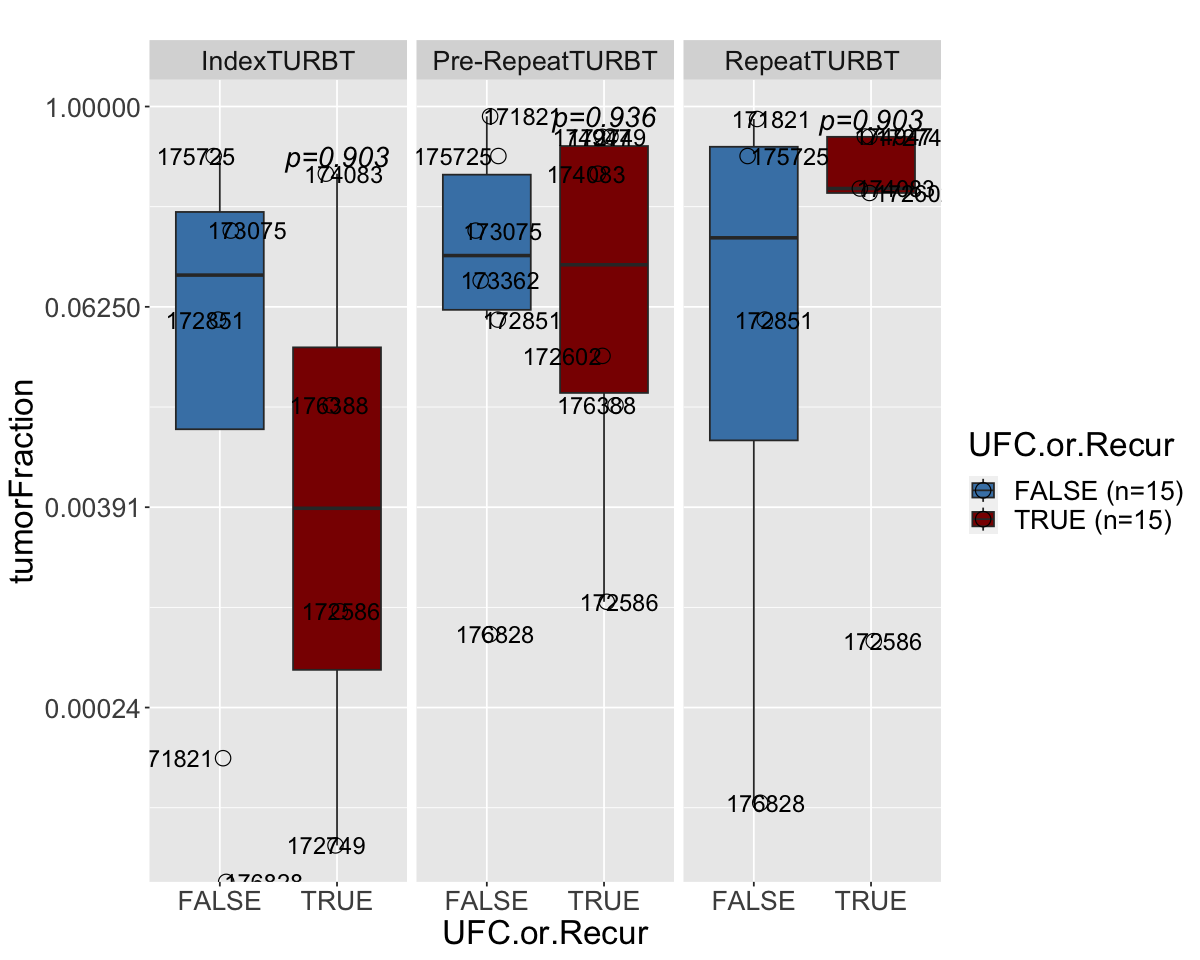

# A tibble: 31 × 4
   UFC.or.Recur   tf.m.f StudyVisit.baseline PatientID
   <fct>           <dbl> <chr>               <chr>    
 1 FALSE        0.000563 IndexTURBT          171821   
 2 FALSE        0.495    Pre-RepeatTURBT     171821   
 3 FALSE        0.693    RepeatTURBT         171821   
 4 TRUE         0.000907 IndexTURBT          172586   
 5 TRUE         0.000743 Pre-RepeatTURBT     172586   
 6 TRUE         0.000800 RepeatTURBT         172586   
 7 TRUE         0.0209   Pre-RepeatTURBT     172602   
 8 TRUE         0.132    RepeatTURBT         172602   
 9 TRUE         0.000264 IndexTURBT          172749   
10 TRUE         0.132    Pre-RepeatTURBT     172749   
# ℹ 21 more rows
Complete cases tf.m.f by UFC.or.Recur: 29
# A tibble: 2 × 4
  UFC.or.Recur count legend       color    
  <chr>        <chr> <chr>        <chr>    
1 FALSE        14    FALSE (n=14) steelblue
2 TRUE         15    TRUE (n=15)  darkred  
[1] "y"
# A tibble: 29 × 4
   UFC.or.Recur   tf.m.f StudyVisit.basel

Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”


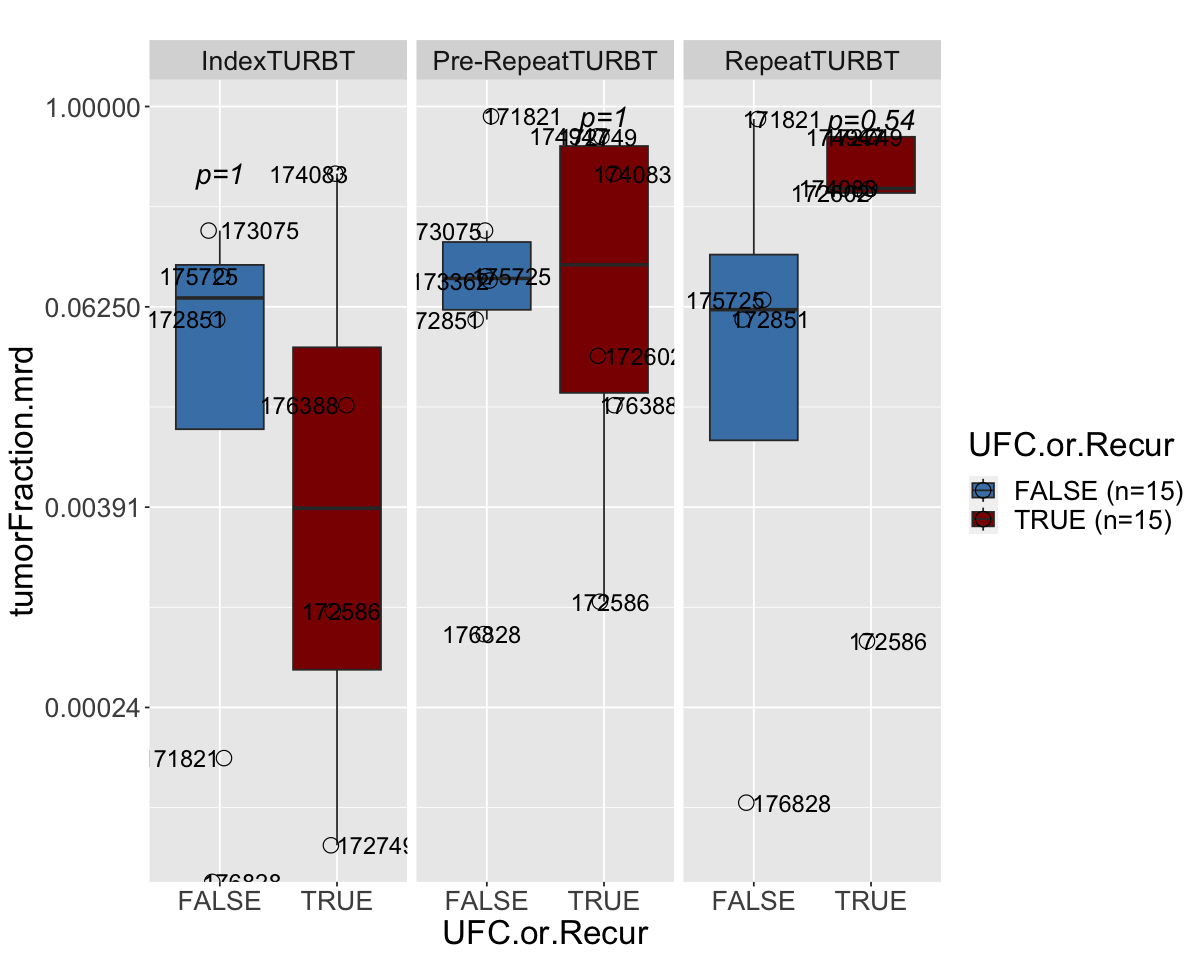

warn_na: WARN: NA or missing values in mrd.info.lod[[var]]: 1



# A tibble: 31 × 4
   UFC.or.Recur mrd.score StudyVisit.baseline PatientID
   <fct>            <dbl> <chr>               <chr>    
 1 FALSE             1.87 IndexTURBT          171821   
 2 FALSE            57.3  Pre-RepeatTURBT     171821   
 3 FALSE             4.38 RepeatTURBT         171821   
 4 TRUE             33.0  IndexTURBT          172586   
 5 TRUE             27.5  Pre-RepeatTURBT     172586   
 6 TRUE             20.4  RepeatTURBT         172586   
 7 TRUE              2.4  Pre-RepeatTURBT     172602   
 8 TRUE             16.8  RepeatTURBT         172602   
 9 TRUE              2.78 IndexTURBT          172749   
10 TRUE             12.0  Pre-RepeatTURBT     172749   
# ℹ 21 more rows
Complete cases mrd.score by UFC.or.Recur: 30
# A tibble: 2 × 4
  UFC.or.Recur count legend       color    
  <chr>        <chr> <chr>        <chr>    
1 FALSE        15    FALSE (n=15) steelblue
2 TRUE         15    TRUE (n=15)  darkred  
[1] "y"
# A tibble: 30 × 4
   UFC.or.Recur mrd.score 

Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”
warn_na: WARN: NA or missing values in mrd.info.lod[[var]]: 1



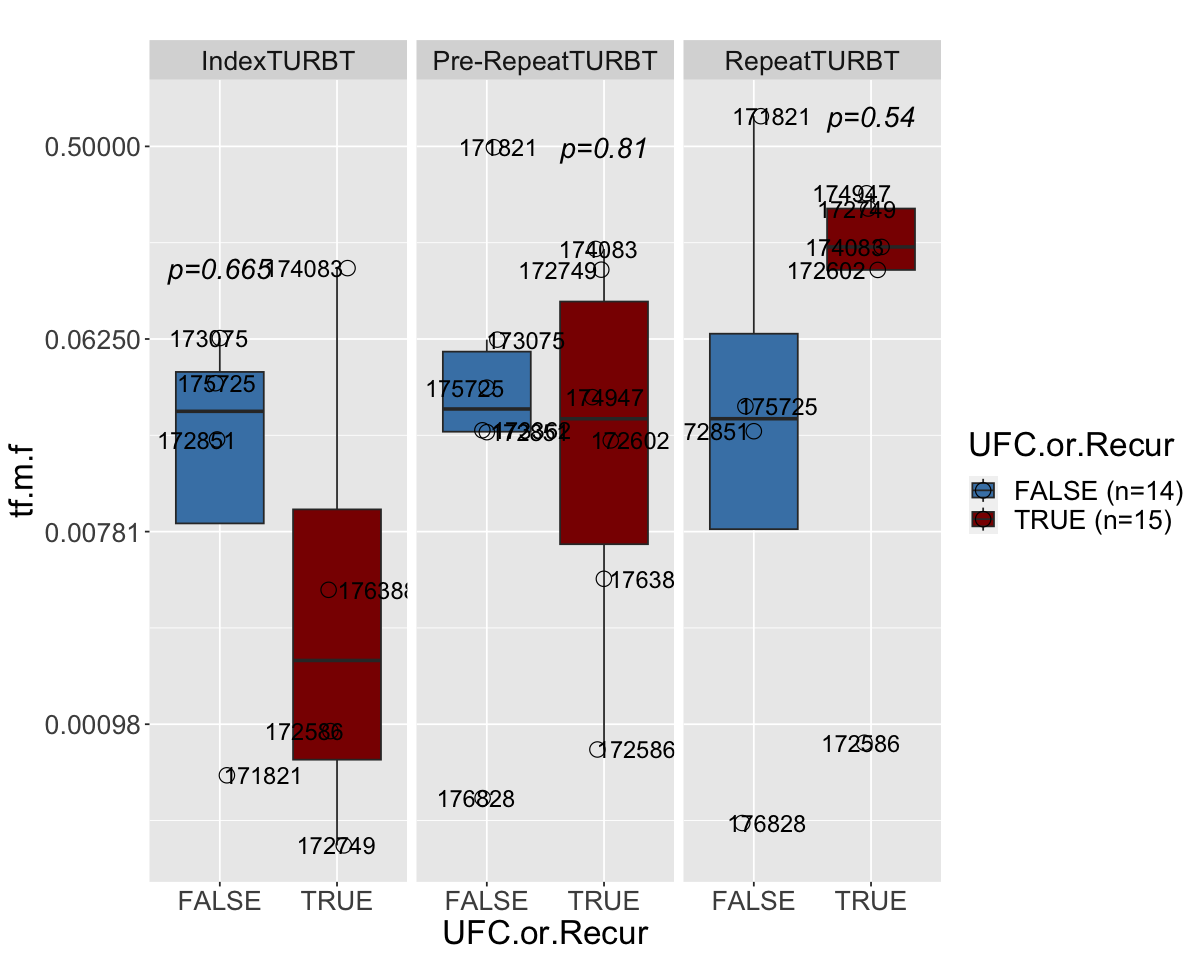

# A tibble: 31 × 4
   UFC.or.Recur mrd.score.noNovel StudyVisit.baseline PatientID
   <fct>                    <dbl> <chr>               <chr>    
 1 FALSE                    0.623 IndexTURBT          171821   
 2 FALSE                   56.0   Pre-RepeatTURBT     171821   
 3 FALSE                    3.12  RepeatTURBT         171821   
 4 TRUE                    33.0   IndexTURBT          172586   
 5 TRUE                    27.5   Pre-RepeatTURBT     172586   
 6 TRUE                    20.4   RepeatTURBT         172586   
 7 TRUE                     2.4   Pre-RepeatTURBT     172602   
 8 TRUE                    16.8   RepeatTURBT         172602   
 9 TRUE                     0.25  IndexTURBT          172749   
10 TRUE                     9.52  Pre-RepeatTURBT     172749   
# ℹ 21 more rows
Complete cases mrd.score.noNovel by UFC.or.Recur: 30
# A tibble: 2 × 4
  UFC.or.Recur count legend       color    
  <chr>        <chr> <chr>        <chr>    
1 FALSE        15    FALSE (n=15) ste

Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”


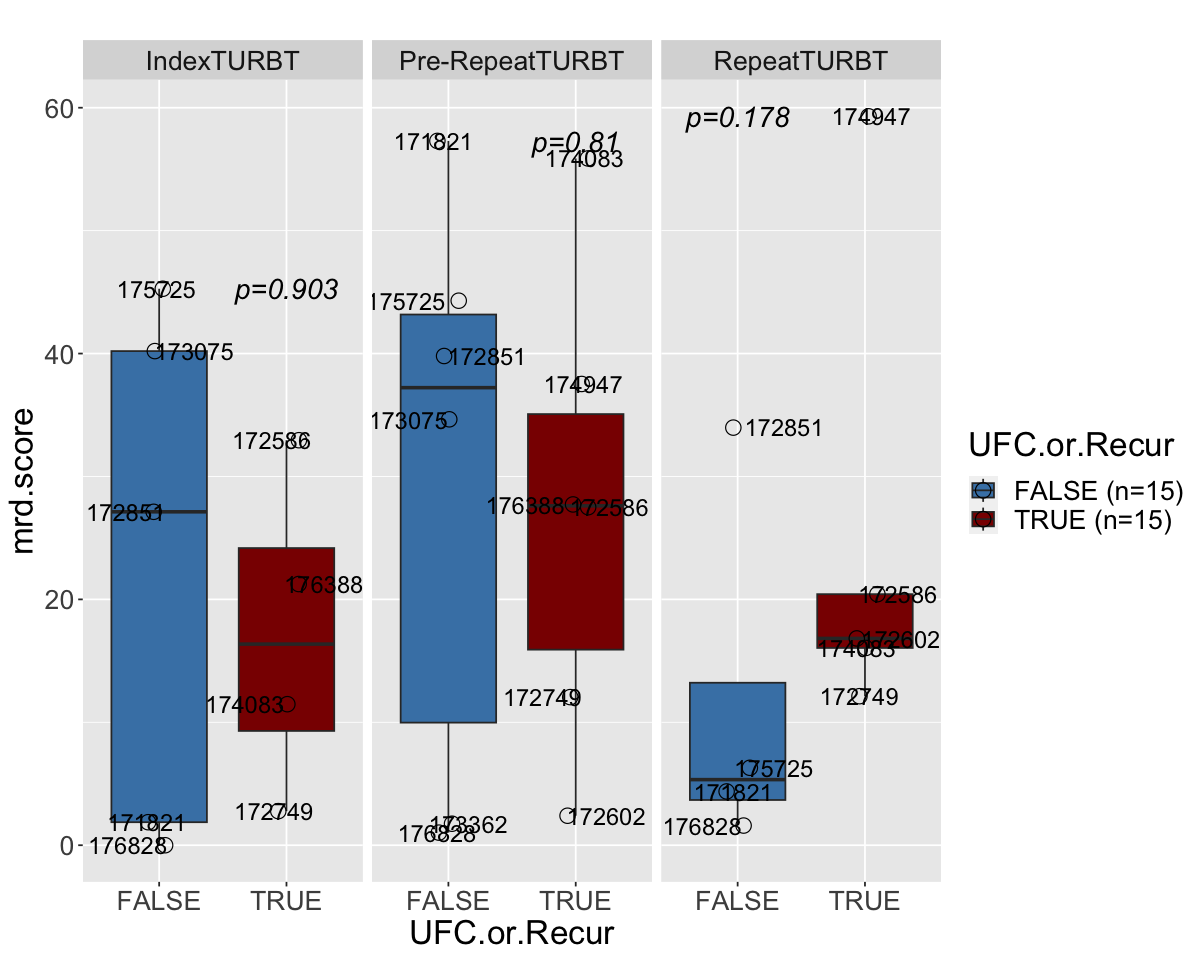

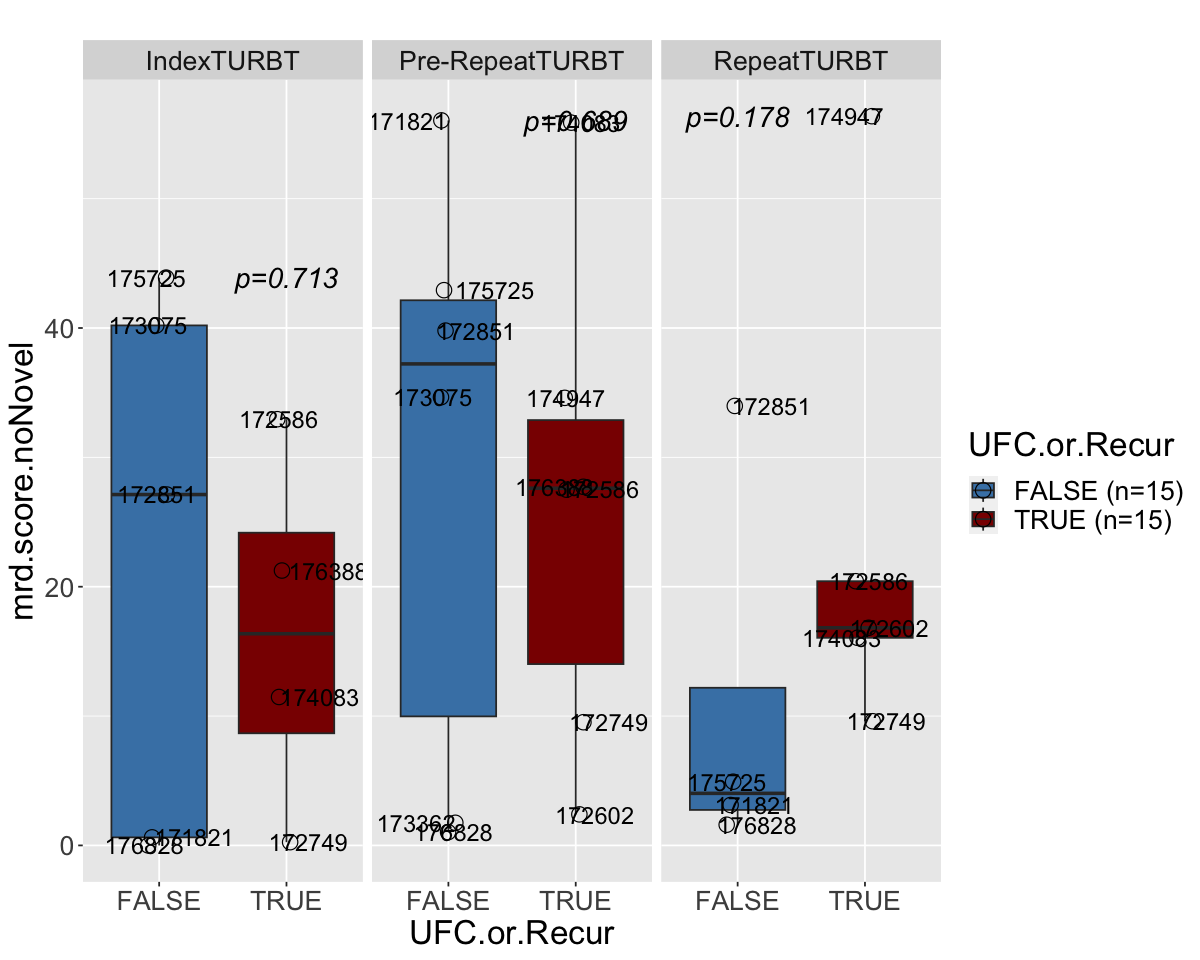

In [96]:
## MRD prediction of relapse Yes/No

# some patients have only repeat and no index - combine baselines?
source("~/Desktop/puffin/R/helper_functions.R")
options(repr.plot.width=10, repr.plot.height=8)

#why is the lowest non-zero TF value in the cohort lower than the LOD==0.0001 ???, skip lod fill for now
mrd.info.lod <- mrd.info.first %>% filter(Baseline.SID != "Pool",
                                          PatientID %!in% up.cyst.patients) ## exclude 3 - not improved
nrow(mrd.info.lod)
table(mrd.info.lod$SampleType.baseline) 

#pdf("./AUA/Relapse_Prediction_Boxplots_11042023.pdf", width=15, height=7, onefile = TRUE)
colors=c("FALSE"="steelblue","TRUE"="darkred")
vars = c("tumorFraction", "tumorFraction.mrd", "tf.m.f")
for (var in vars){
    warn_na(mrd.info.lod[[var]])
    pseudo.LOD = min(mrd.info.lod[[var]][mrd.info[[var]]!=0], na.rm = T)/2
    g <- quick_boxplot(df = mrd.info.lod, x="UFC.or.Recur", y=var, log.axes = TRUE, 
                  log.0.adj = pseudo.LOD,
                  facet="StudyVisit.baseline", print.p = T, colors=c("FALSE"="steelblue","TRUE"="darkred"))
    show(g)
}
vars = c("mrd.score", "mrd.score.noNovel")
for (var in vars){
    warn_na(mrd.info.lod[[var]])
    pseudo.LOD = min(mrd.info.lod[[var]][mrd.info[[var]]!=0], na.rm = T)/2
    g <- quick_boxplot(df = mrd.info.lod, x="UFC.or.Recur", y=var, log.axes = FALSE,
                  facet="StudyVisit.baseline", print.p = T, colors=c("FALSE"="steelblue","TRUE"="darkred"))
    show(g)
}
#dev.off()

In [104]:
dat = mrd.info.lod %>% select(PatientID, #SampleType.baseline, 
                        StudyVisit.baseline, mrd.status, tf.m.f, tumorFraction, UFC.or.Recur,any_cytology_atypical_up) %>%
        pivot_wider(id_cols = c("PatientID","UFC.or.Recur","any_cytology_atypical_up"), names_sep = " ",
                    names_from = "StudyVisit.baseline", 
                    values_from = c("mrd.status", "tf.m.f", "tumorFraction"))
dat
write.csv(dat, "./AUA/recurrence_data_table_11042023.csv", row.names=F)

PatientID,UFC.or.Recur,any_cytology_atypical_up,mrd.status IndexTURBT,mrd.status Pre-RepeatTURBT,mrd.status RepeatTURBT,tf.m.f IndexTURBT,tf.m.f Pre-RepeatTURBT,tf.m.f RepeatTURBT,tumorFraction IndexTURBT,tumorFraction Pre-RepeatTURBT,tumorFraction RepeatTURBT
<chr>,<fct>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
171821,FALSE,0,FALSE,TRUE,TRUE,0.0005626196,0.4953127063,0.6927489674,1.2113e-04,0.87341000,8.4133e-01
172586,TRUE,1,TRUE,TRUE,TRUE,0.0009067670,0.0007434236,0.0007997625,9.2483e-04,0.00105510,6.1205e-04
172602,TRUE,0,NA,TRUE,TRUE,NA,0.0209185994,0.1317672072,NA,0.03171600,3.0217e-01
172749,TRUE,1,TRUE,TRUE,TRUE,0.0002639916,0.1321087732,0.2556081781,3.6229e-05,0.65741000,6.5741e-01
172851,FALSE,1,TRUE,TRUE,TRUE,0.0211311621,0.0228587150,0.0230939849,5.2397e-02,0.05239700,5.2397e-02
173075,FALSE,0,TRUE,TRUE,NA,0.0631219505,0.0620773113,NA,1.7956e-01,0.17956000,NA
173362,FALSE,0,FALSE,TRUE,NA,NA,0.0233257251,NA,NA,0.08996200,NA
174083,TRUE,1,TRUE,TRUE,TRUE,0.1343535447,0.1652571283,0.1688798491,3.9469e-01,0.39469000,3.2150e-01
174947,TRUE,1,NA,TRUE,TRUE,NA,0.0333595093,0.3013332855,NA,0.66010000,6.6010e-01


`summarise()` has grouped output by 'PatientID', 'UFC.or.Recur', 'any_cytology_atypical_up'. You can override using the `.groups` argument.
warn_na: WARN: NA or missing values in mrd.info.lod2[[var]]: 1



# A tibble: 30 × 3
   UFC.or.Recur tumorFraction SampleType.baseline
   <fct>                <dbl> <chr>              
 1 TRUE               0.00682 Urine              
 2 FALSE              0.873   Urine              
 3 TRUE               0.428   Urine              
 4 TRUE               0.00106 Urine              
 5 TRUE               0.0317  Urine              
 6 TRUE               0.657   Urine              
 7 FALSE              0.0524  Urine              
 8 FALSE              0.180   Urine              
 9 TRUE               0.0173  Urine              
10 FALSE              0.0900  Urine              
# ℹ 20 more rows
Complete cases tumorFraction by UFC.or.Recur: 29
# A tibble: 2 × 4
  UFC.or.Recur count legend       color    
  <chr>        <chr> <chr>        <chr>    
1 FALSE        11    FALSE (n=11) steelblue
2 TRUE         18    TRUE (n=18)  darkred  
[1] "y"
# A tibble: 29 × 3
   UFC.or.Recur tumorFraction SampleType.baseline
   <fct>                <dbl> <fct>         

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”
warn_na: WARN: NA or missing values in mrd.info.lod2[[var]]: 1



# A tibble: 30 × 3
   UFC.or.Recur tumorFraction.mrd SampleType.baseline
   <fct>                    <dbl> <chr>              
 1 TRUE                   0.00160 Urine              
 2 FALSE                  0.873   Urine              
 3 TRUE                   0.428   Urine              
 4 TRUE                   0.00106 Urine              
 5 TRUE                   0.0317  Urine              
 6 TRUE                   0.657   Urine              
 7 FALSE                  0.0524  Urine              
 8 FALSE                  0.180   Urine              
 9 TRUE                   0.0173  Urine              
10 FALSE                  0.0900  Urine              
# ℹ 20 more rows
Complete cases tumorFraction.mrd by UFC.or.Recur: 29
# A tibble: 2 × 4
  UFC.or.Recur count legend       color    
  <chr>        <chr> <chr>        <chr>    
1 FALSE        11    FALSE (n=11) steelblue
2 TRUE         18    TRUE (n=18)  darkred  
[1] "y"
# A tibble: 29 × 3
   UFC.or.Recur tumorFraction.mrd SampleTy

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”
warn_na: WARN: NA or missing values in mrd.info.lod2[[var]]: 2



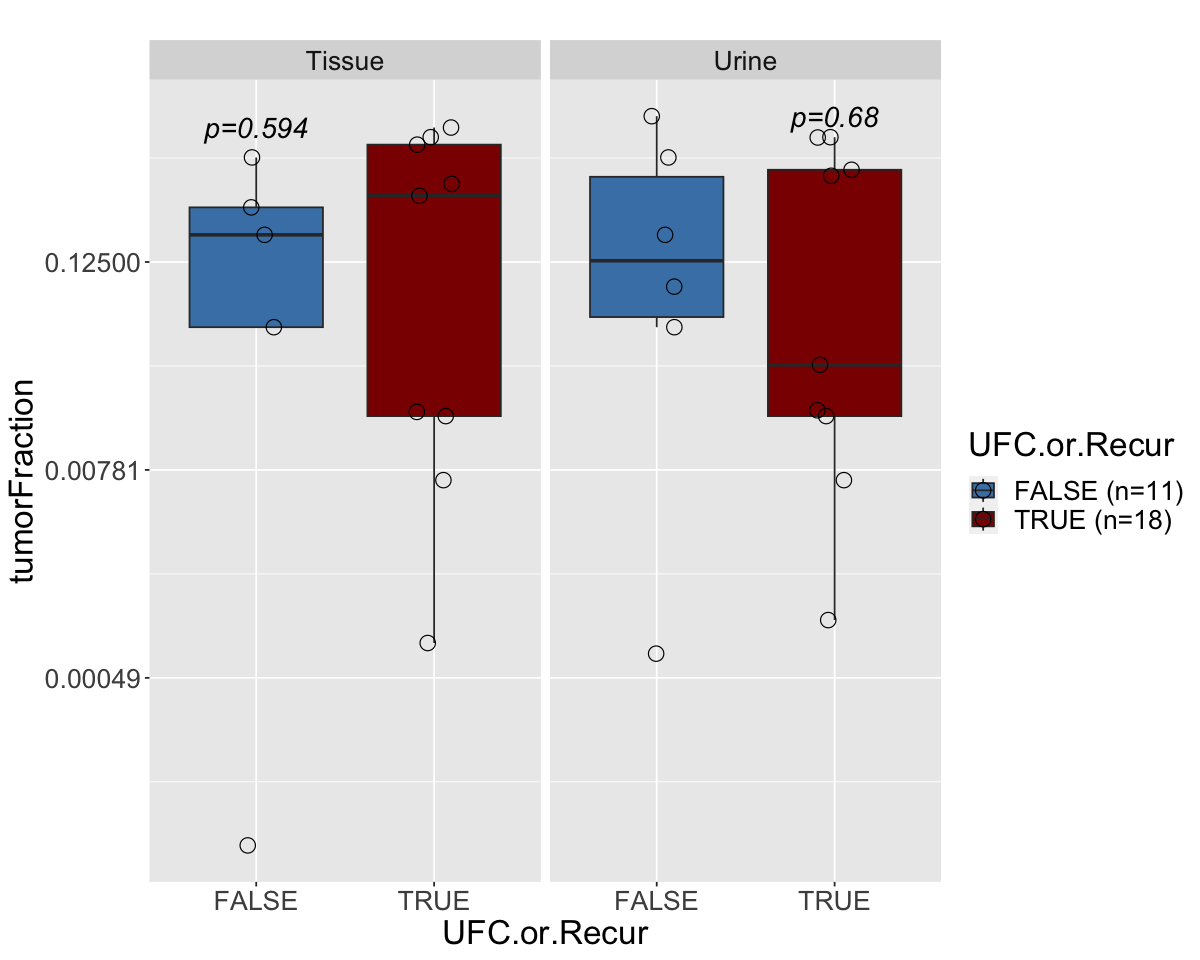

# A tibble: 30 × 3
   UFC.or.Recur   tf.m.f SampleType.baseline
   <fct>           <dbl> <chr>              
 1 TRUE         0.000855 Urine              
 2 FALSE        0.495    Urine              
 3 TRUE         0.158    Urine              
 4 TRUE         0.000743 Urine              
 5 TRUE         0.0209   Urine              
 6 TRUE         0.132    Urine              
 7 FALSE        0.0229   Urine              
 8 FALSE        0.0621   Urine              
 9 TRUE         0.00436  Urine              
10 FALSE        0.0233   Urine              
# ℹ 20 more rows
Complete cases tf.m.f by UFC.or.Recur: 28
# A tibble: 2 × 4
  UFC.or.Recur count legend       color    
  <chr>        <chr> <chr>        <chr>    
1 FALSE        10    FALSE (n=10) steelblue
2 TRUE         18    TRUE (n=18)  darkred  
[1] "y"
# A tibble: 28 × 3
   UFC.or.Recur   tf.m.f SampleType.baseline
   <fct>           <dbl> <fct>              
 1 TRUE         0.000855 Urine              
 2 FALSE        0.495    U

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


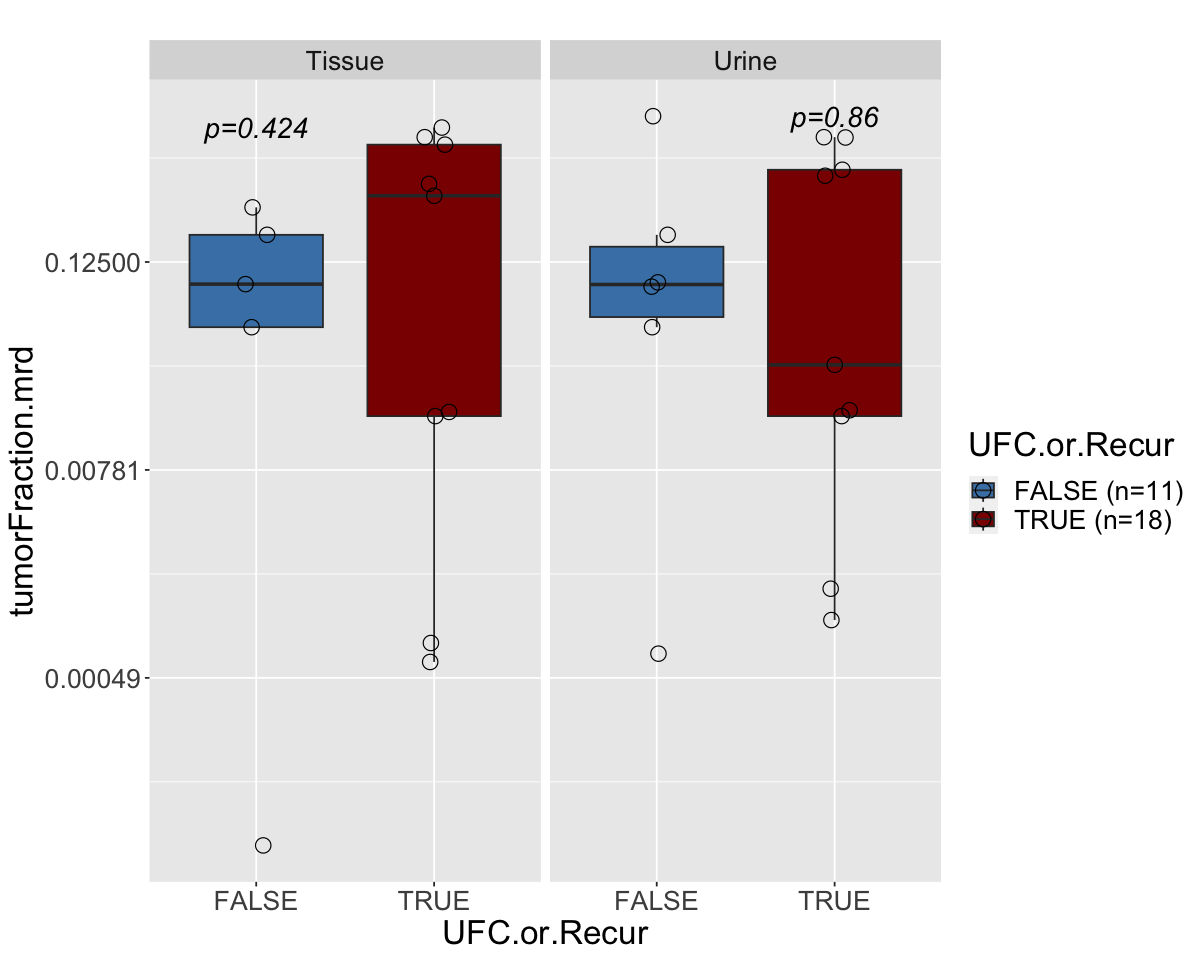

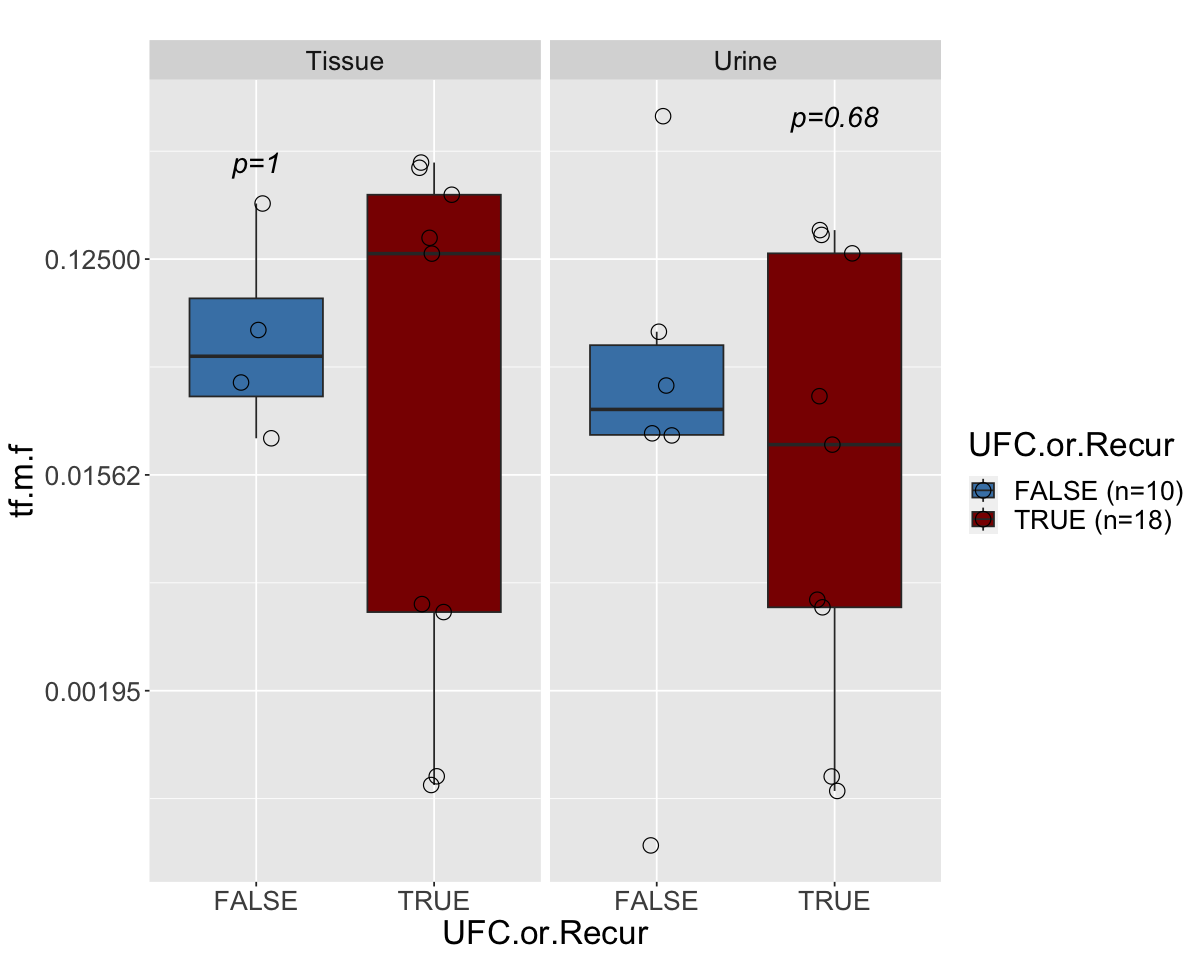

In [106]:
## combine tissue baselines weighted by mrd mutation count
source("~/Desktop/puffin/R/helper_functions.R")
df_urine_baseline.mrd = mrd.info.first %>% filter(SampleType.baseline=="Urine")

df_tissue_baseline.mrd = mrd.info.first  %>% filter(SampleType.baseline=="Tissue")

# weight by mutationCount.mrd
df_tissue_baseline.mrd = df_tissue_baseline.mrd %>% mutate("mutationCount.mrd.na" = ifelse(is.na(mutationCount.mrd),0,mutationCount.mrd)) %>%
            group_by(PatientID, UFC.or.Recur,any_cytology_atypical_up,any_cytology_suspicious_up) %>% 
            summarize("SampleType.baseline"="Tissue",
                  "tf.m.f"= weighted.mean(tf.m.f, mutationCount.mrd.na),
                  "mrd.status"= any(mrd.status=="TRUE"),
                  "tumorFraction"=weighted.mean(tumorFraction, mutationCount.mrd.na),
                  "tumorFraction.mrd"=weighted.mean(tumorFraction.mrd, mutationCount.mrd.na))


mrd.info.lod2 <- rbind(df_urine_baseline.mrd %>% select(PatientID, SampleType.baseline, tf.m.f,UFC.or.Recur,
                                                       mrd.status, tumorFraction, tumorFraction.mrd,
                                                      any_cytology_suspicious_up, any_cytology_atypical_up),
                      df_tissue_baseline.mrd) #%>% 
                    #filter(PatientID %!in% up.cyst.patients) not improved

#nrow(mrd.info.lod)
#table(mrd.info.lod$SampleType.baseline) 

#pdf("./AUA/Relapse_Prediction_Boxplots_11042023.pdf", width=15, height=7, onefile = TRUE)
colors=c("FALSE"="steelblue","TRUE"="darkred")
vars = c("tumorFraction", "tumorFraction.mrd", "tf.m.f")
for (var in vars){
    warn_na(mrd.info.lod2[[var]])
    pseudo.LOD = min(mrd.info.lod2[[var]][mrd.info[[var]]!=0], na.rm = T)/2
    g <- quick_boxplot(df = mrd.info.lod2, x="UFC.or.Recur", y=var, log.axes = TRUE, 
                  log.0.adj = pseudo.LOD,
                  facet="SampleType.baseline", print.p = T, colors=c("FALSE"="steelblue","TRUE"="darkred"))
    show(g)
}

## code for these plots is incorrect, rewrite
# vars = c("mrd.status", "any_cytology_atypical_up", "any_cytology_suspicious_up")
# for (var in vars){
#     warn_na(mrd.info.lod[[var]])
#     contingency_plot(mrd.info.lod %>% filter(SampleType.baseline=="Tissue"), x="UFC.or.Recur", y=var, title="tissue")
#     contingency_plot(mrd.info.lod %>% filter(SampleType.baseline=="Urine"), x="UFC.or.Recur", y=var, title="urine")
# }

In [108]:
dat = mrd.info.lod2 %>% select(PatientID, SampleType.baseline, 
                        #StudyVisit.baseline, 
                               mrd.status, tf.m.f, tumorFraction, UFC.or.Recur,any_cytology_atypical_up) %>%
        pivot_wider(id_cols = c("PatientID","UFC.or.Recur","any_cytology_atypical_up"), names_sep = " ",
                    names_from = "SampleType.baseline", 
                    values_from = c("mrd.status", "tf.m.f", "tumorFraction"))
dat
write.csv(dat, "./AUA/recurrence_data_table2_11042023.csv", row.names=F)

PatientID,UFC.or.Recur,any_cytology_atypical_up,mrd.status Urine,mrd.status Tissue,tf.m.f Urine,tf.m.f Tissue,tumorFraction Urine,tumorFraction Tissue
<chr>,<fct>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
171769,TRUE,0,TRUE,TRUE,0.0008547009,0.0007873245,0.00681690,0.0068169000
171821,FALSE,0,TRUE,TRUE,0.4953127063,0.2135430343,0.87341000,0.2589546285
172229,TRUE,0,TRUE,TRUE,0.1577772853,0.3168316832,0.42754000,0.7507300000
172586,TRUE,1,TRUE,TRUE,0.0007434236,0.0008562371,0.00105510,0.0007771283
172602,TRUE,0,TRUE,TRUE,0.0209185994,0.1317672072,0.03171600,0.3021700000
172749,TRUE,1,TRUE,TRUE,0.1321087732,0.2323950702,0.65741000,0.5976487481
172851,FALSE,1,TRUE,TRUE,0.0228587150,0.0222366600,0.05239700,0.0523970000
173075,FALSE,0,TRUE,TRUE,0.0620773113,0.0631219505,0.17956000,0.1795600000
173281,TRUE,0,TRUE,TRUE,0.0043630769,0.0045002241,0.01730700,0.0169300000


In [87]:
## manual sens and spect for mrd.status:
#mrd.info.lod
mrd.info.lod %>% filter(SampleType.baseline=="Tissue") - mrd.status: sens>9/9, spec>1/6
mrd.info.lod %>% filter(SampleType.baseline=="Urine") - mrd.status: sens>9/9, spec>1/6
#write.csv(mrd.info.lod, "./hybrid_probe_mrd/hybrid_mrd_data/mrd_info_annot_ASCOGU.csv")

PatientID,SampleType.baseline,tf.m.f,UFC.or.Recur,mrd.status,tumorFraction,tumorFraction.mrd,any_cytology_suspicious_up,any_cytology_atypical_up
<chr>,<chr>,<dbl>,<fct>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
171769,Urine,0.0008547009,TRUE,TRUE,0.0068169000,1.602829e-03,0,0
171821,Urine,0.4953127063,FALSE,TRUE,0.8734100000,8.734127e-01,0,0
172229,Urine,0.1577772853,TRUE,TRUE,0.4275400000,4.275358e-01,0,0
172586,Urine,0.0007434236,TRUE,TRUE,0.0010551000,1.055119e-03,1,1
172602,Urine,0.0209185994,TRUE,TRUE,0.0317160000,3.171642e-02,0,0
172749,Urine,0.1321087732,TRUE,TRUE,0.6574100000,6.574074e-01,1,1
172851,Urine,0.0228587150,FALSE,TRUE,0.0523970000,5.239675e-02,0,1
173075,Urine,0.0620773113,FALSE,TRUE,0.1795600000,1.795615e-01,0,0
173281,Urine,0.0043630769,TRUE,TRUE,0.0173070000,1.730703e-02,0,0


PatientID,SampleType.baseline,tf.m.f,UFC.or.Recur,mrd.status,tumorFraction,tumorFraction.mrd,any_cytology_suspicious_up,any_cytology_atypical_up
<chr>,<chr>,<dbl>,<fct>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
171769,Tissue,0.0007873245,TRUE,TRUE,0.0068169000,6.035378e-04,0,0
171821,Tissue,0.2135430343,FALSE,TRUE,0.2589546285,2.589537e-01,0,0
172229,Tissue,0.3168316832,TRUE,TRUE,0.7507300000,7.507257e-01,0,0
172586,Tissue,0.0008562371,TRUE,TRUE,0.0007771283,7.771259e-04,1,1
172602,Tissue,0.1317672072,TRUE,TRUE,0.3021700000,3.021666e-01,0,0
172749,Tissue,0.2323950702,TRUE,TRUE,0.5976487481,5.976464e-01,1,1
172851,Tissue,0.0222366600,FALSE,TRUE,0.0523970000,5.239675e-02,0,1
173075,Tissue,0.0631219505,FALSE,TRUE,0.1795600000,1.795615e-01,0,0
173281,Tissue,0.0045002241,TRUE,TRUE,0.0169300000,1.693044e-02,0,0


PatientID,SampleType.baseline,tf.m.f,UFC.or.Recur,mrd.status,tumorFraction,tumorFraction.mrd,any_cytology_suspicious_up,any_cytology_atypical_up
<chr>,<chr>,<dbl>,<fct>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
171769,Urine,0.0008547009,TRUE,TRUE,0.00681690,0.0016028286,0,0
171821,Urine,0.4953127063,FALSE,TRUE,0.87341000,0.8734126984,0,0
172229,Urine,0.1577772853,TRUE,TRUE,0.42754000,0.4275358048,0,0
172586,Urine,0.0007434236,TRUE,TRUE,0.00105510,0.0010551195,1,1
172602,Urine,0.0209185994,TRUE,TRUE,0.03171600,0.0317164179,0,0
172749,Urine,0.1321087732,TRUE,TRUE,0.65741000,0.6574074074,1,1
172851,Urine,0.0228587150,FALSE,TRUE,0.05239700,0.0523967509,0,1
173075,Urine,0.0620773113,FALSE,TRUE,0.17956000,0.1795615358,0,0
173281,Urine,0.0043630769,TRUE,TRUE,0.01730700,0.0173070267,0,0


## analyses for AUA 2023

In [77]:
# set annotation colors

# sample_type_cols = RColorBrewer::brewer.pal(n=8, name="Set1")[c(7,6,3,1)]
# names(sample_type_cols) = c("ffpe", "urine", "ucp","plasma")

sex_cols = RColorBrewer::brewer.pal(n=8, name = "Set1")[c(2,8)]
names(sex_cols) = c("Male","Female")

smoking_cols = RColorBrewer::brewer.pal(n = 8,name = "Greys")[c(6,8)]
names(smoking_cols) = c("Never smoked","Former smoker")

stage_cols = RColorBrewer::brewer.pal(n=8, name="Greens")[c(1,2,3,5,6,8)]
names(stage_cols) = c("T0","Tis","TaLG","TaHG","T1",">=T2")

# i_grade_cols = RColorBrewer::brewer.pal(n=8, name="Oranges")[c(1,3,7)]
# names(grade_cols) = c("Undetermined","Low","High")

# r_stage_cols = RColorBrewer::brewer.pal(n=8, name="Blues")[c(1,2,3,4,6,8)]
# names(r_stage_cols) = c("T0","Tis only","TaLG","TaHG","T1",">=T2")

history_cols = RColorBrewer::brewer.pal(n=8, name="BuPu")[c(2,8)]
names(history_cols) = c("No","Yes")

IVT_cols = RColorBrewer::brewer.pal(n=8, name="Set3")[1:4]
names(IVT_cols)=c("None","BCG","Gemcitabine +/- Docetaxel)","Mitomycin.C")

CIS_cols = RColorBrewer::brewer.pal(n=8, name="Reds")[c(1,8)]
names(CIS_cols) = c("No","Yes")

#histol_cols = c("Urothelial"="lightblue", "Sqamous Cell Carcinoma"="lightgreen")

#cnb_cols = colorRamp2(c(7.5,11.5), c("white", "red4"))
# Generate Oncoprint



[1] "df_samples"
[1] "snv.data"
[1] "cnv.data"
[1] "Consequence reduced colors"
   Missense  Truncating    In_Frame      UTR_5p      UTR_3p    Promoter 
"darkgreen"      "blue"   "darkred"     "cyan3"    "maroon"      "pink" 
       Gain        Loss   Multi_hit 
    "black"    "grey52"     "black" 
[1] "variant.data"
[1] "df_samples"
[1] "WARN: some variants finalKeep term unrecognized. Keeping these"
[1] TRUE   NA
[1] "WARN: some varaints is.na(Variant_Type). Treating as somatic."
[1] "Variant types present (selecting somatic):"
[1] "Somatic"        "Likely somatic"


WARN: NA or missing values in Tumor_Seq_Allele2: 1

WARN: NA or missing values in Chromosome: 1

WARN: NA or missing values in Start_Position: 1

WARN: NA or missing values in End_Position: 1

WARN: NA or missing values in Reference_Allele: 1

WARN: NA or missing values in Variant_Type: 1

WARN: NA or missing values in Hugo_Symbol: 1



[1] "Selected snvs: 1540"
[1] "variant.data"
[1] "df_samples"
[1] "Selected CNVs: 81"
-Validating
--Found  1  variants with no Gene Symbols
--Annotating them as 'UnknownGene' for convenience
--Non MAF specific values in Variant_Classification column:
  Missense
  Truncating
  In_Frame
  Promoter
  N.A.
  NULL
--Non MAF specific values in Variant_Type column:
  SNV
  deletion
  insertion
  NA
-Processing copy number data
-Summarizing
--Possible FLAGS among top ten genes:
  NEB
  DNAH11
-Processing clinical data
-Finished in 0.080s elapsed (0.079s cpu) 
                 Tumor_Sample_Barcode Tumor_Seq_Allele2 Chromosome
1: P220074_NMIBC010_indexturbt_tissue                 A       chr1
2: P220074_NMIBC010_indexturbt_tissue                 G       chr1
3: P220074_NMIBC010_indexturbt_tissue                 T       chr1
4: P220074_NMIBC010_indexturbt_tissue                 G       chr1
5: P220074_NMIBC010_indexturbt_tissue                 C       chr1
6: P220074_NMIBC010_indexturbt_tissue   

All mutation types: indexturbt_tissue.Loss, indexturbt_tissue.Missense,
repeatturbt_tissue.Missense, indexturbt_tissue.Truncating,
repeatturbt_tissue.Truncating, indexturbt_tissue.Gain,
repeatturbt_tissue.Gain, repeatturbt_tissue.Multi_hit,
indexturbt_tissue.Promoter, repeatturbt_tissue.Promoter,
indexturbt_tissue.Multi_hit.

Colors are not defined for: repeatturbt_tissue.Missense,
repeatturbt_tissue.Truncating, repeatturbt_tissue.Promoter,
repeatturbt_tissue.Gain, repeatturbt_tissue.Multi_hit,
indexturbt_tissue.Missense, indexturbt_tissue.Truncating,
indexturbt_tissue.Promoter, indexturbt_tissue.Gain,
indexturbt_tissue.Loss, indexturbt_tissue.Multi_hit. They won't be
shown in the barplots.



$oncoprint

$legend
A pack of 2 legends


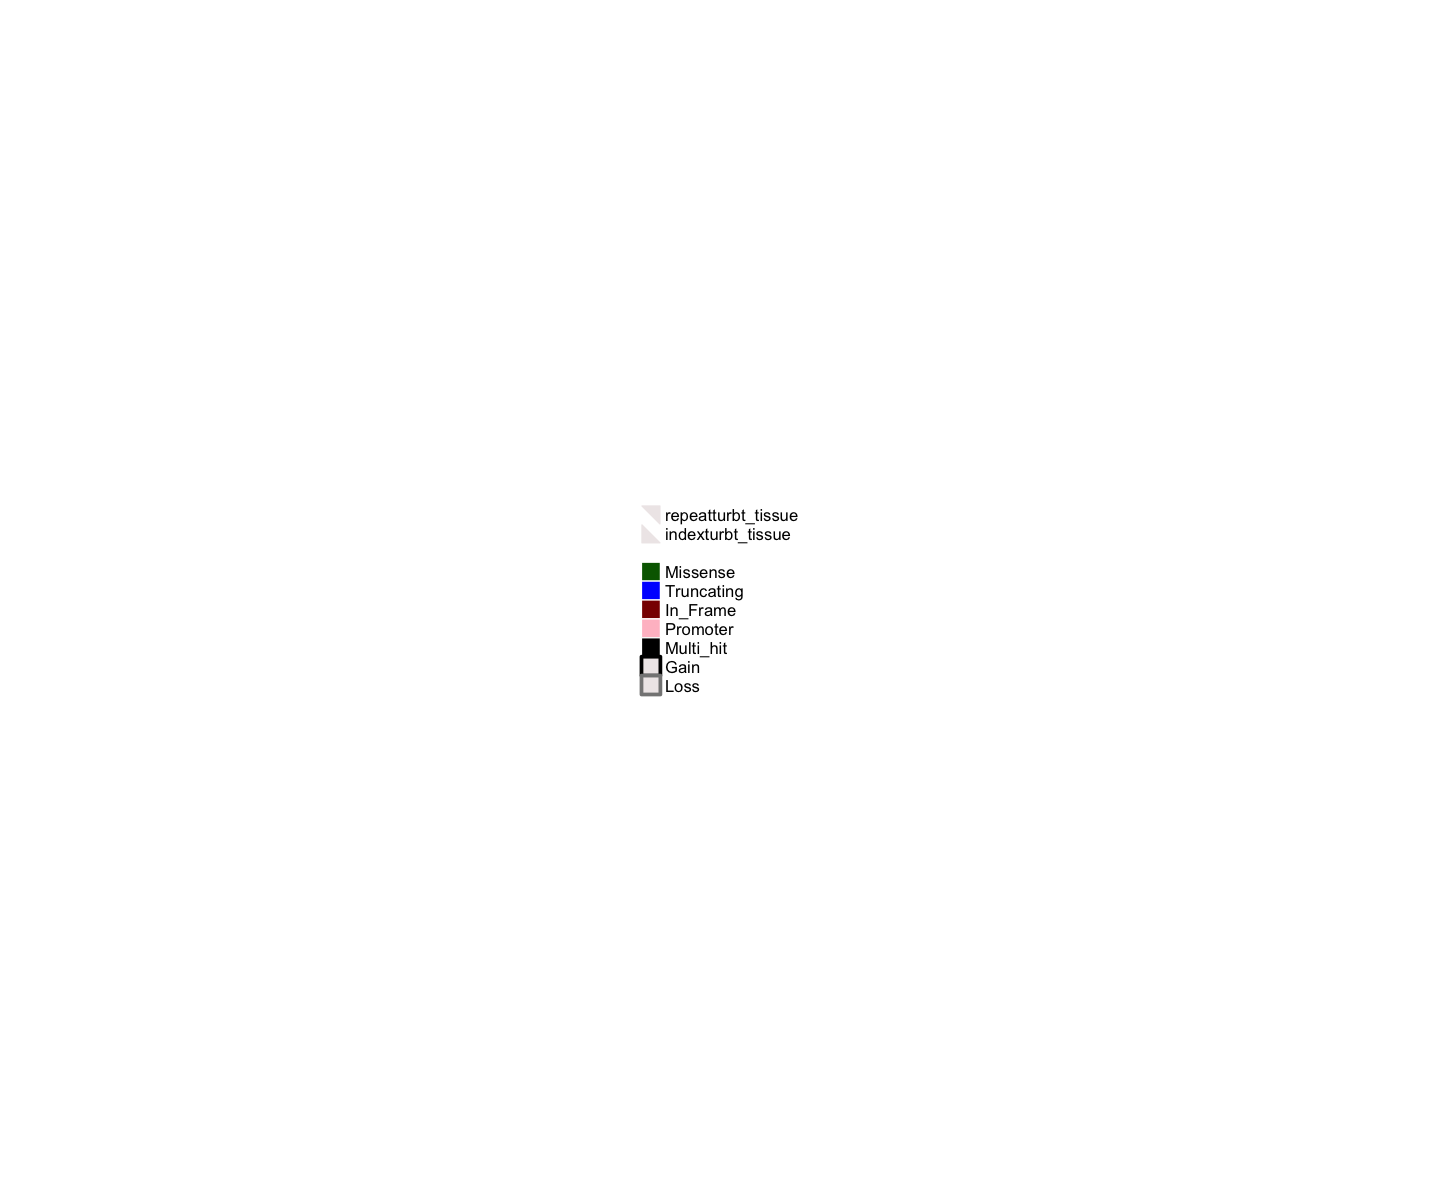

In [89]:
source("~/Desktop/puffin/R/concordance_oncoprint.R") # rerun

df_annot = df_clin %>%
    mutate(Index.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Index.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2")),
           Repeat.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Repeat.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2"))) %>%
    select("Smoking.Status", "Sex",
           "Previous history of NMIBC", "Prev.IV.Therapy",
           "Index.Stage", 'Index.CIS', "Repeat.Stage","Repeat.CIS", 
           "PatientID") 
df_samples = df_ffpe_index_repeat_paired %>%
               left_join(df_annot %>% select(Index.Stage, Repeat.Stage, PatientID), by="PatientID") %>%
               arrange(Index.Stage, Repeat.Stage)  # set the order
           
df_annot = df_annot %>% 
    rename("Index Stage"="Index.Stage","Repeat Stage"= "Repeat.Stage",
           "CIS at Index"="Index.CIS","CIS at Repeat"="Repeat.CIS",
                               "Smoking Status"= "Smoking.Status",
                               "Prev. IV Therapy"="Prev.IV.Therapy", 
                               "Previous History of NMIBC"="Previous history of NMIBC") # format the names

annot.colors = list("Index Stage" = stage_cols, 
                     "Repeat Stage"= stage_cols,
                     "CIS at Index" = CIS_cols,
                     "CIS at Repeat"= CIS_cols,
                     "Prev. IV Therapy"= IVT_cols,
                     "Previous History of NMIBC" = history_cols,
                     "Smoking Status" = smoking_cols,
                     "Sex" = sex_cols)

out.file = "./AUA/OncoPrint_Index_vs_Repeat_FFPE_unpatched_04042023"
concordance_oncoprint(snv.data = all.snv_wes,
                      cnv.data = all.cnv_wes,
                      df_samples = df_samples,
                      ref_sample_type="IndexTURBT_Tissue",
                      mrd_sample_type="RepeatTURBT_Tissue",
                      clin.data = df_annot,
                      show.clin.data = T,
                      clin.data.cols = names(annot.colors),
                      clin.annotation.colors = annot.colors,
                      show.patient.id=F,
                      make.legend=T,
                      concord.barplot=F,
                      show.top.n=25,
                      var.reduc.set="consequence_reduced",
                      var.colors="consequence_reduced",
                      out.file=out.file)

## some variants still == NULL annotation . . . look into this

In [333]:
source("~/Desktop/puffin/R/concordance_oncoprint.R") # rerun
#all.cnv_ = format_as_MAF(all.ffpe_cnv, df_samples = df_ffpe_qc, variant.type = "cnv", maf.output = F)  # update later

out.file = "./data_batch3_02222023/OncoPrint_Index_vs_Repeat_FFPE_unpatched_05082023"
concordance_oncoprint(snv.data = all.ffpe_snv,
                      cnv.data = all.ffpe_cnv, # already is maf
                      df_samples = df_ffpe_paired_wgerm,
                      ref_sample_type="IndexTURBT_Tissue",
                      mrd_sample_type="RepeatTURBT_Tissue",
                      clin.data = df_ffpe_paired_wgerm %>% filter(StudyVisit=="IndexTURBT") %>% select(PatientID, SampleType, StudyVisit),
                      show.clin.data = T,
                      #clin.data.cols = names(annot.colors),
                      #clin.annotation.colors = annot.colors,
                      show.patient.id=T,
                      make.legend=F,
                      concord.barplot=T,
                      show.top.n=25,
                      var.reduc.set="consequence_reduced",
                      var.colors="consequence_reduced",
                      out.file=out.file)

[1] "WARN: these variant classes missing from var.colors."
       class present
1       Gain   FALSE
2       Loss   FALSE
3   Missense   FALSE
4 Truncating   FALSE
5   In_Frame   FALSE
6   Promoter   FALSE
7     UTR_5p   FALSE
[1] "TRUE" NA    
[1] "WARN: some variants finalKeep term unrecognized. Keeping these"
[1] "WARN: some varaints is.na(Variant_Type). Treating as somatic."
[1] "SNV types present (selecting somatic):"
[1] "Somatic"        "Likely somatic"


Adding missing grouping variables: `PatientID`
warn_na: WARN: NA or missing values in Tumor_Seq_Allele2: 39

warn_na: WARN: NA or missing values in Chromosome: 39

warn_na: WARN: NA or missing values in Start_Position: 39

warn_na: WARN: NA or missing values in End_Position: 39

warn_na: WARN: NA or missing values in Reference_Allele: 39

warn_na: WARN: NA or missing values in Variant_Type: 39

warn_na: WARN: NA or missing values in Hugo_Symbol: 39

warn_na: WARN: NA or missing values in Tumor_Sample_UUID: 38



[1] "Selected snvs: 6121"
[1] "Selected CNVs: 148"
-Validating
--Found  39  variants with no Gene Symbols
--Annotating them as 'UnknownGene' for convenience
--Non MAF specific values in Variant_Classification column:
  Missense
  Truncating
  In_Frame
  N.A.
  Promoter
  UTR_5p
  NULL
--Non MAF specific values in Variant_Type column:
  SNV
  deletion
  insertion
  indel
  NA
-Silent variants: 15 
-Processing copy number data
-Summarizing
--Possible FLAGS among top ten genes:
  DNAH11
-Processing clinical data
--Annotation missing for below samples in MAF:
  P228841_167162_NA_NA
  P228842_167162_NA_NA
  P228843_171821_NA_NA
  P228844_171821_NA_NA
  P228846_172749_NA_NA
  P228847_172749_NA_NA
  P228853_173350_NA_NA
  P228854_173350_NA_NA
  P228856_173975_NA_NA
  P228857_173975_NA_NA
  P228858_174083_NA_NA
  P228859_174083_NA_NA
  P228864_175325_NA_NA
  P228865_175325_NA_NA
  P228866_175387_NA_NA
  P228867_175387_NA_NA
  P228868_175425_NA_NA
  P228869_175425_NA_NA
  P228870_175492_NA_NA
 

Found NA values in the matrix and treat as no alteration. If `NA` means
no alteration, you can explicitly set it to empty strings like ''. If
`NA` is an alteration type, you should format it to a string like
`'NA'` and define graphics for it.

All mutation types: .



ERROR: Error in mat_list[[1]]: subscript out of bounds


In [ ]:
# all.snv_wes %>% filter(SampleID.short=="P220080") # all variants for the repeat turbt were called as germline

## oncoplot of concordant urine/index mutations (only BEACON MRD markers and pathogenic hotspot panel variants, for AUA)

In [181]:
df_snv1 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00252_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")
df_snv2 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00253_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")
df_snv3 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00254_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")

df_snv = standardize_names(rbind(df_snv1,df_snv2,df_snv3)) %>% mutate(SampleID.short = make_SIDshort(sampleNames))
write.csv(df_snv, "./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short_urine.csv", row.names=F)

print("summary")

df_all_vars = df_snv %>%  
    group_by(SampleID.short) %>% summarize(all.mutations.clinicOnly=n())

df_good_vars = df_snv %>% 
    filter(finalKeep %!in% c("FALSE","lowConfidence"),
                             grepl("somatic", VariantType, ignore.case=T)) %>%
    group_by(SampleID.short) %>% summarize(good.mutations.clinicOnly=n())

df_all_probes = df_snv %>% filter(wl.tier=="T00") %>%
    group_by(SampleID.short) %>% summarize(detected.probes.clinicOnly=n())

df_good_probes = df_snv %>% 
                            filter(finalKeep %!in% c("FALSE","lowConfidence"),
                                   grepl("somatic", VariantType, ignore.case=T)) %>%
                            filter(wl.tier=="T00") %>%
   group_by(SampleID.short) %>% summarize(good.detected.probes.clinicOnly=n())

df_summary = df_all_vars %>% full_join(df_good_vars, by="SampleID.short") %>% 
                             full_join(df_all_probes, by="SampleID.short") %>% 
                             full_join(df_good_probes, by="SampleID.short") %>% 
                             left_join(mrd.table, by="SampleID.short") %>%
                             left_join(df_clin %>% select(PatientID, is.repeat.pos), by="PatientID") %>% 
                             filter(StudyVisit %!in% c("Post TURBT","Surveillance 1"),
                                    SampleType %in% c("Urine","UCP")) %>%
                             relocate(PatientID, SampleID.short, SampleType, StudyVisit, is.repeat.pos, MRD.call)
df_summary ## MRD negative calls : 016 (true negative) and 021 (false negative, TF=0.00)

write.csv(df_summary, "./data/Urine-UCP/BEACON_pre_repeat_urine_mutaiton_counts_02172023.csv", row.names=F)

[1] "WARN: Missing: PatientID or SubjectID"
[1] "WARN: Missing: trialVisitNum or StudyVisit"
[1] "WARN: Missing: SampleType or SpecimenType"
[1] "summary"


PatientID,SampleID.short,SampleType,StudyVisit,is.repeat.pos,MRD.call,all.mutations.clinicOnly,good.mutations.clinicOnly,detected.probes.clinicOnly,good.detected.probes.clinicOnly,N.baseline.muts.detected.mrdInfo,N.personal.probes.detected.mrdInfo,MRD.score,TF.dynamic.muts.mrdInfo,TF.dynamic.highqual.muts.mrdInfo
<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
NMIBC010,P217590,Urine,Pre-Repeat TURBT,TRUE,TRUE,40,38,40,38,39,36,9.25,0.677,0.1625357483
NMIBC005,P217591,Urine,Pre-Repeat TURBT,TRUE,TRUE,41,40,34,34,27,29,2.50,0.705,0.3306003890
NMIBC035,P217592,Urine,Pre-Repeat TURBT,TRUE,TRUE,40,40,36,36,40,36,36.00,0.683,0.0579642593
NMIBC009,P217594,Urine,Pre-Repeat TURBT,FALSE,TRUE,38,32,34,31,33,30,31.50,0.380,0.0072417228
NMIBC019,P217595,Urine,Pre-Repeat TURBT,FALSE,TRUE,54,29,53,28,38,36,29.00,0.702,0.0005027954
NMIBC016,P217596,Urine,Pre-Repeat TURBT,FALSE,FALSE,26,NA,26,NA,6,6,1.50,0.589,0.0000000000
NMIBC021,P219768,Urine,Pre-Repeat TURBT,TRUE,FALSE,32,22,32,22,2,2,1.00,0.281,0.0000000000
NMIBC003,P219770,Urine,Pre-Repeat TURBT,TRUE,TRUE,78,77,69,69,72,64,8.75,0.643,0.6641799480
NMIBC013,P219771,Urine,Pre-Repeat TURBT,TRUE,TRUE,78,67,75,65,72,70,68.50,0.676,0.0039131614


In [78]:
unique(df_qc$StudyVisit)
unique(df_qc$SampleType)

df_clin_annot = df_clin %>% mutate(#SampleType2 = "Tissue",
           Index.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Index.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2")),
           Repeat.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Repeat.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2"))) %>%
    arrange(Index.Stage) %>% 
    select(#"Tumor_Sample_Barcode", 
           "Smoking.Status", "Sex",
           "Previous history of NMIBC", "Prev.IV.Therapy",
           "Index.Stage", 'Index.CIS', "Repeat.Stage","Repeat.CIS","PatientID", "is.repeat.pos")


[1] "IndexTURBT"       "RepeatTURBT"      "Pre-Repeat TURBT" "Post TURBT"      
[5] "Surveillance 1"

[1] "FFPE"   "PBMC"   "Urine"  "Plasma" "UCP"

In [131]:
# select samples with qc!="Fail", has.Index, has MRD results even if no variants, 
source("~/Desktop/puffin/R/format_as_MAF.R")

df_ffpe_index = df_qc %>% filter(SampleType=="FFPE", StudyVisit=="IndexTURBT")
nrow(df_ffpe_index)
df_pre_urine_ucp = df_qc %>% filter(SampleType %in% c("Urine","UCP"), 
                                    StudyVisit=="Pre-Repeat TURBT",
                                    SampleID.short %in% df_mrd$SampleID.short,
                                    PatientID %in% df_ffpe_index$PatientID) %>%
                         left_join(df_clin_annot, by="PatientID") %>% 
                         rename("Smoking.Status"="Smoking.Status",
                                "Prev.History.NMIBC"="Previous history of NMIBC") %>%
                         mutate(across(everything(), as.character))
                         
# select variants
df_snv_sel = df_snv %>% filter(SampleID.short %in% df_pre_urine_ucp$SampleID.short, 
                               wl.tier=="T00") %>%
                        left_join(df_pre_urine_ucp, by="SampleID.short")

# must be a line in the maf snv data for all samples to include zero variant samples in plot
df_snv_selected_maf = format_as_MAF(df_snv_sel, df_pre_urine_ucp, # with df_samples input, includes 0 var samples
                                    variant.type="snv")
unique(df_snv_selected_maf$Tumor_Sample_Barcode)


[1] 11

Warning message in if (is.na(df_samples)) {:
“the condition has length > 1 and only the first element will be used”


[1] "Selected snvs: 399"


[1] "NMIBC033_Pre-Repeat TURBT_UCP"   "NMIBC021_Pre-Repeat TURBT_Urine"
 [3] "NMIBC003_Pre-Repeat TURBT_Urine" "NMIBC013_Pre-Repeat TURBT_Urine"
 [5] "NMIBC014_Pre-Repeat TURBT_Urine" "NMIBC010_Pre-Repeat TURBT_Urine"
 [7] "NMIBC005_Pre-Repeat TURBT_Urine" "NMIBC035_Pre-Repeat TURBT_Urine"
 [9] "NMIBC009_Pre-Repeat TURBT_Urine" "NMIBC019_Pre-Repeat TURBT_Urine"
[11] "NMIBC016_Pre-Repeat TURBT_Urine"

In [ ]:
## it seems that all urine variants were filtered out for patient NMIBC016
names(df_snv_sel)
df_snv_sel %>% filter(grepl('NMIBC016', PatientID)) %>% relocate(PatientID, SampleType, VariantType, finalKeep)

## NMIBC-021 had 2 variants detected, but had MRD.score=1.0

In [132]:
# there must be a color for Variant_Classification that is N.A. for placeholder mutations
# filter out of plot using var_type_incl below

var_reduc_dict = list(Missense = c("missense_variant","missense_variant&splice_region_variant"),
                   Synonymous = c("synonymous_variant","stop_retained_variant"),
                   N.A. = c('downstream_gene_variant',"intergenic_variant", "N.A."),
                   Promoter = c("upstream_gene_variant"),
                   Truncating = c('frameshift_variant',
                                   'stop_gained',
                                   'start_lost',
                                   'splice_donor_variant',
                                   'stop_gained&splice_region_variant',
                                   'stop_retained_variant',
                                   'splice_acceptor_variant',
                                  "splice_region_variant&synonymous_variant",
                                  "splice_donor_variant",
                                   'stop_gained&frameshift_variant'),
                    Intronic = c("intron_variant","intron_variant&non_coding_transcript_variant"),
                    In_Frame = c('inframe_deletion','inframe_insertion'),
                    UTR_3p =c('3_prime_UTR_variant'),
                    UTR_5p =c('5_prime_UTR_variant'))

bgCol = "#CCCCCC" #default oncoplot bgdcol
var_color_vec = c(
    "Missense" = "darkgreen", 
    "Truncating" = "blue",
    "In_Frame" = "darkred",
    "UTR_5p" = "cyan3",
    "UTR_3p" = "pink",
    "Gain" = "black",
    "Loss" = "grey52",
    "Multi_Hit" = "grey39",
    "Intronic"="springgreen3",
    "Synonymous"="slateblue1",
    "Promoter"="indianred3",
    "N.A."= bgCol
)

df_snv_selected_maf$Variant_Classification = factor(df_snv_selected_maf$Variant_Classification)
levels(df_snv_selected_maf$Variant_Classification) <- var_reduc_dict

In [133]:
df_pre_urine_ucp = df_pre_urine_ucp %>% unite(Tumor_Sample_Barcode, c(PatientID,StudyVisit,SampleType), remove=FALSE)

var_type_include = unique(df_snv_selected_maf$Variant_Classification[df_snv_selected_maf$Variant_Classification!="N.A."])

dat <- read.maf(df_snv_selected_maf, 
                cnTable = NULL, 
                vc_nonSyn = var_type_include, 
                clinicalData = df_pre_urine_ucp)

-Validating
--Found  5  variants with no Gene Symbols
--Annotating them as 'UnknownGene' for convenience
--Non MAF specific values in Variant_Classification column:
  Missense
  Truncating
  Synonymous
  Intronic
  N.A.
  UTR_3p
  In_Frame
  Promoter
--Non MAF specific values in Variant_Type column:
  SNV
  deletion
  insertion
  substitution
  NA
-Silent variants: 6 
-Summarizing
-Processing clinical data
-Finished in 0.093s elapsed (0.049s cpu) 


In [145]:
# reference oncoplot (squares only) with all samples

#pdf('./AUA/Oncoplot_abstract2_MRD_11012022.pdf', width=15, height = 20)
pdf('./ASCO_GU/Beacon_Oncoplot_02152023.pdf', width=15, height = 25)

options(repr.plot.width=13, repr.plot.height=20)

#sample_type_cols = c("Urine"="darkgoldenrod1", "UCP"="darkgoldenrod3")

# for sample ordering
df_pre_urine_ucp = df_pre_urine_ucp %>% mutate(Repeat.Stage = factor(Repeat.Stage, levels=c("T0","Tis","TaLG","TaHG","T1",">=T2"))) %>%
    arrange(Repeat.Stage, Index.Stage)
# PID_cols = colorRamps::primary.colors(n=length(df_pre_urine_ucp$PatientID))
# names(PID_cols) = df_pre_urine_ucp$PatientID

clin_cols = list(#SampleType=sample_type_cols, 
                 Sex=sex_cols, 
                 Smoking.Status=smoking_cols, 
                 Index.Stage=stage_cols,
                 Repeat.Stage=stage_cols,
                 Index.CIS=CIS_cols,
                 Repeat.CIS=CIS_cols,
                 Prev.History.NMIBC=history_cols,
                Prev.IV.Therapy=IVT_cols#,
                #PatientID=PID_cols
)

# must be a line in the maf snv data for all samples to include zero variant samples here
# all variant_classifications have to be in the var_color_vec for ANY colors to show up
oncoplot(dat, top=40, sortByMutation=F, showTitle = F, colors = var_color_vec, removeNonMutated = F, fill=T, barcode_mar = 8,
         showTumorSampleBarcodes=F, fontSize = 1.5, SampleNamefontSize = 1, sampleOrder = df_pre_urine_ucp$Tumor_Sample_Barcode,
          clinicalFeatures = c(#"SampleType"),
               "Repeat.Stage",
              "Index.Stage",
              "Repeat.CIS",
             "Index.CIS", 
             "Prev.History.NMIBC",
             "Prev.IV.Therapy",
             "Smoking.Status",
             "Sex"#,
#             "PatientID",
            #"is.repeat.pos"
         ),
        anno_height=3, gene_mar=12,
        drawRowBar=F, drawColBar=F, annotationColor=clin_cols,legendFontSize=3, annotationFontSize=1.5)


dev.off()

pdf 
  2

## compare concordance between BEACON urine and WES ffpes

In [103]:
# high conf variants

df_all_qc = read.csv(file = "./data/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2022-09-23_urine_ucp_pbmc_ffpe.csv",as.is=T) %>% filter(QC_Status!="Fail", Specimen_type!="Buffy Coat") %>%
                rename("StudyVisit"=trialVisitNum, "SampleType"=Specimen_type) %>%
                mutate("SampleID.short"=make_SIDshort(SampleID), "PatientID"=fix_PIDs(PatientID))

# Variant Short Marked inputs
# all.urine.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-01_supernatant_marked.csv") 
all.urine.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-12-01_supernatant_marked.csv",
                        as.is=T)
#all.ucp.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-01_urine cell pellet_marked.csv")
all.ucp.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-12-01_urine cell pellet_marked.csv",
                      as.is=T)
## FFPE variants, unpatched  ## use filtered?, or use Patched file here instead?
#all.ffpe.snv = read.csv("./data/FFPE_WES/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-06_tissue_marked.csv")
#all.ffpe.snv = read.csv("./data/FFPE_WES/Peter_analysis _files/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_FFPE_filtered_double_patched.csv"
all.ffpe.snv = read.csv("./data/FFPE_WES/Peter_analysis _files/WOP00249_WOP00250_PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_filtered.csv",
                        as.is=T)

# beacon.markers = all.ffpe.snv %>% filter(Selected %in% c("Yes","Core"))
# You need to run the postAnalysis R script I provided for MRD panel design. 
# (/home/pdu/Projects/TechEval/Rscript_templates/MRD_analysis_template_V2.R)
# need also the hotspot panel regions
# can run on existing _filtered.csv file or find peters copy here:
# /home/pdu/Projects/OtherAnalysis/MOFFITT/PRDC-MOFFITT-NMIBC-MIBC-22001

# cols <- intersect(names(all.urine.snv), names(all.ffpe.snv))
# all.snv_unfilt = rbind(beacon.markers[,cols], all.ucp.snv[,cols], all.ffpe.snv[,cols]) %>%
#             distinct()

# all.snv = all.snv_unfilt %>% filter(grepl("somatic", VariantType, ignore.case=T), !(finalKeep %in% c("Low Confidence", "FALSE"))) %>%
#             mutate("SampleID.short"=make_SIDshort(sampleNames)) %>%
#             distinct() %>%
#             group_by(PatientID, VariantID) %>% mutate(CONCORDANT=(n()>1)) %>% ungroup()
# head(all.snv)
# # write.table(all.snv, "./data/Urine-UCP/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked_somatic.txt", sep="\t",
# #             row.names=F, col.names=T, quote=F)

# nrow(all.snv)
# table(df_all_qc$SampleType)


In [46]:
out_bed = all.snv %>% mutate(zero = 0, dot = ".") %>% select(seqnames, start, end, VariantID, VariantFreq, PatientID, SpecimenType, trialVisitNum, SampleID.short)
write.table(out_bed, "./data/all_snv_ffpe_urine_ucp_short_somatic_12212022.bed", sep="\t", row.names=F, col.names=F, quote=F)

In [45]:
# run on server  ## change this to the hotspot panel PREDICINE_MRD_V1
# library(rtracklayer)
# tmp <- NGSutilities::getPanelTargetRegion("PREDICINEATLAS_V2")
# export(tmp, 'ATLAS_V2_target_regions_12012022.bed')

# tmp <- NGSutilities::getPanelTargetRegion("PREDICINEWES_V1") # couldnt transform this one to bed
# export(tmp, 'PREDICINEWES_V1_target_regions_12022022.bed')

# maybe overlap VRanges objects on server before export??
atlas.bed = read.csv("../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed", sep="\t",
                     stringsAsFactors=F, header=F)
names(atlas.bed) <- c("chr","start","stop","name","zero","dot")
tail(atlas.bed)

# run:
# bedtools intersect -a all_snv_ffpe_urine_ucp_short_somatic_12212022.bed -b ../../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed -wa > NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed 

,chr,start,stop,name,zero,dot
,<chr>,<int>,<int>,<chr>,<int>,<chr>
23280,chrY,2655606,2655727,chrY:2655607:2655727,0,.
23281,chrY,2847966,2848086,chrY:2847967:2848086,0,.
23282,chrY,6738492,6738612,chrY:6738493:6738612,0,.
23283,chrY,19490154,19490274,chrY:19490155:19490274,0,.
23284,chrY,26764543,26764664,chrY:26764544:26764664,0,.
23285,chrY,26764603,26764724,chrY:26764604:26764724,0,.


In [ ]:
# run:
# bedtools intersect -a all_snv_ffpe_urine_ucp_short_somatic_12212022.bed -b ../../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed -wa > NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed 

In [17]:
all.snv_atlas = read.csv("./data/NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed", sep="\t", header=F) 
names(all.snv_atlas) <- c("chr","start","end","VariantID","VariantFreq","PatientID","SampleType","StudyVisit", "SampleID.short")
all.snv_atlas = all.snv_atlas %>% distinct(SampleID.short, VariantID, .keep_all=T) # 655 variants
nrow(all.snv_atlas)
head(all.snv_atlas)

[1] 655

,chr,start,end,VariantID,VariantFreq,PatientID,SampleType,StudyVisit,SampleID.short
,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,chr1,155874285,155874285,chr1:155874285:A:C,1.12274980,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
2,chr1,9781506,9781506,chr1:9781506:G:A,0.52239031,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
3,chr12,25398285,25398285,chr12:25398285:C:T,0.01697361,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
4,chr12,49426213,49426224,chr12:49426213:TGCAGCTGCAGA:T,1.73946203,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
5,chr13,103524589,103524589,chr13:103524589:C:T,1.10524994,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
6,chr16,2094797,2094797,chr16:2094797:C:T,0.40810100,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592


In [182]:
df_pre_urine = df_all_qc %>% filter(StudyVisit=="Pre-Repeat TURBT")
df_repeatT = df_all_qc %>% filter(StudyVisit=="RepeatTURBT")
df_indexT = df_all_qc %>% filter(StudyVisit=="IndexTURBT")

patients = intersect(intersect(df_pre_urine$PatientID, df_repeatT$PatientID), df_indexT$PatientID)

df_samples = rbind(df_pre_urine, df_repeatT, df_indexT) %>% filter(PatientID %in% patients)
table(df_samples$SampleType)


      Supernatant            Tissue Urine Cell Pellet 
                5                12                 1 

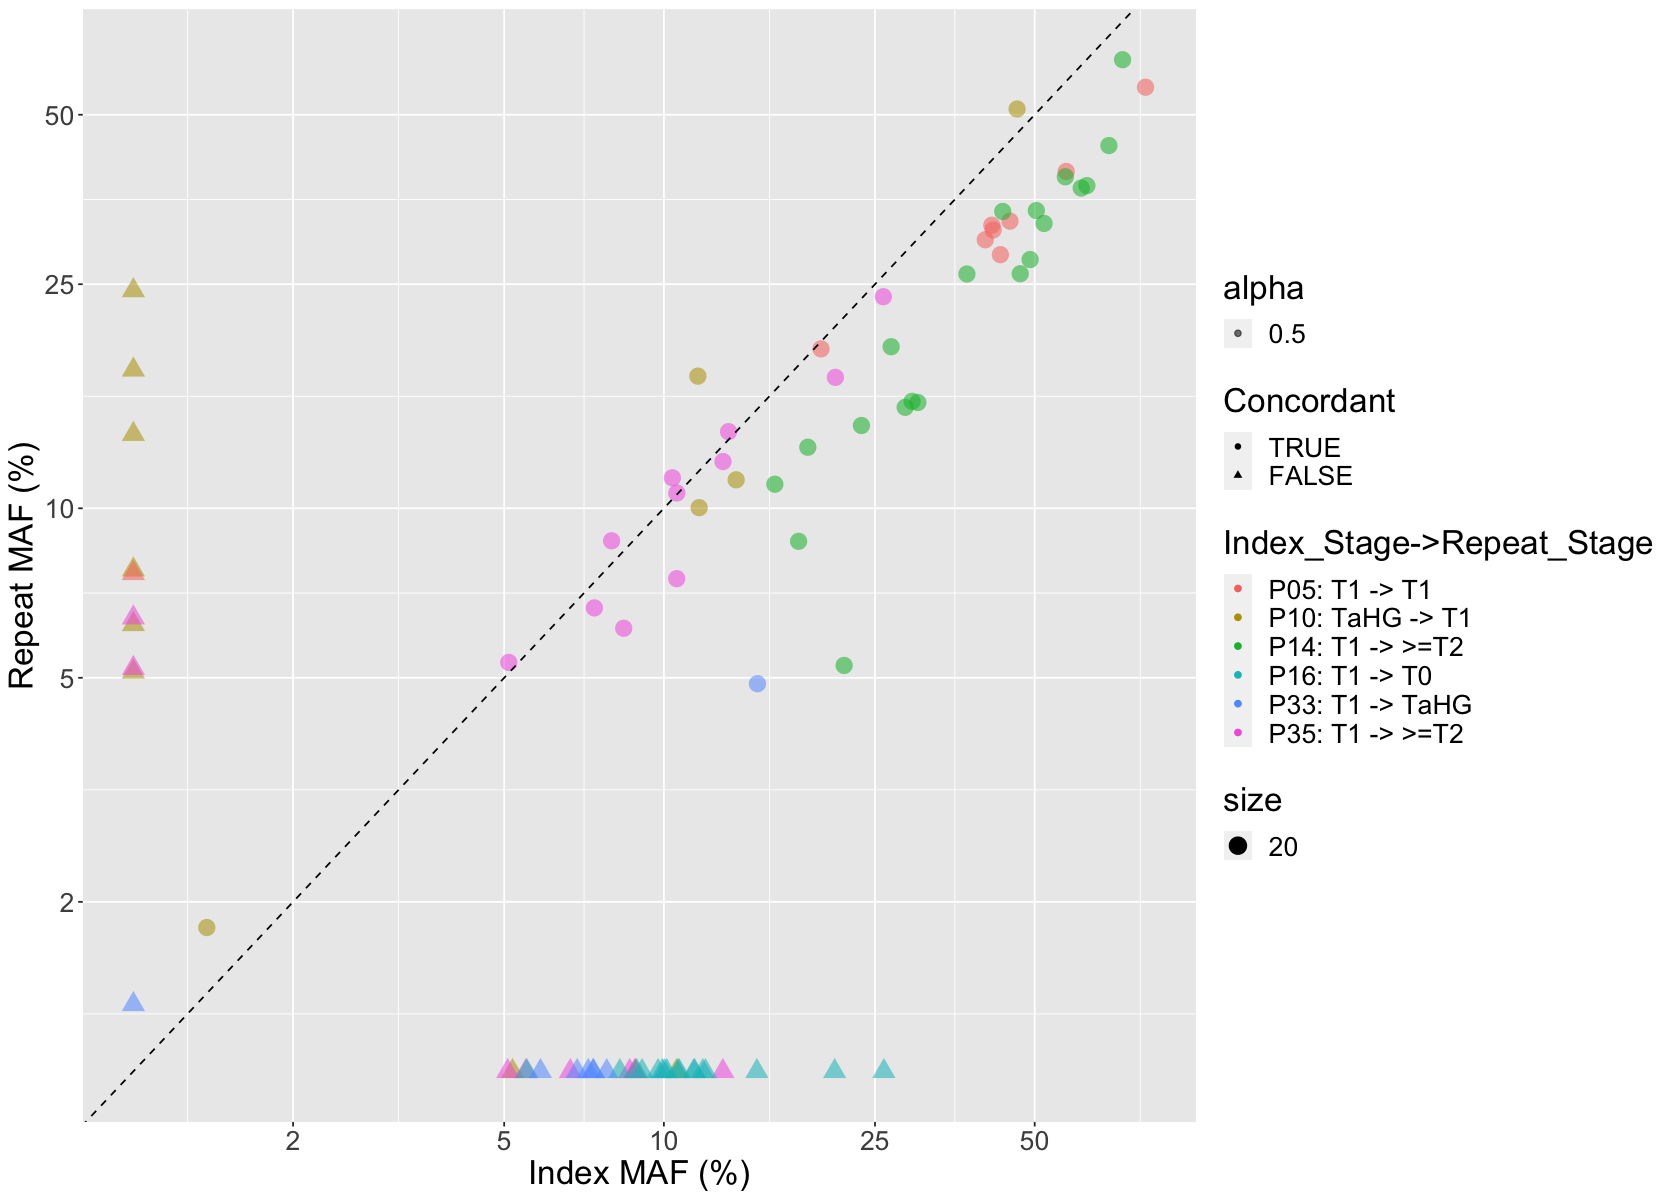

In [149]:
# index vs repeat frequency plot for ATLAS variants only, UNPATCHED, variant_short_all

# Unpatched
df_indexT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, StudyVisit=="IndexTURBT")
df_repeatT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, StudyVisit=="RepeatTURBT")
df_urineT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, SampleType %in% c("Supernatant", "Urine Cell Pellet"))

LOD = 1.0

df_compare_freq = df_indexT %>% full_join(df_repeatT, by=c("PatientID","VariantID"), suffix=c(".index",".repeat")) %>% 
    mutate(VariantFreq.index=ifelse(is.na(VariantFreq.index), LOD, VariantFreq.index),
           VariantFreq.repeat=ifelse(is.na(VariantFreq.repeat), LOD, VariantFreq.repeat),
           Concordant=factor((VariantFreq.repeat!=LOD & VariantFreq.index!=LOD), levels=c(TRUE, FALSE))
           #Patched=ifelse(is.na(Patched.index), Patched.repeat, Patched.index),
           #PatientID=ifelse(is.na(PatientID.index), PatientID.repeat, PatientID.index)
          ) %>%
    left_join(df_clin %>% select(Index.Stage,Repeat.Stage,PatientID), by="PatientID") %>%
           mutate("Patient"=sapply(PatientID, function(x) str_sub(x,-2,-1)), 
                  "Index_Stage->Repeat_Stage"=paste0("P",Patient,": ",Index.Stage," -> ",Repeat.Stage))


#pdf("./ASCO_GU/MAFs_index_vs_repeat_ATLAS_panel_only_12062022.pdf", height=10, width=12)
gg <- ggplot(df_compare_freq, aes(x=VariantFreq.index, y=VariantFreq.repeat, group=Concordant)) + 
        geom_point(aes(color=`Index_Stage->Repeat_Stage`, shape=Concordant, size=20, alpha=0.5)) +
        geom_abline(slope=1, intercept=c(0,0), linetype="dashed") +
        scale_y_continuous(trans='log2', breaks=c(2.0, 5.0, 10.0, 25.0, 50.0)) +
        scale_x_continuous(trans='log2', breaks=c(2.0, 5.0, 10.0, 25.0, 50.0)) +
        labs(x="Index MAF (%)", y="Repeat MAF (%)") +
        theme(text=element_text(size=20))

#show(gg)
#dev.off()
options(repr.plot.width=14, repr.plot.height=10)
show(gg)

[1] 219

[1] "index"


[1] 77

[1] "repeat"


[1] 55

[1] "urine/ucp"


[1] 87

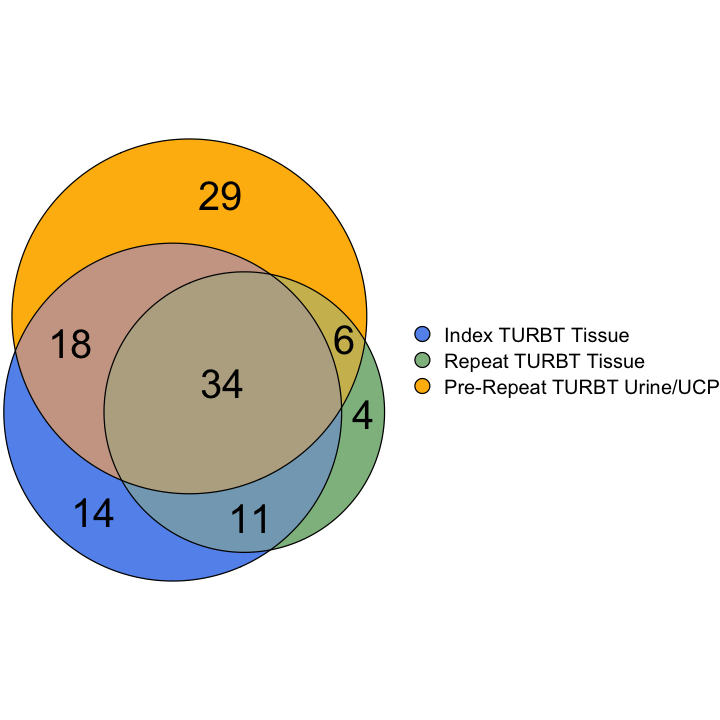

In [183]:
library(eulerr) # Unpatched

#pdf("./ASCO_GU/Venn_ATLAS_variants_12062022.pdf", width=5, height=5)
venn_variants = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short) %>%
                    distinct(SampleID.short, VariantID, .keep_all=T) %>%
                    mutate(label=paste0(PatientID, "_", VariantID)) 
                    
nrow(venn_variants)
index = venn_variants %>% filter(StudyVisit=="IndexTURBT")
print("index")
nrow(index)
repeat. = venn_variants %>% filter(StudyVisit=="RepeatTURBT")
print("repeat")
nrow(repeat.)
urine = venn_variants %>% filter(StudyVisit=="Pre-Repeat TURBT")
print("urine/ucp")
nrow(urine)
stopifnot(nrow(rbind(index,repeat.,urine))==nrow(venn_variants))

options(repr.plot.width=6, repr.plot.height=6)

v <- euler(list("Index TURBT Tissue"=index$label,  
             "Repeat TURBT Tissue"=repeat.$label,
             "Pre-Repeat TURBT Urine/UCP"=urine$label))
eulerr_options(padding = unit(5, "mm"))
plot(v,
     quantities = list(type = "counts", cex=2),
     #labels = list(cex=2.1),
     fills = list(fill = c("cornflowerblue", 
                           "darkseagreen", 
                           "darkgoldenrod1")
                  #alpha=0.6
                 ),
    legend = TRUE)
#dev.off()

In [19]:
unique(all.snv_atlas$SampleType)
unique(all.snv_atlas$StudyVisit)

[1] "Supernatant"       "Urine Cell Pellet" "Tissue"

[1] "Pre-Repeat TURBT" "Surveillance 1"   "Post TURBT"       "RepeatTURBT"     
[5] "IndexTURBT"


      Supernatant            Tissue Urine Cell Pellet 
                6                 7                 1 


      Supernatant            Tissue Urine Cell Pellet 
               10                11                 1 

[1] "NMIBC035"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC013"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


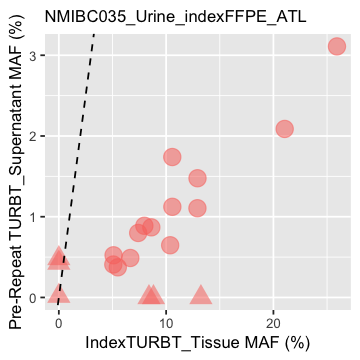

[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC005"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC016"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "WARN: No variants selected for one or both sample types."
[1] "NMIBC033"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC006"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC009"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC010"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC021"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC019"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC003"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC014"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC001"
[1] "NMIBC018"


quartz_off_screen 
                2

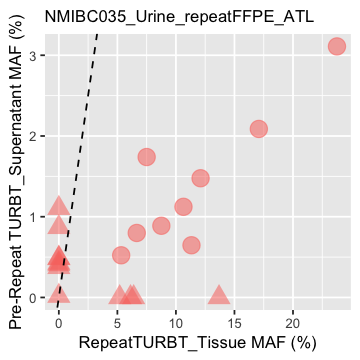

In [34]:
# MAF concordance scatters by patient prerepeat urine vs ffpe, ATLAS, unpatched ## swithch this to the MRD hotspot panel
library(gridExtra)
library(grid)
source("~/Desktop/puffin/R/compareMAFs.R")

df_pre_urine = df_all_qc %>% filter(StudyVisit=="Pre-Repeat TURBT")
df_repeatT = df_all_qc %>% filter(StudyVisit=="RepeatTURBT")
df_indexT = df_all_qc %>% filter(StudyVisit=="IndexTURBT")

patients = intersect(df_pre_urine$PatientID, df_repeatT$PatientID)
df_preurine_repeatT_samples = rbind(df_pre_urine, df_repeatT) %>% filter(PatientID %in% patients)
table(df_preurine_repeatT_samples$SampleType)

patients = intersect(df_pre_urine$PatientID, df_indexT$PatientID)
df_preurine_indexT_samples = rbind(df_pre_urine, df_indexT) %>% filter(PatientID %in% patients)
table(df_preurine_indexT_samples$SampleType)


plt.sz = 3
point.sz = 9
ncol = 2
options(repr.plot.width=plt.sz, repr.plot.height=plt.sz)
# blank_scatter <- function(plot.title){
#     gg <- ggplot(data.frame(x=c(0,0), y=c(0,0)), aes(x=x, y=y)) + 
#            geom_point() +
#            ggtitle(plot.title) +
#             theme(plot.title=element_text(size=10), axis.text=element_blank(), axis.title=element_blank())
#     return(gg)
# }
#blank_scatter <- grid.rect(gp=gpar(col="white", width=5, height=5))

plot.me = TRUE
patients = unique(df_all_qc$PatientID)

# index vs. repeat
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid,"_repeatTURBT_indexFFPE")
    if (pid %in% df_preurine_indexT_samples$PatientID){
        samples = unlist(df_preurine_indexT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples) %>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("IndexTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".1")]] = pid.out$plot
# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_repeatTURBT_indexFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()
        
        
# urine vs index
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid,"_Urine_indexFFPE")
    if (pid %in% df_preurine_indexT_samples$PatientID){
        samples = unlist(df_preurine_indexT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples) %>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("IndexTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".1")]] = pid.out$plot
#     }else{
#         plots[[paste0(pid,".1")]] = blank_scatter(plot.title)
    }
# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_Urine_indexFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()
    
    
# urine vs. repeat
plots = list()
for (pid in patients){
    plot.title=paste0(pid,"_Urine_repeatFFPE")
    if (pid %in% df_preurine_repeatT_samples$PatientID){
        samples = unlist(df_preurine_repeatT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples)%>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("RepeatTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".2")]] = pid.out$plot
#     }else{
#         plots[[paste0(pid,".2")]] = blank_scatter(plot.title)
    }
}
# p <- do.call("grid.arrange", c(plots, ncol=ncol))
# #options(repr.plot.width=15, repr.plot.height=5*length(patients))
# #plot(p)
# pdf("./NMIBC_MAF_scatter_by_patient_Urine_vs_FFPEs_ATL_01102023.pdf", height=(plt.sz*length(patients)), width=plt.sz*ncol)
# plot(p)
# dev.off()

# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_Urine_repeatFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()


In [36]:
all.snv_out = all.snv_unfilt %>% mutate("in.ATLAS"=(VariantID %in% all.snv_atlas$VariantID))
write.table(all.snv_out, "./data/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked.tsv", sep="\t",
            row.names=F, col.names=T, quote=F)

# write.table(all.snv, "./data/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked_somatic.tsv", sep="\t",
#             row.names=F, col.names=T, quote=F)

In [147]:
get_max_concord_maf2 <- function(all_snvs_atlas, ref_sample_types, ref_study_visit, df_qc){
    stopifnot(nrow(df_qc)>0)
    sample_data = list()
    # for each patient, extract preTURB urine/ucp variants
    for (pid in unique(df_qc$PatientID)){
        print(pid)
        df_pid = df_qc %>% filter(PatientID==pid, SampleType!="Buffy Coat")
        ref_sid = df_pid %>% filter(SampleType %in% ref_sample_types, StudyVisit==ref_study_visit)
        if (nrow(ref_sid) >0){
            if (nrow(ref_sid)>1){print(paste0("WARN: more than one ref sample: ",pid))}
            ref_sid = ref_sid$SampleID.short[1]
        }else{
            print(paste0("no ref. sample. skipping: ", pid))
            next
        }
        #print(ref_sid)
        df_ref_vars = all_snvs_atlas %>% filter(SampleID.short==ref_sid)
        n_ref_vars = nrow(df_ref_vars)
        
        df_sel_samples = df_qc %>% filter(PatientID==pid)
        for (sid.short in unique(df_sel_samples$SampleID.short)){
            sample_type = df_pid %>% filter(SampleID.short==sid.short) %>% select(SampleType)
            study_visit = df_pid %>% filter(SampleID.short==sid.short) %>% select(StudyVisit)
            n_sample_vars = nrow(all_snvs_atlas %>% filter(SampleID.short==sid.short))
    
            if (n_sample_vars == 0){
                sample_concord_var = 0
                n_concord_vars = 0
            }else{
                sample_concord_var = all_snvs_atlas %>% filter(SampleID.short==sid.short, VariantID %in% df_ref_vars$VariantID)
                n_concord_vars = nrow(sample_concord_var)
            }
            
            # for finding max MAF:
#             if (nrow(sample_concord_snvs > 0){
#                 max_cMAF = max(sample_concord_snv$altDepth / sample_concord_snv$totalDepth)
#                 #var_name = sample_concord_snv[sample_concord_snv$] TODO
#             }else{
#                 max_cMAF = 0
#             }
#             sample_data[[sid.short]] <- c(n_ref_snvs, n_concord_snvs, max_cMAF, sample_type, pid)
            sample_data[[sid.short]] <- c(n_ref_vars, n_sample_vars, n_concord_vars, sample_type, study_visit, pid)
            #print(length(sample_data))
            }
        }

    df_max_mafs = do.call(rbind, sample_data)
    df_max_mafs <- cbind(rownames(df_max_mafs), data.frame(df_max_mafs, row.names=NULL))
#     names(df_max_mafs) <- c("SampleID.short","n_ref_snvs", "n_concord_snvs", "max_cMAF", "SampleType", "PatientID")
    #names(df_max_mafs) <- c("SampleID.short","n_ref_vars", "n_sample_vars", "n_concord_vars", "SampleType", "StudyVisit","PatientID")
    names(df_max_mafs) <- c("SampleID.short","n_ref_preUrine_snvs", "n_SID_vars", "n_concord_vars", "SampleType", "StudyVisit","PatientID")
    
    # attach cfDNA yields and collection day
    df_max_mafs2 = df_max_mafs %>% left_join(df_qc, by="SampleID.short") #%>% 
#       left_join(df_sid_to_day %>% select(-SampleType), by="SampleID.short") #%>%
      #left_join(df_qc %>% select(SampleID.short, NAYield), by="SampleID.short")
    
    #df_max_mafs2 = df_max_mafs2 %>% filter(n_ref_snvs!=0)
    #df_max_mafs2$amt_ctDNA = df_max_mafs2$NAYield * (df_max_mafs2$max_cMAF / 100) *1000
    #df_max_mafs2$log_amt_ctDNA = log(df_max_mafs2$amt_ctDNA + 1)
    
    return(df_max_mafs2)
    }

In [149]:
df_concord_counts2 = get_max_concord_maf2(all_snvs_atlas = all.snv_atlas,
                                         ref_sample_types= c("Supernatant", "Urine Cell Pellet"),
                                         ref_study_visit="Pre-Repeat TURBT",
                                         df_qc = df_all_qc) #all samples in project

df_concord_counts2

[1] "NMIBC035"
[1] "NMIBC013"
[1] "NMIBC005"
[1] "NMIBC016"
[1] "NMIBC033"
[1] "NMIBC006"
[1] "NMIBC009"
[1] "NMIBC010"
[1] "NMIBC021"
[1] "NMIBC019"
[1] "NMIBC003"
[1] "NMIBC014"
[1] "NMIBC001"
[1] "NMIBC018"


SampleID.short,n_ref_preUrine_snvs,n_SID_vars,n_concord_vars,SampleType.x,StudyVisit.x,PatientID.x,X,SampleID,Total.reads..M.,⋯,category,sampleFolder,Panel2.Target.unique.fragment.coverage,Panel2.Target.read.coverage,Panel2.Within.2.fold.....after.dedup,Panel2.Within.2.fold.....before.dedup,PatientID.y,externalSampleID,StudyVisit.y,Duplicated
<chr>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<int>,<chr>,<dbl>,⋯,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>
P220085,36,23,19,Tissue,IndexTURBT,NMIBC035,1,P220085,260.0,⋯,RUO,P220085_220907,200,341,58.8,59.6,NMIBC035,06S22036059,IndexTURBT,FALSE
P220086,36,22,14,Tissue,RepeatTURBT,NMIBC035,6,P220086,245.0,⋯,RUO,P220086_220907,134,226,50.8,50.6,NMIBC035,06S22052900,RepeatTURBT,FALSE
P217592,36,36,36,Supernatant,Pre-Repeat TURBT,NMIBC035,31,P217592,113.0,⋯,RUO,P217592_221014,NA,NA,NA,NA,NMIBC035,06S22034638,Pre-Repeat TURBT,FALSE
P220076,83,140,79,Tissue,IndexTURBT,NMIBC013,2,P220076,257.0,⋯,RUO,P220076_220902,198,317,57.5,58.4,NMIBC013,06S22068063,IndexTURBT,FALSE
P219771,83,83,83,Supernatant,Pre-Repeat TURBT,NMIBC013,33,P219771,108.0,⋯,RUO,P219771_221014,NA,NA,NA,NA,NMIBC013,06S22021715,Pre-Repeat TURBT,FALSE
P219778,83,54,47,Supernatant,Surveillance 1,NMIBC013,34,P219778,102.0,⋯,RUO,P219778_221014,NA,NA,NA,NA,NMIBC013,06S22049794,Surveillance 1,FALSE
P220070,22,12,9,Tissue,RepeatTURBT,NMIBC005,3,P220070,251.0,⋯,RUO,P220070_220907,169,280,47.1,47.3,NMIBC005,06S22052895,RepeatTURBT,FALSE
P220069,22,11,9,Tissue,IndexTURBT,NMIBC005,5,P220069,245.0,⋯,RUO,P220069_220907,180,339,61.5,61.0,NMIBC005,06S22035975,IndexTURBT,FALSE
P217599,22,19,9,Supernatant,Post TURBT,NMIBC005,26,P217599,126.0,⋯,RUO,P217599_221014,NA,NA,NA,NA,NMIBC005,06S22023956,Post TURBT,FALSE


In [ ]:
# MAF scatters by patient
library(gridExtra)
library(grid)

plt.sz = 3
options(repr.plot.width=plt.sz, repr.plot.height=plt.sz)
blank_scatter <- function(plot.title){
    gg <- ggplot(data.frame(x=c(0,0),y=c(0,0)), aes(x=x, y=y)) + 
           geom_point() +
           ggtitle(plot.title)
    return(gg)
}
#blank_scatter <- grid.rect(gp=gpar(col="white", width=5, height=5))

plot.me = TRUE

patients = df_clin$PatientID
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid," urine_ffpe_WES+")
    if (pid %in% samples_paired_urine_ffpe$PatientID){
        print("urine vs. tissue")
        samples = unique(unlist(samples_paired_urine_ffpe %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_wes = all.snv_wes %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_wes, selectors=c("Cystectomy_FFPE","Pre Op_Urine"),
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".1")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".1")]] = blank_scatter(plot.title)
    }
    
    plot.title=paste0(pid," plasma_ffpe_ATLAS")
    if (pid %in% samples_paired_ffpe_plasma$PatientID){
        print("plasma vs. tissue")
        samples = unique(unlist(samples_paired_ffpe_plasma %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_atlas = all.snv_inAtlas %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_atlas, selectors=c("Cystectomy_FFPE","Pre Op_Plasma"), log.axes=TRUE,
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".2")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".2")]] = blank_scatter(plot.title)
    }
    
    plot.title=paste0(pid," plasma_urine_ATLAS")
    if (pid %in% samples_paired_urine_plasma$PatientID){
        print("urine vs. plasma")
        samples = unique(unlist(samples_paired_urine_plasma %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_atlas = all.snv_inAtlas %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_atlas, selectors=c("Pre Op_Plasma","Pre Op_Urine"), log.axes=TRUE,
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".3")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".3")]] = blank_scatter(plot.title)
    }
}

p <- do.call("grid.arrange", c(plots, ncol=3))
#options(repr.plot.width=15, repr.plot.height=5*length(patients))
#plot(p)

pdf("./MIBC_MAF_scatter_by_patient_01102023.pdf", height=plt.sz*length(patients), width=plt.sz*3)
plot(p)
dev.off()


In [ ]:
# prerepeat_pid n_variants type=unique,index_concordant,repeat_concordant ## need to make this based on percentages
# df_concord_counts_f = df_concord_counts[,1:7]
# pre_rep_counts = df_concord_counts_f %>% filter(StudyVisit.x!="Pre-Repeat TURBT")
# index_counts = df_concord_counts_f %>% filter(StudyVisit.x!="IndexTURBT")
# repeat_counts = df_concord_counts_f %>% filter(StudyVisit.x!="RepeatTURBT")

# df_plot = pre_rep_counts %>% select(PatientID.x, n_SID_vars) %>% 
#                 left_join(index_counts %>% select(PatientID.x, n_concord_vars), by="PatientID.x") %>%
#                 left_join(repeat_counts %>% select(PatientID.x, n_concord_vars), by="PatientID.x", suffix=c(".index",".repeat")) %>%
#           mutate(unique.vars)
#           pivot_longer(!PatientID.x, names_to="Variants")

# head(df_plot)

# ggplot(df_plot, aes(x=as.character(PatientID.x), y=as.numeric(value), fill=Variants)) +
#     geom_bar(stat = "identity")

## LPWGS CNB + TF analysis (urine) - see second notebook

[1] TRUE
[1] TRUE
[1] 43
number of NA labels: 0
[1] "case/control: 22 / 21"


Setting levels: control = FALSE, case = TRUE



  threshold specificity sensitivity
1    0.0218   0.7142857   0.8181818
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.762987012987013"


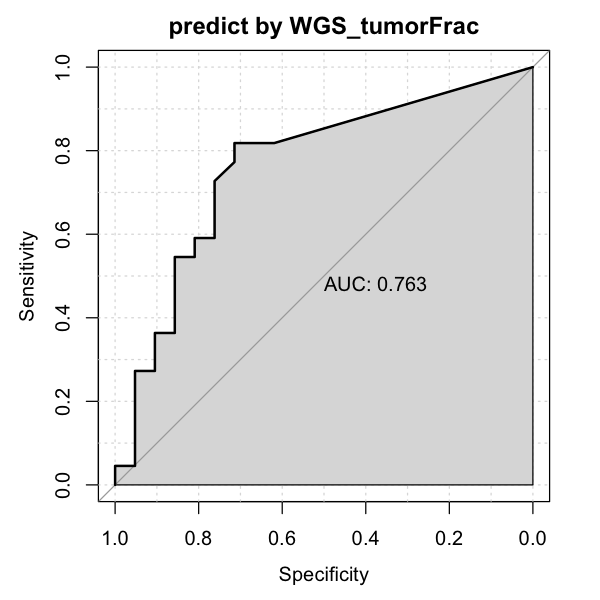

In [79]:
options(repr.plot.width=5, repr.plot.height=5)

get_sens_spec <- function(df, label_col, score_col, title=NA, thresh=NA, target_sens=NA){
    print(label_col %in% names(df))
    print(score_col %in% names(df))
    print(sum(!is.na(df[[score_col]])))
    df = df %>% rename("label"={{label_col}}, "score"={{score_col}}) %>% mutate("label"=as.character(label))
    print(glue("number of NA labels: {sum(is.na(df$label))}"))
    print(sprintf("case/control: %s / %s", sum(df$label=="TRUE"), sum(df$label=="FALSE")))
    
    if (!is.na(thresh)){
      TP = nrow(df %>% filter(label=="TRUE", score >= thresh))
      FN = nrow(df %>% filter(label=="TRUE", score < thresh))
      TN = nrow(df %>% filter(label=="FALSE", score < thresh))
      FP = nrow(df %>% filter(label=="FALSE", score >= thresh))
      sens = TP/(TP + FN)
      spec = TN/(TN + FP)
      print(paste("Threshold Sens:", sens))
      print(paste("Threshold Spec:", spec))
        }
    
    pROC_obj <- roc_(data=df, response="label", 
                predictor="score", smooth = FALSE, plot=FALSE, direction="<") # controls score lower than cases
    if (!is.na(title)){
       plot.roc(pROC_obj, auc.polygon=TRUE, max.auc.polygon=FALSE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE, main=title)
    }
    print(coords(pROC_obj, x="best"))
    
    if (!is.na(target_sens)){
        print(sprintf("target sens %s", target_sens))
        print(coords(pROC_obj, x=target_sens, input="sensitivity", 
                     ret=c("threshold","specificity", "sensitivity")))
        }
    print(paste0("AUC: ", auc(pROC_obj)))
}
# for ESMO abstract
get_sens_spec(df_urine_pre, "disease.positive", "wgsTumorfrac_ichorCNA", target_sens=1.0, title="predict by WGS_tumorFrac")

In [51]:
## selection table for WES+
# check patient treatment and expected followup samples with MCC
source("~/Desktop/puffin/R/helper_functions.R")
unique(df_lpwgs_all$SampleType)
unique(df_lpwgs_all$StudyVisit)

df_urine_post = df_lpwgs_all %>% filter(SampleType == "Urine", 
                                        StudyVisit!="Pre-Repeat TURBT")
nrow(df_urine_post)
df_pbmc_all = df_wes_qc.all %>% filter(SampleType %in% c("PBMC", "Buffy Coat", "Buffy_Coat"))
nrow(df_pbmc_all)
df_preurine_summary = standardize_names(df_lpwgs_all, "samples") %>% filter(SampleType=="Urine", StudyVisit=="Pre-Repeat TURBT")

# did we do lpwgs for these batch 1 samples? lpwgs data missing
ss = df_wes_qc1.urine_pbmc %>% filter(Specimen_type=="Supernatant")

df_preurine_summary = df_preurine_summary %>%
                                left_join(df_clin %>% select(PatientID, Sex, Index.Stage, Repeat.Stage, disease.positive), by="PatientID") %>%
                                mutate(has.germ = PatientID %in% df_pbmc_all$PatientID,
                                       n.followup.urines = (lapply(PatientID, function(x) sum(df_urine_post$PatientID == x))),
                                       WES.completed=SampleID.short %in% ss$SampleID)
                                                                                         
df_concord = get_concordance_stats(variant.data = all.snv, ref_sample_type = "IndexTURBT_Tissue", 
                                        df_samples = df_wes_qc.all)

df_preurine_summary = df_preurine_summary %>% left_join(df_concord %>% filter(StudyVisit=="IndexTURBT"), by="PatientID") %>%
                                              left_join(df_concord %>% filter(StudyVisit=="RepeatTURBT"), by="PatientID",
                                                           suffix=c(".index",".repeat")) %>%
                                              left_join(df_concord %>% filter(StudyVisit=="Pre-Repeat TURBT") %>% 
                                                                        select(PatientID,n_sample_vars,n_concord_vars), by="PatientID") %>%
                                              left_join(df_qc_all, by="SampleID.short", suffix=c(".",".qc")) %>%
                                              left_join(df_wes_qc2.all %>% select(SampleID.short, library_yield_ug), by="SampleID.short", suffix=c(".",".ngsqc"))
df_preurine_summary$MRD.completed = (df_preurine_summary$SampleID.short.x %in% mrd.table$SampleID.short)
stopifnot(all(!duplicated(df_preurine_summary$SampleID.short.x)))      
                                                            
write.csv(df_preurine_summary %>% mutate(across(everything(),as.character)) %>%
                                  relocate(PatientID., SampleID.short.x, SampleType.x, StudyVisit.x, DNAYield, library_yield_ug, 
                                           wgsTumorfrac_ichorCNA, wgsTumorfrac_EM, cnbScore, 
                                           Sex, Index.Stage, Repeat.Stage, disease.positive, has.germ, n.followup.urines, WES.completed, MRD.completed, 
                                           n_sample_vars.index, n_sample_vars.repeat, n_concord_vars.repeat, pct.concord.repeat),
          "./prerepeat_urine_wes_selection_table_05192023.csv", row.names=F) # refine in excel                                              

[1] "Tissue" "Urine"

[1] "IndexTURBT"       "RepeatTURBT"      "Post TURBT"       "Surveillance 1"  
[5] "Pre-Repeat TURBT" "Follow Up 1"

[1] 41

[1] 46

[1] "Pre-Repeat TURBT" "IndexTURBT"       "RepeatTURBT"     
[1] "PBMC"   "Urine"  "Tissue"
[1] "WARN: No ref. sample for: NMIBC006"
[1] "WARN: No ref. sample for: NMIBC018"
[1] "WARN: No ref. sample for: NMIBC001"
[1] "WARN: No ref. sample for: NMIBC011"
[1] "WARN: No ref. sample for: 174947"
[1] "WARN: No ref. sample for: 173281"
[1] "reference sample: IndexTURBT_Tissue"
[1] "median number reference variants: 154"
[1] "min: 0"
[1] "max: 1392"
[1] "sd: 303.474386873707"
[1] "MRD sample: Pre-Repeat TURBT_Urine" "MRD sample: RepeatTURBT_Tissue"    
[1] "median number MRD variants: 42.5"
[1] "min: 0"
[1] "max: 1113"
[1] "sd: 203.173380293514"
